In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn


plt.style.use("seaborn")
if "ipynb" in os.getcwd():
    os.chdir("..")

data = pd.read_csv("./anomaly_data/dockerfiles_rubisdb_1_20190818-1900_20190819-0900_5.csv")
df_1 = data.copy()

In [2]:
# time stamp 型に対しての前処理
df_1["timestamp"] = pd.to_datetime(df_1['timestamp'], format = '%Y-%m-%d %H:%M:%S')

df_1['dif_sec'] = df_1['timestamp'].diff().dt.total_seconds()
df_1["dif_sec"] = df_1['dif_sec'].fillna(0)

T_train_list = df_1['dif_sec'].copy()

from scipy import fftpack

data = df_1['node_cpuusage']

sample_freq =fftpack.fftfreq(data.size,d=0.2)  # dはサンプリング周波数[Hz]
sig_fit = fftpack.fft(data)
using_index = np.where(sample_freq > 0)    # sample_freqの正の値を返す、index値を返す
freq, power = sample_freq[using_index], np.abs(sig_fit)[using_index]

sig_fit[np.abs(sample_freq) > 0.7] = 0    # ノイズを削除
remove_noise_data =np.real( fftpack.ifft(sig_fit))  # 逆フーリエする。実際使うデータ

data_FFT = pd.DataFrame(data = remove_noise_data.reshape(-1, 1))
data_1= pd.concat([data_FFT, df_1['dif_sec']], axis = 1)
data = data_1.rename(columns = {0: 'node_cpu_usage_after_fft'})

df_fft_data = data['node_cpu_usage_after_fft'].copy()
X = df_fft_data.as_matrix().reshape(-1, 1)

C:\Users\neki-at\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
data['dif_value'] = data['node_cpu_usage_after_fft'].diff()
data['dif_value'] = data['dif_value'].fillna(0)
X_diff = data['dif_value']

n = round(X.shape[0] * 0.15) # trianデータの数

steep_rate = X_diff[:n]/T_train_list[:n]
steep_rate = list(steep_rate)
steep_rate[0] = 0    # Nan値の埋め合わせ

polling_time = data['dif_sec'].as_matrix()

C:\Users\neki-at\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


## 他の正常データで学習したパラメータの読み込み

In [4]:
import pickle

# 読み込み
f = open("anomaly_score_list.binaryfile", mode="rb")
score = pickle.load(f)

In [5]:
log_score = np.log(score)

In [6]:
log_score_list = [log_score[i] for i in range(len(log_score))]
log_score_list

[-4.683160555480165,
 -8.956241017819325,
 -10.04677480341833,
 -8.734656131282755,
 -13.654155151242826,
 -10.169969896452733,
 -10.186175857910662,
 -7.722638208790506,
 -6.561062054594979,
 -8.035363440595509,
 -8.943307683127541,
 -9.188829837929017,
 -12.204982252983818,
 -11.580312203324326,
 -7.15713940381181,
 -8.154972964109728,
 -6.499258800583994,
 -7.487848131777899,
 -6.720233389629175,
 -6.192528462884005,
 -5.802499271221589,
 -5.713751730161854,
 -6.577036605010455,
 -9.923449912540406,
 -10.377858143036034,
 -12.221258931931477,
 -12.470251646315925,
 -10.171346689442498,
 -6.480352811691018,
 -6.09431189480653,
 -8.975934963500334,
 -9.269166199758411,
 -6.439509642821448,
 -6.171236463482061,
 -8.067767332165607,
 -8.971629750597138,
 -9.050030612500047,
 -16.017965583467795,
 -9.747517511065368,
 -9.850907117718455,
 -11.98460014383701,
 -10.494557096802337,
 -10.343647369188153,
 -8.769989498406144,
 -7.443043043217592,
 -7.050965012814259,
 -6.822555957323951,
 -6

In [21]:
import scipy.stats as st
import time
mu, sigma = st.norm.fit(log_score, loc = -7, scale = 0.5)
#rv = st.norm(loc = mu, scale = sigma)

#a_th_1st = rv.ppf(q=0.5)
#a_th = rv.ppf(q = 0.95)


def my_Algo1(window_size, data, Polling_time, f_min, f_max, past_anomaly_score, mu, sigma,  T_old = 10):

    '''
    dataはnumpy配列を想定
    past_anomaly_score は list型
    '''

    X = data
    N = window_size
    T = [Polling_time[i] for i in range(len(Polling_time))]
    window_size_list = []
    window_size_list.append(N)  
    train_size = int(np.round(X.shape[0] * 0.15))
    sample_queue = list(X[:train_size])
    test_data = X[train_size:]

    T.append(T_old)
    refer_index = (train_size - 1) + int(np.round(T[-1]/5))   # 参照するindex値
    Polling_time_list = []
    Polling_time_list.append(T[-1])
    test_index = int(np.round(T[-1]/5)) - 1 # 参照するtestデータのindex値
    refer_index_list = []
    predict_list = []
    test_index_list = []
    test_index_list.append(test_index)
    count = 1
    anomaly_score_list = []

    while refer_index <= X.shape[0]:

        '''
        次のデータ点の予測
        '''
        start_time = time.time()
        sum_N = sum(steep_rate[-(N-1):])
        x_pred = sample_queue[-1] + (T[-1]/(N-1)) * sum_N
        

        print("=======================================================")
        print("sample_queue [-1] は{}です。".format(sample_queue[-1]))
        print("(T[-1]/(N-1)) * sum_Nは{}です。".format((T[-1]/(N-1)) * sum_N))
        print("現在参照しているデータのindex値は{}です。".format(refer_index))
        print("Nの値は{}です".format(N))

        

        # 実測値を受けとる
        if test_index >= test_data.shape[0]:
            break
            
        predict_list.append(x_pred)
        refer_index_list.append(refer_index)
        x_real = test_data[test_index]    


        '''
        類似度ベクトルの計算
        '''

        slope_predict = np.array([x_pred - sample_queue[-1], T[-1]]).reshape(-1, 1)
        slope_real = np.array([x_real - sample_queue[-1], T[-1] ]).reshape(-1, 1)

        similar_vec_score = np.abs(np.dot(slope_predict.T, slope_real)/(np.linalg.norm(slope_predict) * np.linalg.norm(slope_real)))
        anomaly_score = 1 - similar_vec_score
        if not isinstance(anomaly_score, np.ndarray):
            anomaly_score = np.array(anomaly_score)
            
            
        anomaly_score_list.append(anomaly_score[0][0])
        past_anomaly_score.append(np.log(anomaly_score[0][0]))
        
        #print("実測値と予測値の誤差は{}です".format(x_pred - x_real ))
        #print("異常スコアは{}です。".format(anomaly_score[0][0]))


        """
        window size 内のデータで正規分布のフィッティング

        """

        past_anomaly_list = past_anomaly_score[-N:]     # 過去N個のデータ点を参照して推定に用いるデータに代入
        #print(past_anomaly_list)
        mu, sigma = st.norm.fit(past_anomaly_list, loc = mu, scale = sigma)   # fitting
        rv = st.norm(loc = mu, scale = sigma)
        a_th_1st = rv.ppf(q = 0.8)
        a_th = rv.ppf(q = 0.97)
        print("第一閾値は{}".format(a_th_1st))
        print("第二閾値は{}".format(a_th))




        '''
        T の更新部分
        '''

        log_anomaly_score = np.log(anomaly_score[0][0])
        print("対数異常度は{}".format(log_anomaly_score))
        if log_anomaly_score <= a_th_1st:
            T_new = 1/f_min

        elif a_th_1st <= log_anomaly_score <= a_th:

            T_new = (1/f_min - 1/f_max)/(a_th_1st - a_th) * (log_anomaly_score - a_th) + 1/f_max

        else:
            T_new = 1/f_max


        sample_queue.append(x_real)
        
        print("次回のPolling timeは{}秒後です".format(T_new))
        T.append(T_new)


        '''
        AIMDの実装部分
        '''
        if T_new >= T_old:
            N += 1

        else:
            N = int(np.round(N * 0.8))
            if N<5:
                N=5

        window_size_list.append(N)
        refer_index += int(np.round(T[-1]/5))
        test_index += int(np.round(T[-1]/5))
        if test_index < len(test_data):
            test_index_list.append(test_index)
            
        Polling_time_list.append(T_new)
        steep_rate.append((sample_queue[-1] - sample_queue[-2])/T_old)
        print("steep_lateに{}を追加しました".format((sample_queue[-1] - sample_queue[-2])/T_old))
        print("次回のPolling timeは{}秒後です".format(T_new))
        print("次の参照データのindex値は{}です。".format(refer_index))
        print("{}回目終了".format(count))
        T_old = T_new
        end_time = time.time()
        count += 1
        print("１回の処理時間は{}秒です".format(end_time - start_time))

    return Polling_time_list, window_size_list, refer_index_list, predict_list, anomaly_score_list, test_index_list, count


In [9]:
# f_max打ち切り最小, f_minは打ち切り最大)
polling_time_list, window_size_list, refer_index_list, predict_list, anomaly_score_list, test_index, count = my_Algo1(
    
                                                                window_size = 100, 
                                                                data = X,
                                                                Polling_time = polling_time, 
                                                                f_max = 0.2, f_min = 1/100,
                                                                past_anomaly_score = log_score_list,
                                                                mu = mu,
                                                                sigma = sigma,                            
                                                                T_old = 30)  

sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは-0.136573128688339です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-7.43341036]
第二閾値は[-4.91575561]
対数異常度は[-6.43899321]
次回のPolling timeは[62.47713079]秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは[62.47713079]秒後です
次の参照データのindex値は1529です。
1回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[-0.24906875]です。
現在参照しているデータのindex値は1529です。
Nの値は101です
第一閾値は[-7.44716524]
第二閾値は[-4.94167713]
対数異常度は-9.866465823333257
次回のPolling timeは100.0秒後です
steep_lateに[-0.01417436]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は1549です。
2回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[12.80198806]です。
(T[-1]/(N-1)) * sum_Nは[-0.40874281]です。
現在参照しているデータのindex値は1549です。
Nの値は102です
第一閾値は[-7.47123699]
第二閾値は[-4.95804555]
対数異常度は[-12.56803383]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00144864]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は1569です。
3回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.65712

第一閾値は[-7.77443105]
第二閾値は[-5.37109567]
対数異常度は[-9.55680314]
次回のPolling timeは100.0秒後です
steep_lateに[-0.01192638]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は3019です。
77回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.29894938]です。
(T[-1]/(N-1)) * sum_Nは[-0.0253257]です。
現在参照しているデータのindex値は3019です。
Nの値は55です
第一閾値は[-7.78079424]
第二閾値は[-5.39809616]
対数異常度は[-9.15158414]
次回のPolling timeは100.0秒後です
steep_lateに[0.01431162]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は3039です。
78回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.73011105]です。
(T[-1]/(N-1)) * sum_Nは[0.00115589]です。
現在参照しているデータのindex値は3039です。
Nの値は56です
第一閾値は[-7.81806995]
第二閾値は[-5.39267133]
対数異常度は[-13.73461803]
次回のPolling timeは100.0秒後です
steep_lateに[0.00148415]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は3059です。
79回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.87852563]です。
(T[-1]/(N-1)) * sum_Nは[0.00378551]です。
現在参照しているデータのindex値は3059です。
Nの値は57です
第一閾値は[-7.85812217]
第二閾値は[-5.43816564]
対数異常度は[-11.81413731

第一閾値は[-9.27244148]
第二閾値は[-7.47101047]
対数異常度は-10.71220814881227
次回のPolling timeは100.0秒後です
steep_lateに[0.0070098]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は4440です。
150回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.1523509]です。
(T[-1]/(N-1)) * sum_Nは[0.05319317]です。
現在参照しているデータのindex値は4440です。
Nの値は35です
第一閾値は[-9.28795708]
第二閾値は[-7.3447822]
対数異常度は[-15.29238049]
次回のPolling timeは100.0秒後です
steep_lateに[0.00120773]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は4460です。
151回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.27312391]です。
(T[-1]/(N-1)) * sum_Nは[0.05512402]です。
現在参照しているデータのindex値は4460です。
Nの値は36です
第一閾値は[-9.31750354]
第二閾値は[-7.26046903]
対数異常度は[-15.24511781]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00014072]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は4480です。
152回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.25905212]です。
(T[-1]/(N-1)) * sum_Nは[0.05320192]です。
現在参照しているデータのindex値は4480です。
Nの値は37です
第一閾値は[-9.32530677]
第二閾値は[-7.29452574]
対数異常度は[-10.48

第一閾値は[-6.59470102]
第二閾値は[-3.16235194]
対数異常度は[-6.7238077]
次回のPolling timeは100.0秒後です
steep_lateに[0.03759418]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は6003です。
238回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[14.37584969]です。
(T[-1]/(N-1)) * sum_Nは[-1.05501838]です。
現在参照しているデータのindex値は6003です。
Nの値は55です
第一閾値は[-6.60142483]
第二閾値は[-3.19802554]
対数異常度は[-8.45480839]
次回のPolling timeは100.0秒後です
steep_lateに[-0.03119395]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は6023です。
239回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.25645468]です。
(T[-1]/(N-1)) * sum_Nは[-1.0925525]です。
現在参照しているデータのindex値は6023です。
Nの値は56です
第一閾値は[-6.61356039]
第二閾値は[-3.23949627]
対数異常度は[-8.70694257]
次回のPolling timeは100.0秒後です
steep_lateに[0.00726503]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は6043です。
240回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.9829573]です。
(T[-1]/(N-1)) * sum_Nは[-1.06006938]です。
現在参照しているデータのindex値は6043です。
Nの値は57です
第一閾値は[-6.56137128]
第二閾値は[-3.19023146]
対数異常度は[-6.23642381

steep_lateに[-0.021305]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は7580です。
317回目終了
１回の処理時間は0.016000986099243164秒です
sample_queue [-1] は[11.70524737]です。
(T[-1]/(N-1)) * sum_Nは[-0.5441404]です。
現在参照しているデータのindex値は7580です。
Nの値は112です
第一閾値は[-7.35018565]
第二閾値は[-4.62917444]
対数異常度は[-9.06021921]
次回のPolling timeは100.0秒後です
steep_lateに[0.00980362]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は7600です。
318回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.68560924]です。
(T[-1]/(N-1)) * sum_Nは[-0.53052877]です。
現在参照しているデータのindex値は7600です。
Nの値は113です
第一閾値は[-7.37375451]
第二閾値は[-4.65002373]
対数異常度は[-12.46609317]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00808217]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は7620です。
319回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.87739246]です。
(T[-1]/(N-1)) * sum_Nは[-0.53298619]です。
現在参照しているデータのindex値は7620です。
Nの値は114です
第一閾値は[-7.393379]
第二閾値は[-4.67781496]
対数異常度は[-11.06286406]
次回のPolling timeは100.0秒後です
steep_lateに[-0.01093098]を追加しました
次回のPolling timeは100.

第一閾値は[-7.52494541]
第二閾値は[-4.93271492]
対数異常度は[-8.57967905]
次回のPolling timeは100.0秒後です
steep_lateに[-0.01838351]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は8981です。
393回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.01548334]です。
(T[-1]/(N-1)) * sum_Nは[0.06308369]です。
現在参照しているデータのindex値は8981です。
Nの値は53です
第一閾値は[-7.52879231]
第二閾値は[-4.77929204]
対数異常度は[-16.57898924]
次回のPolling timeは100.0秒後です
steep_lateに[0.00027567]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は9001です。
394回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.04305027]です。
(T[-1]/(N-1)) * sum_Nは[0.06241356]です。
現在参照しているデータのindex値は9001です。
Nの値は54です
第一閾値は[-7.57893226]
第二閾値は[-4.8124044]
対数異常度は[-13.20784854]
次回のPolling timeは100.0秒後です
steep_lateに[0.00254046]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は9021です。
395回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.29709601]です。
(T[-1]/(N-1)) * sum_Nは[0.06596231]です。
現在参照しているデータのindex値は9021です。
Nの値は55です
第一閾値は[-7.60413531]
第二閾値は[-4.86261229]
対数異常度は[-10.091877

# 上限を変えた時のRMSEとかの変化を見る

In [28]:
import evaluation_by_rmse as eva
import scipy.stats as st
import time
sample_list = [X[i] for i in refer_index_list]
train_size = int(np.round(X.shape[0] * 0.15))

func = eva. rmse(data = X, test_data = X[train_size:],
            refer_index = refer_index_list, 
            test_index = test_index, 
            sample_queue = sample_list )
jogen_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rmse_list = []
count_list = []


for i in jogen_list:
    mu, sigma = st.norm.fit(log_score, loc = -7, scale = 0.5)
    polling_time_list, window_size_list, refer_index_list, predict_list, anomaly_score_list, test_index, count = my_Algo1(
    
                                                                window_size = 100, 
                                                                data = X,
                                                                Polling_time = polling_time, 
                                                                f_max = 0.2, f_min = 1/i,
                                                                past_anomaly_score = log_score_list,
                                                                mu = mu,
                                                                sigma = sigma,                            
                                                                T_old = 30)  
    count_list.append(count)
    sample_list = [X[i] for i in refer_index_list]
    train_size = int(np.round(X.shape[0] * 0.15))

    func = eva.rmse(data = X, test_data = X[train_size:],
            refer_index = refer_index_list, 
            test_index = test_index, 
            sample_queue = sample_list)
    rmse_list.append(func.evaluation())


sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは-0.136573128688339です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-7.43341036]
第二閾値は[-4.91575561]
対数異常度は[-6.43899321]
次回のPolling timeは[8.02511215]秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは[8.02511215]秒後です
次の参照データのindex値は1519です。
1回目終了
１回の処理時間は0.007000446319580078秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[-0.01078035]です。
現在参照しているデータのindex値は1519です。
Nの値は80です
第一閾値は[-7.35600178]
第二閾値は[-4.75600582]
対数異常度は-8.390365405182544
次回のPolling timeは10.0秒後です
steep_lateに[0.01996909]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1521です。
2回目終了
１回の処理時間は0.006000041961669922秒です
sample_queue [-1] は[13.84781577]です。
(T[-1]/(N-1)) * sum_Nは[-0.01076922]です。
現在参照しているデータのindex値は1521です。
Nの値は81です
第一閾値は[-7.37924255]
第二閾値は[-4.7928489]
対数異常度は[-10.45189712]
次回のPolling timeは10.0秒後です
steep_lateに[-0.00867892]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1523です。
3回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.76102655]です。
(T[

第一閾値は[-4.8012827]
第二閾値は[-2.44020613]
対数異常度は[-10.64454226]
次回のPolling timeは10.0秒後です
steep_lateに[-0.00639867]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1666です。
77回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.56601531]です。
(T[-1]/(N-1)) * sum_Nは[0.00364237]です。
現在参照しているデータのindex値は1666です。
Nの値は50です
第一閾値は[-4.84796873]
第二閾値は[-2.47687274]
対数異常度は[-9.45354449]
次回のPolling timeは10.0秒後です
steep_lateに[0.0128879]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1668です。
78回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.69489434]です。
(T[-1]/(N-1)) * sum_Nは[0.0061471]です。
現在参照しているデータのindex値は1668です。
Nの値は51です
第一閾値は[-4.85971885]
第二閾値は[-2.5114607]
対数異常度は[-6.42425513]
次回のPolling timeは10.0秒後です
steep_lateに[-0.05640426]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1670です。
79回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.13085171]です。
(T[-1]/(N-1)) * sum_Nは[-0.00503309]です。
現在参照しているデータのindex値は1670です。
Nの値は52です
第一閾値は[-4.85508504]
第二閾値は[-2.52506248]
対数異常度は[-5.75262162]
次回のPollin

第一閾値は[-5.28545983]
第二閾値は[-3.49023408]
対数異常度は-5.074382671446989
次回のPolling timeは[9.41211528]秒後です
steep_lateに[-0.11393012]を追加しました
次回のPolling timeは[9.41211528]秒後です
次の参照データのindex値は1813です。
153回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.28144463]です。
(T[-1]/(N-1)) * sum_Nは[-0.04556135]です。
現在参照しているデータのindex値は1813です。
Nの値は35です
第一閾値は[-5.28019223]
第二閾値は[-3.50574141]
対数異常度は-5.966146163072269
次回のPolling timeは10.0秒後です
steep_lateに[0.06688562]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1815です。
154回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.91097978]です。
(T[-1]/(N-1)) * sum_Nは[-0.02791389]です。
現在参照しているデータのindex値は1815です。
Nの値は36です
第一閾値は[-5.15237852]
第二閾値は[-3.32560437]
対数異常度は[-3.64157051]
次回のPolling timeは[5.86481993]秒後です
steep_lateに[0.23063442]を追加しました
次回のPolling timeは[5.86481993]秒後です
次の参照データのindex値は1816です。
155回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.21732399]です。
(T[-1]/(N-1)) * sum_Nは[0.0292989]です。
現在参照しているデータのindex値は1816です。
Nの値は29です
第一閾値は[-4.86362113]
第

第一閾値は[-4.21245706]
第二閾値は[-2.37431649]
対数異常度は-8.076922709965256
次回のPolling timeは10.0秒後です
steep_lateに[0.03221818]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1987です。
241回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.47303543]です。
(T[-1]/(N-1)) * sum_Nは[0.08528445]です。
現在参照しているデータのindex値は1987です。
Nの値は21です
第一閾値は[-4.16950687]
第二閾値は[-2.35349563]
対数異常度は[-4.42283354]
次回のPolling timeは10.0秒後です
steep_lateに[-0.14760579]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1989です。
242回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.99697749]です。
(T[-1]/(N-1)) * sum_Nは[0.01093481]です。
現在参照しているデータのindex値は1989です。
Nの値は22です
第一閾値は[-4.24699291]
第二閾値は[-2.36032772]
対数異常度は[-8.60387093]
次回のPolling timeは10.0秒後です
steep_lateに[-0.01806051]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は1991です。
243回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.81637236]です。
(T[-1]/(N-1)) * sum_Nは[0.00222845]です。
現在参照しているデータのindex値は1991です。
Nの値は23です
第一閾値は[-4.28557827]
第二閾値は[-2.44021348]
対数異常度は[-5.89313064

次回のPolling timeは10.0秒後です
次の参照データのindex値は2149です。
322回目終了
１回の処理時間は0.01500082015991211秒です
sample_queue [-1] は[13.00593726]です。
(T[-1]/(N-1)) * sum_Nは[-0.01305625]です。
現在参照しているデータのindex値は2149です。
Nの値は35です
第一閾値は[-5.53626026]
第二閾値は[-3.50502192]
対数異常度は[-9.36260121]
次回のPolling timeは10.0秒後です
steep_lateに[0.01180047]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2151です。
323回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[13.12394195]です。
(T[-1]/(N-1)) * sum_Nは[-0.00931165]です。
現在参照しているデータのindex値は2151です。
Nの値は36です
第一閾値は[-5.48338241]
第二閾値は[-3.45336252]
対数異常度は[-5.24222359]
次回のPolling timeは[9.40601859]秒後です
steep_lateに[-0.10419557]を追加しました
次回のPolling timeは[9.40601859]秒後です
次の参照データのindex値は2153です。
324回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.08198624]です。
(T[-1]/(N-1)) * sum_Nは[-0.04473943]です。
現在参照しているデータのindex値は2153です。
Nの値は29です
第一閾値は[-5.34524157]
第二閾値は[-3.23923634]
対数異常度は-5.760960610044036
次回のPolling timeは10.0秒後です
steep_lateに[-0.08432471]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex

第一閾値は[-5.31432829]
第二閾値は[-2.63508273]
対数異常度は-5.299821919395324
次回のPolling timeは[9.97292825]秒後です
steep_lateに[-0.09056081]を追加しました
次回のPolling timeは[9.97292825]秒後です
次の参照データのindex値は2332です。
414回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.72416868]です。
(T[-1]/(N-1)) * sum_Nは[0.05461897]です。
現在参照しているデータのindex値は2332です。
Nの値は25です
第一閾値は[-5.42089298]
第二閾値は[-2.7317666]
対数異常度は-10.348416003921795
次回のPolling timeは10.0秒後です
steep_lateに[-0.00252879]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2334です。
415回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.69894919]です。
(T[-1]/(N-1)) * sum_Nは[0.05156503]です。
現在参照しているデータのindex値は2334です。
Nの値は26です
第一閾値は[-5.42877721]
第二閾値は[-2.78710016]
対数異常度は[-6.80464064]
次回のPolling timeは10.0秒後です
steep_lateに[0.05229595]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2336です。
416回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.2219087]です。
(T[-1]/(N-1)) * sum_Nは[0.06969558]です。
現在参照しているデータのindex値は2336です。
Nの値は27です
第一閾値は[-5.3903604]
第二閾値は[-2.77749577

現在参照しているデータのindex値は2501です。
Nの値は26です
第一閾値は[-4.20972009]
第二閾値は[-1.78197732]
対数異常度は-4.252146364266595
次回のPolling timeは10.0秒後です
steep_lateに[-0.18432338]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2503です。
501回目終了
１回の処理時間は0.015001058578491211秒です
sample_queue [-1] は[9.17318553]です。
(T[-1]/(N-1)) * sum_Nは[-0.19930634]です。
現在参照しているデータのindex値は2503です。
Nの値は27です
第一閾値は[-4.17682076]
第二閾値は[-1.77658639]
対数異常度は[-4.68612531]
次回のPolling timeは10.0秒後です
steep_lateに[0.11651082]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2505です。
502回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[10.3382937]です。
(T[-1]/(N-1)) * sum_Nは[-0.14877247]です。
現在参照しているデータのindex値は2505です。
Nの値は28です
第一閾値は[-4.04295075]
第二閾値は[-1.61277664]
対数異常度は[-3.05134598]
次回のPolling timeは[7.95980713]秒後です
steep_lateに[0.30267017]を追加しました
次回のPolling timeは[7.95980713]秒後です
次の参照データのindex値は2507です。
503回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[13.36499545]です。
(T[-1]/(N-1)) * sum_Nは[-0.02331945]です。
現在参照しているデータのindex値は2507です。
Nの値は22です
第一閾

第一閾値は[-4.24479728]
第二閾値は[-2.46798279]
対数異常度は[-6.4037608]
次回のPolling timeは10.0秒後です
steep_lateに[0.05093331]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2666です。
583回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.60334542]です。
(T[-1]/(N-1)) * sum_Nは[-0.03057485]です。
現在参照しているデータのindex値は2666です。
Nの値は17です
第一閾値は[-4.27538281]
第二閾値は[-2.55092022]
対数異常度は[-5.48299314]
次回のPolling timeは10.0秒後です
steep_lateに[-0.09454903]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2668です。
584回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.6578551]です。
(T[-1]/(N-1)) * sum_Nは[-0.08439341]です。
現在参照しているデータのindex値は2668です。
Nの値は18です
第一閾値は[-4.34382268]
第二閾値は[-2.44916159]
対数異常度は[-9.3851096]
次回のPolling timeは10.0秒後です
steep_lateに[0.00451977]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2670です。
585回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.70305278]です。
(T[-1]/(N-1)) * sum_Nは[-0.07719391]です。
現在参照しているデータのindex値は2670です。
Nの値は19です
第一閾値は[-4.26589079]
第二閾値は[-2.38235048]
対数異常度は[-4.22646795]
次回のP

第一閾値は[-4.53137695]
第二閾値は[-2.93944073]
対数異常度は[-5.55217713]
次回のPolling timeは10.0秒後です
steep_lateに[0.0753244]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2844です。
672回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.57240506]です。
(T[-1]/(N-1)) * sum_Nは[-0.09396305]です。
現在参照しているデータのindex値は2844です。
Nの値は26です
第一閾値は[-4.5167336]
第二閾値は[-2.94667958]
対数異常度は[-4.9791725]
次回のPolling timeは10.0秒後です
steep_lateに[0.10839379]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2846です。
673回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.65634301]です。
(T[-1]/(N-1)) * sum_Nは[-0.04865917]です。
現在参照しているデータのindex値は2846です。
Nの値は27です
第一閾値は[-4.56965097]
第二閾値は[-2.94431544]
対数異常度は[-8.42593336]
次回のPolling timeは10.0秒後です
steep_lateに[0.01606963]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は2848です。
674回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.81703927]です。
(T[-1]/(N-1)) * sum_Nは[-0.04090526]です。
現在参照しているデータのindex値は2848です。
Nの値は28です
第一閾値は[-4.61694138]
第二閾値は[-3.01248544]
対数異常度は[-6.73664663]
次回のPol

第一閾値は[-4.02080304]
第二閾値は[-0.45236717]
対数異常度は[-8.05915275]
次回のPolling timeは10.0秒後です
steep_lateに[0.02491401]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3006です。
754回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.174026]です。
(T[-1]/(N-1)) * sum_Nは[0.00345798]です。
現在参照しているデータのindex値は3006です。
Nの値は44です
第一閾値は[-4.10043234]
第二閾値は[-0.52696062]
対数異常度は[-10.59400819]
次回のPolling timeは10.0秒後です
steep_lateに[0.00742631]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3008です。
755回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[13.2482891]です。
(T[-1]/(N-1)) * sum_Nは[0.00506719]です。
現在参照しているデータのindex値は3008です。
Nの値は45です
第一閾値は[-4.14995044]
第二閾値は[-0.61393364]
対数異常度は[-7.85782988]
次回のPolling timeは10.0秒後です
steep_lateに[0.0283257]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3010です。
756回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[13.53154605]です。
(T[-1]/(N-1)) * sum_Nは[0.01124919]です。
現在参照しているデータのindex値は3010です。
Nの値は46です
第一閾値は[-4.19975905]
第二閾値は[-0.69932999]
対数異常度は[-7.97912275]
次回のPoll

第一閾値は[-5.09349037]
第二閾値は[-2.53007681]
対数異常度は-6.646396222837296
次回のPolling timeは10.0秒後です
steep_lateに[0.05607922]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3129です。
816回目終了
１回の処理時間は0.008000373840332031秒です
sample_queue [-1] は[14.59811012]です。
(T[-1]/(N-1)) * sum_Nは[0.07176694]です。
現在参照しているデータのindex値は3129です。
Nの値は25です
第一閾値は[-5.02640082]
第二閾値は[-2.48075565]
対数異常度は[-5.13258553]
次回のPolling timeは10.0秒後です
steep_lateに[-0.10186671]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3131です。
817回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[13.57944298]です。
(T[-1]/(N-1)) * sum_Nは[0.02814958]です。
現在参照しているデータのindex値は3131です。
Nの値は26です
第一閾値は[-5.0217836]
第二閾値は[-2.51767192]
対数異常度は[-6.09347753]
次回のPolling timeは10.0秒後です
steep_lateに[-0.06448126]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3133です。
818回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.93463043]です。
(T[-1]/(N-1)) * sum_Nは[0.00226642]です。
現在参照しているデータのindex値は3133です。
Nの値は27です
第一閾値は[-5.00428643]
第二閾値は[-2.53505704]
対数異常度は[-5.81465158]


sample_queue [-1] は[13.3027899]です。
(T[-1]/(N-1)) * sum_Nは[0.09770637]です。
現在参照しているデータのindex値は3256です。
Nの値は26です
第一閾値は[-5.35377585]
第二閾値は[-2.59132575]
対数異常度は-5.453172913566354
次回のPolling timeは10.0秒後です
steep_lateに[0.10308073]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3258です。
881回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.2964565]です。
(T[-1]/(N-1)) * sum_Nは[0.13710642]です。
現在参照しているデータのindex値は3258です。
Nの値は27です
第一閾値は[-5.34025968]
第二閾値は[-2.6183472]
対数異常度は[-6.33969202]
次回のPolling timeは10.0秒後です
steep_lateに[-0.04574203]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3260です。
882回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.83903624]です。
(T[-1]/(N-1)) * sum_Nは[0.11508691]です。
現在参照しているデータのindex値は3260です。
Nの値は28です
第一閾値は[-5.32068351]
第二閾値は[-2.63485908]
対数異常度は[-6.17822063]
次回のPolling timeは10.0秒後です
steep_lateに[-0.05295914]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3262です。
883回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[13.30944484]です。
(T[-1]/(N-1)) * sum_Nは[

第一閾値は[-4.89896603]
第二閾値は[-2.81897661]
対数異常度は[-5.1061412]
次回のPolling timeは10.0秒後です
steep_lateに[0.0991491]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3431です。
969回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[13.23131476]です。
(T[-1]/(N-1)) * sum_Nは[-0.06512829]です。
現在参照しているデータのindex値は3431です。
Nの値は24です
第一閾値は[-4.88228792]
第二閾値は[-2.83483255]
対数異常度は[-5.55088539]
次回のPolling timeは10.0秒後です
steep_lateに[-0.09496165]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3433です。
970回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.28169827]です。
(T[-1]/(N-1)) * sum_Nは[-0.10198196]です。
現在参照しているデータのindex値は3433です。
Nの値は25です
第一閾値は[-4.90116803]
第二閾値は[-2.89387669]
対数異常度は[-6.1992988]
次回のPolling timeは10.0秒後です
steep_lateに[-0.07407521]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3435です。
971回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.54094618]です。
(T[-1]/(N-1)) * sum_Nは[-0.12753277]です。
現在参照しているデータのindex値は3435です。
Nの値は26です
第一閾値は[-4.78968522]
第二閾値は[-2.76124177]
対数異常度は[-4.07371761]
次回の

第一閾値は[-5.30657715]
第二閾値は[-3.00799345]
対数異常度は[-7.62596198]
次回のPolling timeは10.0秒後です
steep_lateに[0.03314379]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3595です。
1051回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.15225928]です。
(T[-1]/(N-1)) * sum_Nは[0.02374741]です。
現在参照しているデータのindex値は3595です。
Nの値は67です
第一閾値は[-5.32707306]
第二閾値は[-3.04489598]
対数異常度は[-7.65114413]
次回のPolling timeは10.0秒後です
steep_lateに[-0.02847246]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3597です。
1052回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.86753471]です。
(T[-1]/(N-1)) * sum_Nは[0.01914335]です。
現在参照しているデータのindex値は3597です。
Nの値は68です
第一閾値は[-5.29941591]
第二閾値は[-3.01991847]
対数異常度は[-5.14713685]
次回のPolling timeは[9.66598106]秒後です
steep_lateに[-0.10638875]を追加しました
次回のPolling timeは[9.66598106]秒後です
次の参照データのindex値は3599です。
1053回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.80364719]です。
(T[-1]/(N-1)) * sum_Nは[-0.03136834]です。
現在参照しているデータのindex値は3599です。
Nの値は54です
第一閾値は[-5.52325075]
第二閾値は[-3.60058502]
対数

次回のPolling timeは[5.72022404]秒後です
次の参照データのindex値は3700です。
1106回目終了
１回の処理時間は0.013000249862670898秒です
sample_queue [-1] は[15.79220575]です。
(T[-1]/(N-1)) * sum_Nは[0.21659304]です。
現在参照しているデータのindex値は3700です。
Nの値は13です
第一閾値は[-4.55441188]
第二閾値は[-2.98083334]
対数異常度は-5.506233785723786
次回のPolling timeは10.0秒後です
steep_lateに[0.1287069]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3702です。
1107回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[16.52843803]です。
(T[-1]/(N-1)) * sum_Nは[0.44852315]です。
現在参照しているデータのindex値は3702です。
Nの値は14です
第一閾値は[-4.65292257]
第二閾値は[-3.11355133]
対数異常度は[-6.82013527]
次回のPolling timeは10.0秒後です
steep_lateに[-0.00190613]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3704です。
1108回目終了
１回の処理時間は0.008000373840332031秒です
sample_queue [-1] は[16.50937671]です。
(T[-1]/(N-1)) * sum_Nは[0.41512426]です。
現在参照しているデータのindex値は3704です。
Nの値は15です
第一閾値は[-4.53635724]
第二閾値は[-2.98889157]
対数異常度は[-4.24950735]
次回のPolling timeは[9.07316237]秒後です
steep_lateに[-0.12835632]を追加しました
次回のPolling timeは[9.07316237]秒後です
次の参照デー

第一閾値は[-5.09351155]
第二閾値は[-2.46235905]
対数異常度は-6.803986945177775
次回のPolling timeは10.0秒後です
steep_lateに[0.04162919]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3854です。
1184回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.38867839]です。
(T[-1]/(N-1)) * sum_Nは[-0.03359843]です。
現在参照しているデータのindex値は3854です。
Nの値は23です
第一閾値は[-5.07104929]
第二閾値は[-2.48270695]
対数異常度は[-5.9103881]
次回のPolling timeは10.0秒後です
steep_lateに[-0.07716515]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3856です。
1185回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.6170269]です。
(T[-1]/(N-1)) * sum_Nは[-0.06568769]です。
現在参照しているデータのindex値は3856です。
Nの値は24です
第一閾値は[-5.05806196]
第二閾値は[-2.51295024]
対数異常度は[-6.01534547]
次回のPolling timeは10.0秒後です
steep_lateに[0.06340168]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は3858です。
1186回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.25104366]です。
(T[-1]/(N-1)) * sum_Nは[-0.03653334]です。
現在参照しているデータのindex値は3858です。
Nの値は25です
第一閾値は[-4.98236713]
第二閾値は[-2.45030371]
対数異常度は[-4.9627

第一閾値は[-4.89556903]
第二閾値は[-2.23800936]
対数異常度は[-6.33468615]
次回のPolling timeは10.0秒後です
steep_lateに[0.06245665]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4025です。
1270回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.02610504]です。
(T[-1]/(N-1)) * sum_Nは[0.04297982]です。
現在参照しているデータのindex値は4025です。
Nの値は41です
第一閾値は[-4.92984746]
第二閾値は[-2.30432617]
対数異常度は[-7.38947308]
次回のPolling timeは10.0秒後です
steep_lateに[0.03946911]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4027です。
1271回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.4207961]です。
(T[-1]/(N-1)) * sum_Nは[0.05155814]です。
現在参照しているデータのindex値は4027です。
Nの値は42です
第一閾値は[-4.95597611]
第二閾値は[-2.36189556]
対数異常度は[-7.08417353]
次回のPolling timeは10.0秒後です
steep_lateに[-0.03580789]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4029です。
1272回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.06271717]です。
(T[-1]/(N-1)) * sum_Nは[0.04180488]です。
現在参照しているデータのindex値は4029です。
Nの値は43です
第一閾値は[-4.99116145]
第二閾値は[-2.42623801]
対数異常度は[-7.55446902]
次回の

第一閾値は[-5.28255033]
第二閾値は[-3.24168687]
対数異常度は[-5.56587653]
次回のPolling timeは10.0秒後です
steep_lateに[0.09578505]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4196です。
1356回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[14.14868788]です。
(T[-1]/(N-1)) * sum_Nは[0.10569959]です。
現在参照しているデータのindex値は4196です。
Nの値は35です
第一閾値は[-5.29833877]
第二閾値は[-3.28631863]
対数異常度は[-6.67042925]
次回のPolling timeは10.0秒後です
steep_lateに[-0.03981259]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4198です。
1357回目終了
１回の処理時間は0.01500082015991211秒です
sample_queue [-1] は[13.75056195]です。
(T[-1]/(N-1)) * sum_Nは[0.09130458]です。
現在参照しているデータのindex値は4198です。
Nの値は36です
第一閾値は[-5.22691299]
第二閾値は[-3.20504671]
対数異常度は[-4.64361396]
次回のPolling timeは[8.55752322]秒後です
steep_lateに[-0.13044259]を追加しました
次回のPolling timeは[8.55752322]秒後です
次の参照データのindex値は4200です。
1358回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.44613603]です。
(T[-1]/(N-1)) * sum_Nは[-0.03333735]です。
現在参照しているデータのindex値は4200です。
Nの値は29です
第一閾値は[-5.43475816]
第二閾値は[-3.36862155]
対数異常

第一閾値は[-4.65948341]
第二閾値は[-2.66116812]
対数異常度は[-7.07682159]
次回のPolling timeは10.0秒後です
steep_lateに[-0.05369453]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4355です。
1437回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.88269761]です。
(T[-1]/(N-1)) * sum_Nは[-0.14414936]です。
現在参照しているデータのindex値は4355です。
Nの値は23です
第一閾値は[-4.69038006]
第二閾値は[-2.73586197]
対数異常度は[-6.1726967]
次回のPolling timeは10.0秒後です
steep_lateに[0.05022435]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4357です。
1438回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.38494113]です。
(T[-1]/(N-1)) * sum_Nは[-0.11604532]です。
現在参照しているデータのindex値は4357です。
Nの値は24です
第一閾値は[-4.68586874]
第二閾値は[-2.76572292]
対数異常度は[-5.49695334]
次回のPolling timeは10.0秒後です
steep_lateに[0.07913701]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4359です。
1439回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.1763112]です。
(T[-1]/(N-1)) * sum_Nは[-0.07823634]です。
現在参照しているデータのindex値は4359です。
Nの値は25です
第一閾値は[-4.68105315]
第二閾値は[-2.79313121]
対数異常度は[-5.46814707]


第一閾値は[-5.26205095]
第二閾値は[-3.24660806]
対数異常度は[-7.00617029]
次回のPolling timeは10.0秒後です
steep_lateに[-0.03959453]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4485です。
1502回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[12.57504884]です。
(T[-1]/(N-1)) * sum_Nは[0.01482015]です。
現在参照しているデータのindex値は4485です。
Nの値は29です
第一閾値は[-5.2611043]
第二閾値は[-3.27581014]
対数異常度は[-6.15879405]
次回のPolling timeは10.0秒後です
steep_lateに[-0.06365061]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4487です。
1503回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[11.93854275]です。
(T[-1]/(N-1)) * sum_Nは[-0.00763937]です。
現在参照しているデータのindex値は4487です。
Nの値は30です
第一閾値は[-5.30807362]
第二閾値は[-3.2125873]
対数異常度は[-10.9553898]
次回のPolling timeは10.0秒後です
steep_lateに[-0.00667397]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4489です。
1504回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.871803]です。
(T[-1]/(N-1)) * sum_Nは[-0.00960938]です。
現在参照しているデータのindex値は4489です。
Nの値は31です
第一閾値は[-5.26437421]
第二閾値は[-3.18075248]
対数異常度は[-5.35263615]
次回

第一閾値は[-2.69363873]
第二閾値は[0.07404529]
対数異常度は[-4.76022313]
次回のPolling timeは10.0秒後です
steep_lateに[-0.12473687]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4594です。
1559回目終了
１回の処理時間は0.013000726699829102秒です
sample_queue [-1] は[11.80221531]です。
(T[-1]/(N-1)) * sum_Nは[-0.03254108]です。
現在参照しているデータのindex値は4594です。
Nの値は14です
第一閾値は[-2.88620768]
第二閾値は[0.04247049]
対数異常度は[-9.45657789]
次回のPolling timeは10.0秒後です
steep_lateに[-0.01575937]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4596です。
1560回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[11.64462157]です。
(T[-1]/(N-1)) * sum_Nは[-0.04147341]です。
現在参照しているデータのindex値は4596です。
Nの値は15です
第一閾値は[-3.04158998]
第二閾値は[-0.18871334]
対数異常度は[-6.66799613]
次回のPolling timeは10.0秒後です
steep_lateに[0.0463082]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4598です。
1561回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.1077036]です。
(T[-1]/(N-1)) * sum_Nは[-0.00783639]です。
現在参照しているデータのindex値は4598です。
Nの値は16です
第一閾値は[-3.1321936]
第二閾値は[-0.36895741]
対数異常度は[-5.64018971]
次回の

第一閾値は[-5.03428004]
第二閾値は[-2.86142919]
対数異常度は[-7.15119082]
次回のPolling timeは10.0秒後です
steep_lateに[0.03724218]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4750です。
1637回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.06269038]です。
(T[-1]/(N-1)) * sum_Nは[-0.01597044]です。
現在参照しているデータのindex値は4750です。
Nの値は52です
第一閾値は[-5.04738004]
第二閾値は[-2.8953428]
対数異常度は[-6.59870599]
次回のPolling timeは10.0秒後です
steep_lateに[-0.05384936]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4752です。
1638回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.52419674]です。
(T[-1]/(N-1)) * sum_Nは[-0.02601896]です。
現在参照しているデータのindex値は4752です。
Nの値は53です
第一閾値は[-5.07743017]
第二閾値は[-2.86469436]
対数異常度は[-10.98841668]
次回のPolling timeは10.0秒後です
steep_lateに[0.00321127]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4754です。
1639回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.55630941]です。
(T[-1]/(N-1)) * sum_Nは[-0.02492214]です。
現在参照しているデータのindex値は4754です。
Nの値は54です
第一閾値は[-5.05638053]
第二閾値は[-2.85334709]
対数異常度は[-5.30850863]

第一閾値は[-4.41662063]
第二閾値は[-2.19826524]
対数異常度は[-5.27150112]
次回のPolling timeは10.0秒後です
steep_lateに[-0.10116325]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4914です。
1719回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.46982189]です。
(T[-1]/(N-1)) * sum_Nは[-0.01638644]です。
現在参照しているデータのindex値は4914です。
Nの値は47です
第一閾値は[-4.38369753]
第二閾値は[-2.17230396]
対数異常度は[-4.40086916]
次回のPolling timeは10.0秒後です
steep_lateに[0.15641024]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は4916です。
1720回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.03392428]です。
(T[-1]/(N-1)) * sum_Nは[0.01724098]です。
現在参照しているデータのindex値は4916です。
Nの値は48です
第一閾値は[-4.3508553]
第二閾値は[-2.14589194]
対数異常度は[-4.34829422]
次回のPolling timeは[9.99419248]秒後です
steep_lateに[0.16415216]を追加しました
次回のPolling timeは[9.99419248]秒後です
次の参照データのindex値は4918です。
1721回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.67544584]です。
(T[-1]/(N-1)) * sum_Nは[0.10017776]です。
現在参照しているデータのindex値は4918です。
Nの値は38です
第一閾値は[-4.36715817]
第二閾値は[-2.67395975]
対数異常度は

第一閾値は[-4.00820841]
第二閾値は[-1.32639513]
対数異常度は[-6.31011694]
次回のPolling timeは10.0秒後です
steep_lateに[0.05634568]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5074です。
1800回目終了
１回の処理時間は0.00500035285949707秒です
sample_queue [-1] は[13.6600547]です。
(T[-1]/(N-1)) * sum_Nは[-0.02190038]です。
現在参照しているデータのindex値は5074です。
Nの値は34です
第一閾値は[-4.01043575]
第二閾値は[-1.36372832]
対数異常度は[-5.28923677]
次回のPolling timeは10.0秒後です
steep_lateに[0.09862523]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5076です。
1801回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.64630704]です。
(T[-1]/(N-1)) * sum_Nは[0.00775117]です。
現在参照しているデータのindex値は5076です。
Nの値は35です
第一閾値は[-4.05075698]
第二閾値は[-1.44142252]
対数異常度は[-6.50584782]
次回のPolling timeは10.0秒後です
steep_lateに[0.05551376]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5078です。
1802回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[15.20144467]です。
(T[-1]/(N-1)) * sum_Nは[0.02339078]です。
現在参照しているデータのindex値は5078です。
Nの値は36です
第一閾値は[-4.11146705]
第二閾値は[-1.41497587]
対数異常度は[-10.89077141]
次回

次回のPolling timeは10.0秒後です
次の参照データのindex値は5188です。
1857回目終了
１回の処理時間は0.01000070571899414秒です
sample_queue [-1] は[11.09763427]です。
(T[-1]/(N-1)) * sum_Nは[-0.04893321]です。
現在参照しているデータのindex値は5188です。
Nの値は46です
第一閾値は[-5.44754007]
第二閾値は[-3.69299701]
対数異常度は[-5.40716943]
次回のPolling timeは[9.88495398]秒後です
steep_lateに[0.09008753]を追加しました
次回のPolling timeは[9.88495398]秒後です
次の参照データのindex値は5190です。
1858回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.99850957]です。
(T[-1]/(N-1)) * sum_Nは[-0.09500575]です。
現在参照しているデータのindex値は5190です。
Nの値は37です
第一閾値は[-5.42380536]
第二閾値は[-3.5133231]
対数異常度は-8.02798491982535
次回のPolling timeは10.0秒後です
steep_lateに[0.0159335]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5192です。
1859回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.15601152]です。
(T[-1]/(N-1)) * sum_Nは[-0.08920752]です。
現在参照しているデータのindex値は5192です。
Nの値は38です
第一閾値は[-5.4603125]
第二閾値は[-3.57124955]
対数異常度は[-7.69916713]
次回のPolling timeは10.0秒後です
steep_lateに[-0.03904811]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は

第一閾値は[-4.79619595]
第二閾値は[-2.75357775]
対数異常度は-4.66099796836233
次回のPolling timeは[9.66905713]秒後です
steep_lateに[0.1432455]を追加しました
次回のPolling timeは[9.66905713]秒後です
次の参照データのindex値は5305です。
1916回目終了
１回の処理時間は0.01000070571899414秒です
sample_queue [-1] は[13.99995832]です。
(T[-1]/(N-1)) * sum_Nは[0.00986927]です。
現在参照しているデータのindex値は5305です。
Nの値は21です
第一閾値は[-5.06788018]
第二閾値は[-2.9880763]
対数異常度は-7.256708036431406
次回のPolling timeは10.0秒後です
steep_lateに[0.0386034]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5307です。
1917回目終了
１回の処理時間は0.00500035285949707秒です
sample_queue [-1] は[14.37321676]です。
(T[-1]/(N-1)) * sum_Nは[0.02810359]です。
現在参照しているデータのindex値は5307です。
Nの値は22です
第一閾値は[-5.10798601]
第二閾値は[-3.07598938]
対数異常度は[-6.78281733]
次回のPolling timeは10.0秒後です
steep_lateに[-0.0448283]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5309です。
1918回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[13.92493376]です。
(T[-1]/(N-1)) * sum_Nは[0.00644965]です。
現在参照しているデータのindex値は5309です。
Nの値は23です
第一閾値は[-5.04680665]
第二閾値は[-3.02850014]
対数異

第一閾値は[-4.67190719]
第二閾値は[-1.30000978]
対数異常度は[-4.08422857]
次回のPolling timeは[9.12856391]秒後です
steep_lateに[-0.17556394]を追加しました
次回のPolling timeは[9.12856391]秒後です
次の参照データのindex値は5417です。
1972回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[13.20689918]です。
(T[-1]/(N-1)) * sum_Nは[-0.00235054]です。
現在参照しているデータのindex値は5417です。
Nの値は18です
第一閾値は[-4.58338453]
第二閾値は[-1.85217235]
対数異常度は-4.261135196881162
次回のPolling timeは[9.4100617]秒後です
steep_lateに[-0.17003227]を追加しました
次回のPolling timeは[9.4100617]秒後です
次の参照データのindex値は5419です。
1973回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.65474876]です。
(T[-1]/(N-1)) * sum_Nは[-0.09117808]です。
現在参照しているデータのindex値は5419です。
Nの値は19です
第一閾値は[-4.72776495]
第二閾値は[-1.97875939]
対数異常度は-9.81241451482307
次回のPolling timeは10.0秒後です
steep_lateに[0.00077682]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5421です。
1974回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.66205867]です。
(T[-1]/(N-1)) * sum_Nは[-0.09138569]です。
現在参照しているデータのindex値は5421です。
Nの値は20です
第一閾値は[-4.70324

第一閾値は[-2.91713466]
第二閾値は[-0.87925782]
対数異常度は[-4.02665927]
次回のPolling timeは10.0秒後です
steep_lateに[0.09288894]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5586です。
2059回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.03917178]です。
(T[-1]/(N-1)) * sum_Nは[-0.92602481]です。
現在参照しているデータのindex値は5586です。
Nの値は46です
第一閾値は[-2.93699693]
第二閾値は[-0.92135104]
対数異常度は[-4.653048]
次回のPolling timeは10.0秒後です
steep_lateに[0.04587901]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5588です。
2060回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.49796193]です。
(T[-1]/(N-1)) * sum_Nは[-0.89592014]です。
現在参照しているデータのindex値は5588です。
Nの値は47です
第一閾値は[-2.97339404]
第二閾値は[-0.97124535]
対数異常度は[-5.76635194]
次回のPolling timeは10.0秒後です
steep_lateに[-0.01019833]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5590です。
2061回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[13.39597865]です。
(T[-1]/(N-1)) * sum_Nは[-0.87902787]です。
現在参照しているデータのindex値は5590です。
Nの値は48です
第一閾値は[-3.01462278]
第二閾値は[-1.00522415]
対数異常度は[-6.85574606]

第一閾値は[-3.9254491]
第二閾値は[-1.42270222]
対数異常度は[-7.34809491]
次回のPolling timeは10.0秒後です
steep_lateに[0.00147913]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5746です。
2139回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.04425558]です。
(T[-1]/(N-1)) * sum_Nは[-0.34132826]です。
現在参照しているデータのindex値は5746です。
Nの値は126です
第一閾値は[-3.93543154]
第二閾値は[-1.44252641]
対数異常度は[-6.20588003]
次回のPolling timeは10.0秒後です
steep_lateに[0.02942175]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5748です。
2140回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.3384731]です。
(T[-1]/(N-1)) * sum_Nは[-0.33628425]です。
現在参照しているデータのindex値は5748です。
Nの値は127です
第一閾値は[-3.95096032]
第二閾値は[-1.46535784]
対数異常度は[-7.17545204]
次回のPolling timeは10.0秒後です
steep_lateに[0.00550558]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5750です。
2141回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[12.39352891]です。
(T[-1]/(N-1)) * sum_Nは[-0.33320283]です。
現在参照しているデータのindex値は5750です。
Nの値は128です
第一閾値は[-3.96969992]
第二閾値は[-1.47488207]
対数異常度は[-9.318033

(T[-1]/(N-1)) * sum_Nは[-0.21908697]です。
現在参照しているデータのindex値は5880です。
Nの値は193です
第一閾値は[-4.25468562]
第二閾値は[-1.91517552]
対数異常度は[-3.38360119]
次回のPolling timeは[8.13831871]秒後です
steep_lateに[0.24399341]を追加しました
次回のPolling timeは[8.13831871]秒後です
次の参照データのindex値は5882です。
2207回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[15.08552419]です。
(T[-1]/(N-1)) * sum_Nは[0.01445272]です。
現在参照しているデータのindex値は5882です。
Nの値は154です
第一閾値は[-4.82072353]
第二閾値は[-2.64350371]
対数異常度は-5.582473055430424
次回のPolling timeは10.0秒後です
steep_lateに[0.08879072]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は5884です。
2208回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[15.80813139]です。
(T[-1]/(N-1)) * sum_Nは[0.02340916]です。
現在参照しているデータのindex値は5884です。
Nの値は155です
第一閾値は[-4.80836386]
第二閾値は[-2.63181166]
対数異常度は[-4.58448653]
次回のPolling timeは[9.48570651]秒後です
steep_lateに[-0.14160775]を追加しました
次回のPolling timeは[9.48570651]秒後です
次の参照データのindex値は5886です。
2209回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[14.39205392]です。
(T[-1]/(N-1)) * su

第一閾値は[-5.18765847]
第二閾値は[-2.89555133]
対数異常度は[-5.08204674]
次回のPolling timeは[9.76961868]秒後です
steep_lateに[-0.12257721]を追加しました
次回のPolling timeは[9.76961868]秒後です
次の参照データのindex値は6037です。
2285回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.07937566]です。
(T[-1]/(N-1)) * sum_Nは[-0.12776199]です。
現在参照しているデータのindex値は6037です。
Nの値は26です
第一閾値は[-4.88995574]
第二閾値は[-2.57051836]
対数異常度は-3.5268342319072024
次回のPolling timeは[7.06152552]秒後です
steep_lateに[-0.2619064]を追加しました
次回のPolling timeは[7.06152552]秒後です
次の参照データのindex値は6038です。
2286回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[7.52065004]です。
(T[-1]/(N-1)) * sum_Nは[-0.23439975]です。
現在参照しているデータのindex値は6038です。
Nの値は21です
第一閾値は[-4.73554592]
第二閾値は[-2.27099383]
対数異常度は-4.7321756960148225
次回のPolling timeは[9.99316261]秒後です
steep_lateに[-0.167541]を追加しました
次回のPolling timeは[9.99316261]秒後です
次の参照データのindex値は6040です。
2287回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[6.33755498]です。
(T[-1]/(N-1)) * sum_Nは[-0.39564335]です。
現在参照しているデータのindex値は6040です。
Nの値は22です

第一閾値は[-4.96741821]
第二閾値は[-2.66339361]
対数異常度は-6.273085672362119
次回のPolling timeは10.0秒後です
steep_lateに[0.06387923]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6201です。
2370回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.67049422]です。
(T[-1]/(N-1)) * sum_Nは[0.04556923]です。
現在参照しているデータのindex値は6201です。
Nの値は29です
第一閾値は[-4.88123082]
第二閾値は[-2.57245173]
対数異常度は[-4.4456723]
次回のPolling timeは[9.05673409]秒後です
steep_lateに[-0.14986169]を追加しました
次回のPolling timeは[9.05673409]秒後です
次の参照データのindex値は6203です。
2371回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.1718773]です。
(T[-1]/(N-1)) * sum_Nは[0.00698785]です。
現在参照しているデータのindex値は6203です。
Nの値は23です
第一閾値は[-4.87807719]
第二閾値は[-3.15356211]
対数異常度は-5.646021827748869
次回のPolling timeは10.0秒後です
steep_lateに[-0.08348847]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6205です。
2372回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.41574443]です。
(T[-1]/(N-1)) * sum_Nは[-0.02891916]です。
現在参照しているデータのindex値は6205です。
Nの値は24です
第一閾値は[-4.86488386]
第二閾値は[-3.167574

次回のPolling timeは10.0秒後です
steep_lateに[0.00610231]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6388です。
2464回目終了
１回の処理時間は0.02000117301940918秒です
sample_queue [-1] は[12.04469937]です。
(T[-1]/(N-1)) * sum_Nは[-0.00725161]です。
現在参照しているデータのindex値は6388です。
Nの値は66です
第一閾値は[-4.91982053]
第二閾値は[-2.39554342]
対数異常度は[-7.66104832]
次回のPolling timeは10.0秒後です
steep_lateに[0.02997096]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6390です。
2465回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.34440894]です。
(T[-1]/(N-1)) * sum_Nは[-0.00260068]です。
現在参照しているデータのindex値は6390です。
Nの値は67です
第一閾値は[-4.95656327]
第二閾値は[-2.41616388]
対数異常度は[-10.3008286]
次回のPolling timeは10.0秒後です
steep_lateに[0.00793832]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6392です。
2466回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.42379214]です。
(T[-1]/(N-1)) * sum_Nは[-0.00137704]です。
現在参照しているデータのindex値は6392です。
Nの値は68です
第一閾値は[-4.93515102]
第二閾値は[-2.40251601]
対数異常度は[-5.13038095]
次回のPolling timeは10.0秒後です
steep_lateに[-0.10938396]を追加しました
次

第一閾値は[-4.93452034]
第二閾値は[-2.81214452]
対数異常度は[-5.40650735]
次回のPolling timeは10.0秒後です
steep_lateに[0.09897896]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6557です。
2550回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.0320128]です。
(T[-1]/(N-1)) * sum_Nは[0.05421692]です。
現在参照しているデータのindex値は6557です。
Nの値は63です
第一閾値は[-4.90114923]
第二閾値は[-2.77838336]
対数異常度は[-4.570945]
次回のPolling timeは[9.22223116]秒後です
steep_lateに[0.15053001]を追加しました
次回のPolling timeは[9.22223116]秒後です
次の参照データのindex値は6559です。
2551回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.53731291]です。
(T[-1]/(N-1)) * sum_Nは[-0.00201297]です。
現在参照しているデータのindex値は6559です。
Nの値は50です
第一閾値は[-5.19732945]
第二閾値は[-3.18320806]
対数異常度は-5.4289520897677725
次回のPolling timeは10.0秒後です
steep_lateに[-0.09420679]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6561です。
2552回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.66851612]です。
(T[-1]/(N-1)) * sum_Nは[-0.02098044]です。
現在参照しているデータのindex値は6561です。
Nの値は51です
第一閾値は[-5.12483441]
第二閾値は[-3.08952669]


第一閾値は[-4.31446388]
第二閾値は[-2.08323198]
対数異常度は[-5.48563942]
次回のPolling timeは10.0秒後です
steep_lateに[0.09094796]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6740です。
2642回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.70108651]です。
(T[-1]/(N-1)) * sum_Nは[0.02757473]です。
現在参照しているデータのindex値は6740です。
Nの値は30です
第一閾値は[-4.37434879]
第二閾値は[-2.1704891]
対数異常度は[-7.25301737]
次回のPolling timeは10.0秒後です
steep_lateに[-0.0348896]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6742です。
2643回目終了
１回の処理時間は0.016000747680664062秒です
sample_queue [-1] は[11.35219051]です。
(T[-1]/(N-1)) * sum_Nは[0.0150257]です。
現在参照しているデータのindex値は6742です。
Nの値は31です
第一閾値は[-4.44279848]
第二閾値は[-2.24423502]
対数異常度は[-8.14821455]
次回のPolling timeは10.0秒後です
steep_lateに[-0.02255392]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6744です。
2644回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.12665135]です。
(T[-1]/(N-1)) * sum_Nは[0.00726555]です。
現在参照しているデータのindex値は6744です。
Nの値は32です
第一閾値は[-4.4685973]
第二閾値は[-2.30462116]
対数異常度は[-6.15257996]
次回のP

第一閾値は[-5.40909151]
第二閾値は[-3.29994338]
対数異常度は[-9.61512303]
次回のPolling timeは10.0秒後です
steep_lateに[0.01637162]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6898です。
2722回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.28728965]です。
(T[-1]/(N-1)) * sum_Nは[0.05204264]です。
現在参照しているデータのindex値は6898です。
Nの値は31です
第一閾値は[-5.3920907]
第二閾値は[-3.30691344]
対数異常度は[-5.98842564]
次回のPolling timeは10.0秒後です
steep_lateに[0.07618411]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6900です。
2723回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.0491307]です。
(T[-1]/(N-1)) * sum_Nは[0.07493936]です。
現在参照しているデータのindex値は6900です。
Nの値は32です
第一閾値は[-5.38091039]
第二閾値は[-3.3205915]
対数異常度は[-6.07885081]
次回のPolling timeは10.0秒後です
steep_lateに[0.0753364]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は6902です。
2724回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.80249469]です。
(T[-1]/(N-1)) * sum_Nは[0.09614013]です。
現在参照しているデータのindex値は6902です。
Nの値は33です
第一閾値は[-5.36436863]
第二閾値は[-3.32566046]
対数異常度は[-5.92609543]
次回のPoll

第一閾値は[-4.99916138]
第二閾値は[-3.1146049]
対数異常度は[-4.82601068]
次回のPolling timeは[9.54060622]秒後です
steep_lateに[0.11826345]を追加しました
次回のPolling timeは[9.54060622]秒後です
次の参照データのindex値は7072です。
2811回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.58973602]です。
(T[-1]/(N-1)) * sum_Nは[-0.03577175]です。
現在参照しているデータのindex値は7072です。
Nの値は20です
第一閾値は[-4.51355441]
第二閾値は[-2.38397066]
対数異常度は-3.134527527534452
次回のPolling timeは[6.76221496]秒後です
steep_lateに[0.30098221]を追加しました
次回のPolling timeは[6.76221496]秒後です
次の参照データのindex値は7073です。
2812回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.46128874]です。
(T[-1]/(N-1)) * sum_Nは[0.17229691]です。
現在参照しているデータのindex値は7073です。
Nの値は16です
第一閾値は[-4.65897923]
第二閾値は[-2.41098105]
対数異常度は-5.402184738400475
次回のPolling timeは10.0秒後です
steep_lateに[0.12103461]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7075です。
2813回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[14.27975079]です。
(T[-1]/(N-1)) * sum_Nは[0.31451564]です。
現在参照しているデータのindex値は7075です。
Nの値は17です
第一閾値は[-4.6250928

第一閾値は[-5.25549815]
第二閾値は[-2.92301787]
対数異常度は[-4.85041784]
次回のPolling timeは[9.13165331]秒後です
steep_lateに[0.12189734]を追加しました
次回のPolling timeは[9.13165331]秒後です
次の参照データのindex値は7239です。
2896回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.60609323]です。
(T[-1]/(N-1)) * sum_Nは[0.02465232]です。
現在参照しているデータのindex値は7239です。
Nの値は18です
第一閾値は[-5.3508891]
第二閾値は[-2.85017442]
対数異常度は-8.283091588046563
次回のPolling timeは10.0秒後です
steep_lateに[0.02518898]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7241です。
2897回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.83611025]です。
(T[-1]/(N-1)) * sum_Nは[0.03949062]です。
現在参照しているデータのindex値は7241です。
Nの値は19です
第一閾値は[-5.22274921]
第二閾値は[-2.72313629]
対数異常度は[-4.92459548]
次回のPolling timeは[9.4036002]秒後です
steep_lateに[-0.11720229]を追加しました
次回のPolling timeは[9.4036002]秒後です
次の参照データのindex値は7243です。
2898回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.6640873]です。
(T[-1]/(N-1)) * sum_Nは[-0.01651582]です。
現在参照しているデータのindex値は7243です。
Nの値は15です
第一閾値は[-5.57293077]
第二閾値は

第一閾値は[-4.8234148]
第二閾値は[-3.3154011]
対数異常度は-4.654170145475565
次回のPolling timeは[9.43884907]秒後です
steep_lateに[0.14503341]を追加しました
次回のPolling timeは[9.43884907]秒後です
次の参照データのindex値は7376です。
2965回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.91670532]です。
(T[-1]/(N-1)) * sum_Nは[0.12883383]です。
現在参照しているデータのindex値は7376です。
Nの値は19です
第一閾値は[-4.78166153]
第二閾値は[-3.29249689]
対数異常度は-4.961386521579131
次回のPolling timeは10.0秒後です
steep_lateに[-0.10515447]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7378です。
2966回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.92416816]です。
(T[-1]/(N-1)) * sum_Nは[0.07396484]です。
現在参照しているデータのindex値は7378です。
Nの値は20です
第一閾値は[-4.72194939]
第二閾値は[-3.24024628]
対数異常度は[-4.67262562]
次回のPolling timeは[9.83355716]秒後です
steep_lateに[-0.13016928]を追加しました
次回のPolling timeは[9.83355716]秒後です
次の参照データのindex値は7380です。
2967回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[10.6224754]です。
(T[-1]/(N-1)) * sum_Nは[0.1252427]です。
現在参照しているデータのindex値は7380です。
Nの値は16です
第一閾値は[-4.62658608]
第二

第一閾値は[-4.05711286]
第二閾値は[-2.92419297]
対数異常度は[-4.94567846]
次回のPolling timeは10.0秒後です
steep_lateに[0.11127579]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7549です。
3054回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.21957347]です。
(T[-1]/(N-1)) * sum_Nは[-0.00545793]です。
現在参照しているデータのindex値は7549です。
Nの値は16です
第一閾値は[-4.12410235]
第二閾値は[-3.00324207]
対数異常度は[-5.89021912]
次回のPolling timeは10.0秒後です
steep_lateに[0.07398833]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7551です。
3055回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.95945678]です。
(T[-1]/(N-1)) * sum_Nは[0.0411259]です。
現在参照しているデータのindex値は7551です。
Nの値は17です
第一閾値は[-4.16563636]
第二閾値は[-3.07618597]
対数異常度は[-5.30550205]
次回のPolling timeは10.0秒後です
steep_lateに[-0.09586214]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7553です。
3056回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.00083534]です。
(T[-1]/(N-1)) * sum_Nは[-0.01768277]です。
現在参照しているデータのindex値は7553です。
Nの値は18です
第一閾値は[-4.20449655]
第二閾値は[-2.99381434]
対数異常度は[-7.51479316]
次

第一閾値は[-5.07878684]
第二閾値は[-2.6808253]
対数異常度は[-8.2618841]
次回のPolling timeは10.0秒後です
steep_lateに[0.02170689]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7718です。
3139回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.72246975]です。
(T[-1]/(N-1)) * sum_Nは[-0.00515175]です。
現在参照しているデータのindex値は7718です。
Nの値は46です
第一閾値は[-5.07812262]
第二閾値は[-2.70270411]
対数異常度は[-6.15048678]
次回のPolling timeは10.0秒後です
steep_lateに[-0.06592816]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7720です。
3140回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.06318817]です。
(T[-1]/(N-1)) * sum_Nは[-0.01937196]です。
現在参照しているデータのindex値は7720です。
Nの値は47です
第一閾値は[-5.04834599]
第二閾値は[-2.68310557]
対数異常度は[-5.21503231]
次回のPolling timeは10.0秒後です
steep_lateに[-0.10663812]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7722です。
3141回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[9.99680698]です。
(T[-1]/(N-1)) * sum_Nは[-0.04164875]です。
現在参照しているデータのindex値は7722です。
Nの値は48です
第一閾値は[-5.0956003]
第二閾値は[-2.73372971]
対数異常度は[-9.10114825]


第一閾値は[-5.29229316]
第二閾値は[-2.56760727]
対数異常度は[-13.0129197]
次回のPolling timeは10.0秒後です
steep_lateに[0.00286078]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7884です。
3222回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.76322703]です。
(T[-1]/(N-1)) * sum_Nは[0.00782349]です。
現在参照しているデータのindex値は7884です。
Nの値は63です
第一閾値は[-5.27859804]
第二閾値は[-2.56788593]
対数異常度は[-5.9232226]
次回のPolling timeは10.0秒後です
steep_lateに[-0.07252577]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7886です。
3223回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.03796932]です。
(T[-1]/(N-1)) * sum_Nは[-0.00381272]です。
現在参照しているデータのindex値は7886です。
Nの値は64です
第一閾値は[-5.26764311]
第二閾値は[-2.57160312]
対数異常度は[-6.01237197]
次回のPolling timeは10.0秒後です
steep_lateに[-0.07048729]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は7888です。
3224回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.33309645]です。
(T[-1]/(N-1)) * sum_Nは[-0.01476679]です。
現在参照しているデータのindex値は7888です。
Nの値は65です
第一閾値は[-5.25405284]
第二閾値は[-2.57122248]
対数異常度は[-5.87238861]


第一閾値は[-5.6046853]
第二閾値は[-3.33154742]
対数異常度は[-7.15072511]
次回のPolling timeは10.0秒後です
steep_lateに[-0.03904224]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8053です。
3307回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.91094819]です。
(T[-1]/(N-1)) * sum_Nは[-0.01065562]です。
現在参照しているデータのindex値は8053です。
Nの値は25です
第一閾値は[-5.65753942]
第二閾値は[-3.42864279]
対数異常度は[-7.87127287]
次回のPolling timeは10.0秒後です
steep_lateに[0.02656577]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8055です。
3308回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.17660589]です。
(T[-1]/(N-1)) * sum_Nは[0.00039691]です。
現在参照しているデータのindex値は8055です。
Nの値は26です
第一閾値は[-5.69230388]
第二閾値は[-3.50669039]
対数異常度は[-7.45516354]
次回のPolling timeは10.0秒後です
steep_lateに[-0.03398817]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8057です。
3309回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.83672416]です。
(T[-1]/(N-1)) * sum_Nは[-0.01269073]です。
現在参照しているデータのindex値は8057です。
Nの値は27です
第一閾値は[-5.59980106]
第二閾値は[-3.40669137]
対数異常度は[-5.12876786]

次回のPolling timeは10.0秒後です
次の参照データのindex値は8219です。
3392回目終了
１回の処理時間は0.009000301361083984秒です
sample_queue [-1] は[11.11791495]です。
(T[-1]/(N-1)) * sum_Nは[-0.05157508]です。
現在参照しているデータのindex値は8219です。
Nの値は50です
第一閾値は[-5.46281895]
第二閾値は[-3.01091735]
対数異常度は[-9.13088016]
次回のPolling timeは10.0秒後です
steep_lateに[-0.01987553]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8221です。
3393回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[10.91915969]です。
(T[-1]/(N-1)) * sum_Nは[-0.05451868]です。
現在参照しているデータのindex値は8221です。
Nの値は51です
第一閾値は[-5.45989294]
第二閾値は[-3.02806106]
対数異常度は[-6.47040362]
次回のPolling timeは10.0秒後です
steep_lateに[-0.06118769]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8223です。
3394回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.30728277]です。
(T[-1]/(N-1)) * sum_Nは[-0.06544728]です。
現在参照しているデータのindex値は8223です。
Nの値は52です
第一閾値は[-5.45717938]
第二閾値は[-3.04490979]
対数異常度は[-6.46446006]
次回のPolling timeは10.0秒後です
steep_lateに[0.04932068]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8225です。
3395回目

第一閾値は[-4.71963802]
第二閾値は[-1.32452211]
対数異常度は[-5.34819627]
次回のPolling timeは10.0秒後です
steep_lateに[0.09064638]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8380です。
3474回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[10.54429139]です。
(T[-1]/(N-1)) * sum_Nは[-0.03915639]です。
現在参照しているデータのindex値は8380です。
Nの値は31です
第一閾値は[-4.69947385]
第二閾値は[-1.34565622]
対数異常度は[-5.80737232]
次回のPolling timeは10.0秒後です
steep_lateに[0.07376544]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8382です。
3475回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.28194584]です。
(T[-1]/(N-1)) * sum_Nは[-0.01409798]です。
現在参照しているデータのindex値は8382です。
Nの値は32です
第一閾値は[-4.79349007]
第二閾値は[-1.46551892]
対数異常度は[-9.75438108]
次回のPolling timeは10.0秒後です
steep_lateに[0.00936456]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8384です。
3476回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.3755914]です。
(T[-1]/(N-1)) * sum_Nは[-0.01073099]です。
現在参照しているデータのindex値は8384です。
Nの値は33です
第一閾値は[-4.814964]
第二閾値は[-1.53604796]
対数異常度は[-6.88636528]
次回

第一閾値は[-4.69004954]
第二閾値は[-2.32701129]
対数異常度は[-9.46302473]
次回のPolling timeは10.0秒後です
steep_lateに[0.01826376]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8545です。
3558回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.13165829]です。
(T[-1]/(N-1)) * sum_Nは[0.06421347]です。
現在参照しているデータのindex値は8545です。
Nの値は21です
第一閾値は[-4.78869103]
第二閾値は[-2.45834129]
対数異常度は[-8.11937534]
次回のPolling timeは10.0秒後です
steep_lateに[0.03083305]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8547です。
3559回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.43998875]です。
(T[-1]/(N-1)) * sum_Nは[0.07583809]です。
現在参照しているデータのindex値は8547です。
Nの値は22です
第一閾値は[-4.89509075]
第二閾値は[-2.54236824]
対数異常度は[-9.41545684]
次回のPolling timeは10.0秒後です
steep_lateに[0.0203502]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8549です。
3560回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.64349073]です。
(T[-1]/(N-1)) * sum_Nは[0.081641]です。
現在参照しているデータのindex値は8549です。
Nの値は23です
第一閾値は[-4.99759249]
第二閾値は[-2.61056587]
対数異常度は[-9.79709352]
次回のPo

第一閾値は[-4.83379457]
第二閾値は[-2.31052326]
対数異常度は[-9.71286885]
次回のPolling timeは10.0秒後です
steep_lateに[0.00189674]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8711です。
3641回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[11.25169886]です。
(T[-1]/(N-1)) * sum_Nは[-0.08625286]です。
現在参照しているデータのindex値は8711です。
Nの値は24です
第一閾値は[-4.89269067]
第二閾値は[-2.14268314]
対数異常度は[-12.69807219]
次回のPolling timeは10.0秒後です
steep_lateに[-0.01109818]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8713です。
3642回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.14071702]です。
(T[-1]/(N-1)) * sum_Nは[-0.08728323]です。
現在参照しているデータのindex値は8713です。
Nの値は25です
第一閾値は[-4.81235899]
第二閾値は[-2.07719836]
対数異常度は[-4.81100687]
次回のPolling timeは[9.99752825]秒後です
steep_lateに[0.11951323]を追加しました
次回のPolling timeは[9.99752825]秒後です
次の参照データのindex値は8715です。
3643回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.33584935]です。
(T[-1]/(N-1)) * sum_Nは[0.02495181]です。
現在参照しているデータのindex値は8715です。
Nの値は20です
第一閾値は[-4.73505551]
第二閾値は[-1.75597479]
対

第一閾値は[-4.29598465]
第二閾値は[-1.45341535]
対数異常度は-3.3775065280104477
次回のPolling timeは[8.38442264]秒後です
steep_lateに[-0.25966176]を追加しました
次回のPolling timeは[8.38442264]秒後です
次の参照データのindex値は8867です。
3720回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.70931059]です。
(T[-1]/(N-1)) * sum_Nは[0.00690628]です。
現在参照しているデータのindex値は8867です。
Nの値は24です
第一閾値は[-4.18014646]
第二閾値は[-2.08007027]
対数異常度は-6.771558429425803
次回のPolling timeは10.0秒後です
steep_lateに[0.04873972]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8869です。
3721回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.117965]です。
(T[-1]/(N-1)) * sum_Nは[0.02820204]です。
現在参照しているデータのindex値は8869です。
Nの値は25です
第一閾値は[-4.17826885]
第二閾値は[-2.11447645]
対数異常度は[-5.09939672]
次回のPolling timeは10.0秒後です
steep_lateに[0.11382164]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は8871です。
3722回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.25618139]です。
(T[-1]/(N-1)) * sum_Nは[0.07260261]です。
現在参照しているデータのindex値は8871です。
Nの値は26です
第一閾値は[-4.18759498]
第二閾値は[-2.16099

現在参照しているデータのindex値は9045です。
Nの値は49です
第一閾値は[-5.57598535]
第二閾値は[-3.53159516]
対数異常度は[-11.44400454]
次回のPolling timeは10.0秒後です
steep_lateに[-0.00278891]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9047です。
3810回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.21048133]です。
(T[-1]/(N-1)) * sum_Nは[0.0174557]です。
現在参照しているデータのindex値は9047です。
Nの値は50です
第一閾値は[-5.56485489]
第二閾値は[-3.53443626]
対数異常度は[-6.10943038]
次回のPolling timeは10.0秒後です
steep_lateに[0.06852545]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9049です。
3811回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.89573582]です。
(T[-1]/(N-1)) * sum_Nは[0.03081168]です。
現在参照しているデータのindex値は9049です。
Nの値は51です
第一閾値は[-5.60143761]
第二閾値は[-3.57864876]
対数異常度は[-8.75985533]
次回のPolling timeは10.0秒後です
steep_lateに[-0.01463493]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9051です。
3812回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.7493865]です。
(T[-1]/(N-1)) * sum_Nは[0.02733793]です。
現在参照しているデータのindex値は9051です。
Nの値は52です
第一閾値は[-5.55997189]
第二閾値は

対数異常度は[-4.9839009]
次回のPolling timeは10.0秒後です
steep_lateに[-0.12025889]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9210です。
3892回目終了
１回の処理時間は0.019001007080078125秒です
sample_queue [-1] は[8.72595911]です。
(T[-1]/(N-1)) * sum_Nは[-0.06795674]です。
現在参照しているデータのindex値は9210です。
Nの値は29です
第一閾値は[-4.69501882]
第二閾値は[-2.21382504]
対数異常度は[-9.76536419]
次回のPolling timeは10.0秒後です
steep_lateに[0.00391952]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9212です。
3893回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[8.76515436]です。
(T[-1]/(N-1)) * sum_Nは[-0.06426184]です。
現在参照しているデータのindex値は9212です。
Nの値は30です
第一閾値は[-4.60903208]
第二閾値は[-2.12499704]
対数異常度は[-4.19395853]
次回のPolling timeは[9.16451752]秒後です
steep_lateに[0.16908065]を追加しました
次回のPolling timeは[9.16451752]秒後です
次の参照データのindex値は9214です。
3894回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.45596083]です。
(T[-1]/(N-1)) * sum_Nは[-0.14095153]です。
現在参照しているデータのindex値は9214です。
Nの値は24です
第一閾値は[-4.83405414]
第二閾値は[-2.26550827]
対数異常度は-5.110966162845415
次回のPolling timeは10.

第一閾値は[-4.95686801]
第二閾値は[-3.01545864]
対数異常度は[-7.89829361]
次回のPolling timeは10.0秒後です
steep_lateに[0.02927031]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9374です。
3974回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[11.66245679]です。
(T[-1]/(N-1)) * sum_Nは[0.02587671]です。
現在参照しているデータのindex値は9374です。
Nの値は48です
第一閾値は[-4.92463851]
第二閾値は[-2.98710467]
対数異常度は[-4.83152988]
次回のPolling timeは[9.75972386]秒後です
steep_lateに[-0.1244204]を追加しました
次回のPolling timeは[9.75972386]秒後です
次の参照データのindex値は9376です。
3975回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[10.41825278]です。
(T[-1]/(N-1)) * sum_Nは[-0.07304556]です。
現在参照しているデータのindex値は9376です。
Nの値は38です
第一閾値は[-5.0001769]
第二閾値は[-2.94734836]
対数異常度は-5.37394733955659
次回のPolling timeは10.0秒後です
steep_lateに[-0.10418512]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9378です。
3976回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[9.40143481]です。
(T[-1]/(N-1)) * sum_Nは[-0.10029144]です。
現在参照しているデータのindex値は9378です。
Nの値は39です
第一閾値は[-4.95234979]
第二閾値は[-2.90145562]


第一閾値は[-4.7840665]
第二閾値は[-2.92078317]
対数異常度は[-8.46636425]
次回のPolling timeは10.0秒後です
steep_lateに[0.01295376]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9555です。
4065回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.49110635]です。
(T[-1]/(N-1)) * sum_Nは[-0.06482485]です。
現在参照しているデータのindex値は9555です。
Nの値は20です
第一閾値は[-4.81083596]
第二閾値は[-2.99406128]
対数異常度は[-6.07517747]
次回のPolling timeは10.0秒後です
steep_lateに[0.06141973]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9557です。
4066回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.10530364]です。
(T[-1]/(N-1)) * sum_Nは[-0.03087375]です。
現在参照しているデータのindex値は9557です。
Nの値は21です
第一閾値は[-4.88735288]
第二閾値は[-3.09469098]
対数異常度は[-7.47898375]
次回のPolling timeは10.0秒後です
steep_lateに[0.03053415]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9559です。
4067回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.41064514]です。
(T[-1]/(N-1)) * sum_Nは[-0.0148635]です。
現在参照しているデータのindex値は9559です。
Nの値は22です
第一閾値は[-4.94708166]
第二閾値は[-3.01936415]
対数異常度は[-10.05963653]
次

第一閾値は[-4.73032053]
第二閾値は[-2.20966297]
対数異常度は[-5.66035045]
次回のPolling timeは10.0秒後です
steep_lateに[-0.07956402]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9716です。
4146回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.79675782]です。
(T[-1]/(N-1)) * sum_Nは[0.00584909]です。
現在参照しているデータのindex値は9716です。
Nの値は25です
第一閾値は[-4.68696591]
第二閾値は[-2.1944079]
対数異常度は[-5.11898216]
次回のPolling timeは10.0秒後です
steep_lateに[-0.10928271]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9718です。
4147回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.70393073]です。
(T[-1]/(N-1)) * sum_Nは[-0.03809795]です。
現在参照しているデータのindex値は9718です。
Nの値は26です
第一閾値は[-4.68724365]
第二閾値は[-2.23678214]
対数異常度は[-5.82646065]
次回のPolling timeは10.0秒後です
steep_lateに[0.07313091]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9720です。
4148回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[10.43523984]です。
(T[-1]/(N-1)) * sum_Nは[-0.00850537]です。
現在参照しているデータのindex値は9720です。
Nの値は27です
第一閾値は[-4.60340965]
第二閾値は[-2.15580897]
対数異常度は[-4.34578599]


第一閾値は[-5.41370354]
第二閾値は[-4.07047684]
対数異常度は[-7.51711082]
次回のPolling timeは10.0秒後です
steep_lateに[-0.04249791]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9891です。
4234回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[10.574231]です。
(T[-1]/(N-1)) * sum_Nは[-0.10412099]です。
現在参照しているデータのindex値は9891です。
Nの値は37です
第一閾値は[-5.44625373]
第二閾値は[-4.11189594]
対数異常度は[-7.44016694]
次回のPolling timeは10.0秒後です
steep_lateに[0.02386363]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9893です。
4235回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.81286728]です。
(T[-1]/(N-1)) * sum_Nは[-0.09485728]です。
現在参照しているデータのindex値は9893です。
Nの値は38です
第一閾値は[-5.47777379]
第二閾値は[-4.10997978]
対数異常度は[-8.75374121]
次回のPolling timeは10.0秒後です
steep_lateに[-0.02726148]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は9895です。
4236回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.54025249]です。
(T[-1]/(N-1)) * sum_Nは[-0.09953511]です。
現在参照しているデータのindex値は9895です。
Nの値は39です
第一閾値は[-5.47208373]
第二閾値は[-4.11775893]
対数異常度は[-5.93819411]

１回の処理時間は0.011000633239746094秒です
sample_queue [-1] は[12.98676044]です。
(T[-1]/(N-1)) * sum_Nは[0.19326829]です。
現在参照しているデータのindex値は10060です。
Nの値は13です
第一閾値は[-4.35021365]
第二閾値は[-2.46163851]
対数異常度は[-8.40870793]
次回のPolling timeは10.0秒後です
steep_lateに[-0.00179079]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は10062です。
4321回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.96885258]です。
(T[-1]/(N-1)) * sum_Nは[0.17702397]です。
現在参照しているデータのindex値は10062です。
Nの値は14です
第一閾値は[-4.26284339]
第二閾値は[-1.64732379]
対数異常度は[-12.89906749]
次回のPolling timeは10.0秒後です
steep_lateに[0.01546554]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は10064です。
4322回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.123508]です。
(T[-1]/(N-1)) * sum_Nは[0.17542622]です。
現在参照しているデータのindex値は10064です。
Nの値は15です
第一閾値は[-4.3995256]
第二閾値は[-1.50334666]
対数異常度は[-11.84094665]
次回のPolling timeは10.0秒後です
steep_lateに[0.01374604]を追加しました
次回のPolling timeは10.0秒後です
次の参照データのindex値は10066です。
4323回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[

第一閾値は[-5.2029083]
第二閾値は[-3.267408]
対数異常度は[-7.4919325]
次回のPolling timeは20.0秒後です
steep_lateに[-0.03201541]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は1851です。
87回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[13.37697662]です。
(T[-1]/(N-1)) * sum_Nは[-2.6059847e-05]です。
現在参照しているデータのindex値は1851です。
Nの値は25です
第一閾値は[-5.23664179]
第二閾値は[-3.34021679]
対数異常度は[-6.82262596]
次回のPolling timeは20.0秒後です
steep_lateに[0.04670285]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は1855です。
88回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.31103352]です。
(T[-1]/(N-1)) * sum_Nは[0.03733726]です。
現在参照しているデータのindex値は1855です。
Nの値は26です
第一閾値は[-5.18295588]
第二閾値は[-3.29613481]
対数異常度は[-5.17448194]
次回のPolling timeは[19.93263316]秒後です
steep_lateに[-0.10495369]を追加しました
次回のPolling timeは[19.93263316]秒後です
次の参照データのindex値は1859です。
89回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.21195967]です。
(T[-1]/(N-1)) * sum_Nは[-0.09087658]です。
現在参照しているデータのindex値は1859です。
Nの値は21です
第一閾値は[-5.12344888]
第二閾値は[-3.2668996]
対数異常度は-

第一閾値は[-5.07310204]
第二閾値は[-2.75006719]
対数異常度は[-5.42589614]
次回のPolling timeは20.0秒後です
steep_lateに[0.09451672]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2165です。
168回目終了
１回の処理時間は0.01800084114074707秒です
sample_queue [-1] は[14.10622194]です。
(T[-1]/(N-1)) * sum_Nは[0.04686412]です。
現在参照しているデータのindex値は2165です。
Nの値は49です
第一閾値は[-5.11876029]
第二閾値は[-2.79805803]
対数異常度は[-9.09920341]
次回のPolling timeは20.0秒後です
steep_lateに[-0.01260784]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2169です。
169回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.85406508]です。
(T[-1]/(N-1)) * sum_Nは[0.04076165]です。
現在参照しているデータのindex値は2169です。
Nの値は50です
第一閾値は[-5.14984264]
第二閾値は[-2.85020011]
対数異常度は[-7.69959548]
次回のPolling timeは20.0秒後です
steep_lateに[0.03215047]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2173です。
170回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[14.49707441]です。
(T[-1]/(N-1)) * sum_Nは[0.05280661]です。
現在参照しているデータのindex値は2173です。
Nの値は51です
第一閾値は[-5.1022055]
第二閾値は[-2.80039578]
対数異常度は[-4.67233446]
次回のPol

第一閾値は[-4.67195045]
第二閾値は[-2.40065931]
対数異常度は-7.794460117039308
次回のPolling timeは20.0秒後です
steep_lateに[-0.0256188]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2466です。
247回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.5921643]です。
(T[-1]/(N-1)) * sum_Nは[0.00966739]です。
現在参照しているデータのindex値は2466です。
Nの値は12です
第一閾値は[-4.67600178]
第二閾値は[-2.48991332]
対数異常度は[-5.732012]
次回のPolling timeは20.0秒後です
steep_lateに[-0.08021506]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2470です。
248回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.98786309]です。
(T[-1]/(N-1)) * sum_Nは[-0.12483]です。
現在参照しているデータのindex値は2470です。
Nの値は13です
第一閾値は[-4.7870332]
第二閾値は[-2.67987255]
対数異常度は[-7.0589111]
次回のPolling timeは20.0秒後です
steep_lateに[0.03524211]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2474です。
249回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.69270532]です。
(T[-1]/(N-1)) * sum_Nは[-0.06100906]です。
現在参照しているデータのindex値は2474です。
Nの値は14です
第一閾値は[-4.84693861]
第二閾値は[-2.81641168]
対数異常度は[-6.46337486]
次回のPo

第一閾値は[-5.14915069]
第二閾値は[-2.46389076]
対数異常度は[-5.0372181]
次回のPolling timeは[19.3747388]秒後です
steep_lateに[-0.11506719]を追加しました
次回のPolling timeは[19.3747388]秒後です
次の参照データのindex値は2816です。
335回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[11.17462975]です。
(T[-1]/(N-1)) * sum_Nは[-0.06449841]です。
現在参照しているデータのindex値は2816です。
Nの値は44です
第一閾値は[-5.17789694]
第二閾値は[-2.8418661]
対数異常度は-4.8028510321413584
次回のPolling timeは[17.59177468]秒後です
steep_lateに[0.12552369]を追加しました
次回のPolling timeは[17.59177468]秒後です
次の参照データのindex値は2820です。
336回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.60661845]です。
(T[-1]/(N-1)) * sum_Nは[0.04960289]です。
現在参照しているデータのindex値は2820です。
Nの値は35です
第一閾値は[-5.31587449]
第二閾値は[-2.8640378]
対数異常度は-7.684925151694696
次回のPolling timeは20.0秒後です
steep_lateに[-0.02751022]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は2824です。
337回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.1226648]です。
(T[-1]/(N-1)) * sum_Nは[0.03906192]です。
現在参照しているデータのindex値は2824です。
Nの値は36です
第一閾値は[-5.28909629]


Nの値は25です
第一閾値は[-5.13624152]
第二閾値は[-3.05413815]
対数異常度は[-5.04141402]
次回のPolling timeは[19.31683867]秒後です
steep_lateに[0.11020588]を追加しました
次回のPolling timeは[19.31683867]秒後です
次の参照データのindex値は3130です。
418回目終了
１回の処理時間は0.016001224517822266秒です
sample_queue [-1] は[14.54990566]です。
(T[-1]/(N-1)) * sum_Nは[0.04704675]です。
現在参照しているデータのindex値は3130です。
Nの値は20です
第一閾値は[-5.40882992]
第二閾値は[-3.37306963]
対数異常度は-5.771760549619053
次回のPolling timeは20.0秒後です
steep_lateに[-0.07665569]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は3134です。
419回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.06916012]です。
(T[-1]/(N-1)) * sum_Nは[-0.03038061]です。
現在参照しているデータのindex値は3134です。
Nの値は21です
第一閾値は[-5.42330746]
第二閾値は[-3.43375]
対数異常度は[-6.57580285]
次回のPolling timeは20.0秒後です
steep_lateに[0.05132769]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は3138です。
420回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.09571385]です。
(T[-1]/(N-1)) * sum_Nは[0.0199496]です。
現在参照しているデータのindex値は3138です。
Nの値は22です
第一閾値は[-5.40030676]
第二閾値は[-3.442635

第一閾値は[-5.22798026]
第二閾値は[-3.7265356]
対数異常度は[-5.46170169]
次回のPolling timeは20.0秒後です
steep_lateに[-0.09634416]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は3459です。
504回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.53807953]です。
(T[-1]/(N-1)) * sum_Nは[-0.17454287]です。
現在参照しているデータのindex値は3459です。
Nの値は20です
第一閾値は[-5.27337408]
第二閾値は[-3.80813792]
対数異常度は[-6.76536824]
次回のPolling timeは20.0秒後です
steep_lateに[0.03931924]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は3463です。
505回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.32446436]です。
(T[-1]/(N-1)) * sum_Nは[-0.12649649]です。
現在参照しているデータのindex値は3463です。
Nの値は21です
第一閾値は[-5.25503001]
第二閾値は[-3.81418569]
対数異常度は[-5.65998521]
次回のPolling timeは20.0秒後です
steep_lateに[-0.09004859]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は3467です。
506回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.52349253]です。
(T[-1]/(N-1)) * sum_Nは[-0.20623341]です。
現在参照しているデータのindex値は3467です。
Nの値は22です
第一閾値は[-5.25214632]
第二閾値は[-3.83920779]
対数異常度は[-5.86130544]

第一閾値は[-5.0617429]
第二閾値は[-2.03439134]
対数異常度は[-4.4047884]
次回のPolling timeは[16.74490482]秒後です
steep_lateに[-0.15389124]を追加しました
次回のPolling timeは[16.74490482]秒後です
次の参照データのindex値は3799です。
593回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.43826277]です。
(T[-1]/(N-1)) * sum_Nは[-0.11932507]です。
現在参照しているデータのindex値は3799です。
Nの値は21です
第一閾値は[-5.25714443]
第二閾値は[-2.04370899]
対数異常度は-4.26458557773218
次回のPolling timeは[15.36683307]秒後です
steep_lateに[0.16214657]を追加しました
次回のPolling timeは[15.36683307]秒後です
次の参照データのindex値は3802です。
594回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[13.15339162]です。
(T[-1]/(N-1)) * sum_Nは[0.07303856]です。
現在参照しているデータのindex値は3802です。
Nの値は17です
第一閾値は[-5.23281004]
第二閾値は[-1.73414066]
対数異常度は-5.84030037995033
次回のPolling timeは20.0秒後です
steep_lateに[-0.07165006]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は3806です。
595回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.0523571]です。
(T[-1]/(N-1)) * sum_Nは[0.00517405]です。
現在参照しているデータのindex値は3806です。
Nの値は18です
第一閾値は[-5.24709936]

第一閾値は[-6.22892443]
第二閾値は[-3.8394828]
対数異常度は-7.166372094769667
次回のPolling timeは20.0秒後です
steep_lateに[0.0370081]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4124です。
677回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[12.45321877]です。
(T[-1]/(N-1)) * sum_Nは[-0.01470922]です。
現在参照しているデータのindex値は4124です。
Nの値は26です
第一閾値は[-6.12382277]
第二閾値は[-3.72586518]
対数異常度は[-5.61080292]
次回のPolling timeは[16.79089497]秒後です
steep_lateに[-0.08651157]を追加しました
次回のPolling timeは[16.79089497]秒後です
次の参照データのindex値は4127です。
678回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.7229874]です。
(T[-1]/(N-1)) * sum_Nは[-0.09088033]です。
現在参照しているデータのindex値は4127です。
Nの値は21です
第一閾値は[-5.73176211]
第二閾値は[-3.60232156]
対数異常度は-6.247487230969608
次回のPolling timeは20.0秒後です
steep_lateに[0.05687314]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4131です。
679回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.67793829]です。
(T[-1]/(N-1)) * sum_Nは[-0.04892991]です。
現在参照しているデータのindex値は4131です。
Nの値は22です
第一閾値は[-5.68349832]
第二閾値は[-3.57813

第一閾値は[-5.62153119]
第二閾値は[-3.27913837]
対数異常度は[-6.19123143]
次回のPolling timeは20.0秒後です
steep_lateに[-0.06328453]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4466です。
766回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[11.93465411]です。
(T[-1]/(N-1)) * sum_Nは[-0.0297785]です。
現在参照しているデータのindex値は4466です。
Nの値は29です
第一閾値は[-5.57322363]
第二閾値は[-3.24696222]
対数異常度は[-5.73882745]
次回のPolling timeは20.0秒後です
steep_lateに[0.07892731]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4470です。
767回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.51320029]です。
(T[-1]/(N-1)) * sum_Nは[0.02568098]です。
現在参照しているデータのindex値は4470です。
Nの値は30です
第一閾値は[-5.53292082]
第二閾値は[-3.22501568]
対数異常度は[-5.80216872]
次回のPolling timeは20.0秒後です
steep_lateに[-0.07661517]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4474です。
768回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.98089697]です。
(T[-1]/(N-1)) * sum_Nは[-0.02625183]です。
現在参照しているデータのindex値は4474です。
Nの値は31です
第一閾値は[-5.56379993]
第二閾値は[-3.29342252]
対数異常度は[-7.41713572]
次

第一閾値は[-5.37415417]
第二閾値は[-3.48504661]
対数異常度は[-7.44873246]
次回のPolling timeは20.0秒後です
steep_lateに[-0.03998385]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4780です。
848回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.24909018]です。
(T[-1]/(N-1)) * sum_Nは[-0.15091111]です。
現在参照しているデータのindex値は4780です。
Nの値は21です
第一閾値は[-5.34581064]
第二閾値は[-3.48627922]
対数異常度は[-5.80589479]
次回のPolling timeは20.0秒後です
steep_lateに[0.07017448]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4784です。
849回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[14.65257984]です。
(T[-1]/(N-1)) * sum_Nは[-0.07689203]です。
現在参照しているデータのindex値は4784です。
Nの値は22です
第一閾値は[-5.31913551]
第二閾値は[-3.48734668]
対数異常度は[-5.77067483]
次回のPolling timeは20.0秒後です
steep_lateに[-0.08301901]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は4788です。
850回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.99219971]です。
(T[-1]/(N-1)) * sum_Nは[-0.14886876]です。
現在参照しているデータのindex値は4788です。
Nの値は23です
第一閾値は[-5.39900709]
第二閾値は[-3.55150093]
対数異常度は[-8.93251625]


第一閾値は[-4.48947374]
第二閾値は[-2.53024864]
対数異常度は[-6.00742273]
次回のPolling timeは20.0秒後です
steep_lateに[0.07392426]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5119です。
936回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[15.11367045]です。
(T[-1]/(N-1)) * sum_Nは[0.12101993]です。
現在参照しているデータのindex値は5119です。
Nの値は30です
第一閾値は[-4.50695087]
第二閾値は[-2.58004174]
対数異常度は[-5.81537837]
次回のPolling timeは20.0秒後です
steep_lateに[-0.07130731]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5123です。
937回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.68752415]です。
(T[-1]/(N-1)) * sum_Nは[0.06944773]です。
現在参照しているデータのindex値は5123です。
Nの値は31です
第一閾値は[-4.56054419]
第二閾値は[-2.5634107]
対数異常度は[-9.49204626]
次回のPolling timeは20.0秒後です
steep_lateに[0.01575785]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5127です。
938回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.00268123]です。
(T[-1]/(N-1)) * sum_Nは[0.07737383]です。
現在参照しているデータのindex値は5127です。
Nの値は32です
第一閾値は[-4.58640412]
第二閾値は[-2.62072224]
対数異常度は[-6.19041107]
次回のPol

第一閾値は[-5.6196608]
第二閾値は[-2.51080326]
対数異常度は[-5.6071429]
次回のPolling timeは[19.93960208]秒後です
steep_lateに[-0.0798233]を追加しました
次回のPolling timeは[19.93960208]秒後です
次の参照データのindex値は5452です。
1021回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.33567238]です。
(T[-1]/(N-1)) * sum_Nは[0.07207609]です。
現在参照しているデータのindex値は5452です。
Nの値は24です
第一閾値は[-5.66669832]
第二閾値は[-2.75849725]
対数異常度は-6.246899049939695
次回のPolling timeは20.0秒後です
steep_lateに[-0.05869523]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5456です。
1022回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.16531285]です。
(T[-1]/(N-1)) * sum_Nは[0.02036945]です。
現在参照しているデータのindex値は5456です。
Nの値は25です
第一閾値は[-5.71864401]
第二閾値は[-2.86911128]
対数異常度は[-8.13279957]
次回のPolling timeは20.0秒後です
steep_lateに[0.02526262]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5460です。
1023回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.67056521]です。
(T[-1]/(N-1)) * sum_Nは[0.03976477]です。
現在参照しているデータのindex値は5460です。
Nの値は26です
第一閾値は[-5.64525802]
第二閾値は[-2.81384599

第一閾値は[-3.89862816]
第二閾値は[-0.99176965]
対数異常度は[-7.80837225]
次回のPolling timeは20.0秒後です
steep_lateに[0.00252666]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5769です。
1103回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[12.89881441]です。
(T[-1]/(N-1)) * sum_Nは[0.61375844]です。
現在参照しているデータのindex値は5769です。
Nの値は81です
第一閾値は[-3.88927253]
第二閾値は[-0.99479922]
対数異常度は[-4.68258545]
次回のPolling timeは20.0秒後です
steep_lateに[-0.10587164]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5773です。
1104回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.78138157]です。
(T[-1]/(N-1)) * sum_Nは[0.58004003]です。
現在参照しているデータのindex値は5773です。
Nの値は82です
第一閾値は[-3.92250086]
第二閾値は[-1.00461428]
対数異常度は[-10.51312533]
次回のPolling timeは20.0秒後です
steep_lateに[0.0363825]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は5777です。
1105回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.50903158]です。
(T[-1]/(N-1)) * sum_Nは[0.58184016]です。
現在参照しているデータのindex値は5777です。
Nの値は83です
第一閾値は[-3.95698658]
第二閾値は[-1.03489525]
対数異常度は[-9.43064829]
次

Nの値は45です
第一閾値は[-5.51466555]
第二閾値は[-3.62575929]
対数異常度は[-4.24454732]
次回のPolling timeは[9.91385976]秒後です
steep_lateに[0.15716018]を追加しました
次回のPolling timeは[9.91385976]秒後です
次の参照データのindex値は6075です。
1182回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[6.68533859]です。
(T[-1]/(N-1)) * sum_Nは[-0.11200221]です。
現在参照しているデータのindex値は6075です。
Nの値は36です
第一閾値は[-5.18460884]
第二閾値は[-3.15686074]
対数異常度は-2.6191144788604954
次回のPolling timeは5.0秒後です
steep_lateに[0.39110181]を追加しました
次回のPolling timeは5.0秒後です
次の参照データのindex値は6076です。
1183回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.56266713]です。
(T[-1]/(N-1)) * sum_Nは[-0.01258129]です。
現在参照しているデータのindex値は6076です。
Nの値は29です
第一閾値は[-4.93060921]
第二閾値は[-2.88463201]
対数異常度は[-3.9999579]
次回のPolling timeは[13.17696717]秒後です
steep_lateに[0.19146355]を追加しました
次回のPolling timeは[13.17696717]秒後です
次の参照データのindex値は6079です。
1184回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.51998487]です。
(T[-1]/(N-1)) * sum_Nは[0.05498354]です。
現在参照しているデータのindex値は6079です。
Nの値は30です
第一閾値は[-4.8954

第一閾値は[-5.77968613]
第二閾値は[-3.80500653]
対数異常度は[-8.73945933]
次回のPolling timeは20.0秒後です
steep_lateに[0.01803663]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は6392です。
1264回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.34440894]です。
(T[-1]/(N-1)) * sum_Nは[0.01430841]です。
現在参照しているデータのindex値は6392です。
Nの値は32です
第一閾値は[-5.77764356]
第二閾値は[-3.82934873]
対数異常度は[-6.6298036]
次回のPolling timeは20.0秒後です
steep_lateに[-0.05072282]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は6396です。
1265回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.32995255]です。
(T[-1]/(N-1)) * sum_Nは[-0.01784049]です。
現在参照しているデータのindex値は6396です。
Nの値は33です
第一閾値は[-5.82729161]
第二閾値は[-3.89840268]
対数異常度は[-8.47529173]
次回のPolling timeは20.0秒後です
steep_lateに[-0.02131904]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は6400です。
1266回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.90357168]です。
(T[-1]/(N-1)) * sum_Nは[-0.03022051]です。
現在参照しているデータのindex値は6400です。
Nの値は34です
第一閾値は[-5.88207427]
第二閾値は[-3.95641655]
対数異常度は[-9.16312456]


第一閾値は[-5.05245757]
第二閾値は[-3.37138674]
対数異常度は[-6.86728713]
次回のPolling timeは20.0秒後です
steep_lateに[-0.03979359]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は6700です。
1345回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.40809455]です。
(T[-1]/(N-1)) * sum_Nは[0.08787947]です。
現在参照しているデータのindex値は6700です。
Nの値は32です
第一閾値は[-5.06340872]
第二閾値は[-3.4078581]
対数異常度は[-6.10298769]
次回のPolling timeは20.0秒後です
steep_lateに[-0.06257566]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は6704です。
1346回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.15658125]です。
(T[-1]/(N-1)) * sum_Nは[0.04602344]です。
現在参照しているデータのindex値は6704です。
Nの値は33です
第一閾値は[-5.01058581]
第二閾値は[-3.35288697]
対数異常度は[-4.71849039]
次回のPolling timeは[17.35691964]秒後です
steep_lateに[0.13687732]を追加しました
次回のPolling timeは[17.35691964]秒後です
次の参照データのindex値は6707です。
1347回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.89412764]です。
(T[-1]/(N-1)) * sum_Nは[0.06966845]です。
現在参照しているデータのindex値は6707です。
Nの値は26です
第一閾値は[-4.98490242]
第二閾値は[-3.45445919]
対数異常

第一閾値は[-5.57728917]
第二閾値は[-3.75308499]
対数異常度は[-6.64786042]
次回のPolling timeは20.0秒後です
steep_lateに[0.04886963]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は7010です。
1426回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.08671487]です。
(T[-1]/(N-1)) * sum_Nは[0.01459505]です。
現在参照しているデータのindex値は7010です。
Nの値は19です
第一閾値は[-5.45515737]
第二閾値は[-3.6152477]
対数異常度は[-4.97587644]
次回のPolling timeは[16.09262671]秒後です
steep_lateに[-0.11736683]を追加しました
次回のPolling timeは[16.09262671]秒後です
次の参照データのindex値は7013です。
1427回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.73937826]です。
(T[-1]/(N-1)) * sum_Nは[-0.15052747]です。
現在参照しているデータのindex値は7013です。
Nの値は15です
第一閾値は[-5.21342872]
第二閾値は[-3.2810193]
対数異常度は-4.776248177740519
次回のPolling timeは[16.6064603]秒後です
steep_lateに[0.12115266]を追加しました
次回のPolling timeは[16.6064603]秒後です
次の参照データのindex値は7016です。
1428回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.68904274]です。
(T[-1]/(N-1)) * sum_Nは[-0.01085041]です。
現在参照しているデータのindex値は7016です。
Nの値は16です
第一閾値は[-5.089979]
第二閾値

第一閾値は[-5.38622178]
第二閾値は[-3.29442398]
対数異常度は-4.51430638885247
次回のPolling timeは[13.74761229]秒後です
steep_lateに[-0.14373422]を追加しました
次回のPolling timeは[13.74761229]秒後です
次の参照データのindex値は7380です。
1523回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.11542262]です。
(T[-1]/(N-1)) * sum_Nは[-0.02862037]です。
現在参照しているデータのindex値は7380です。
Nの値は21です
第一閾値は[-5.42952678]
第二閾値は[-3.08466694]
対数異常度は-12.293796139073534
次回のPolling timeは20.0秒後です
steep_lateに[-0.00510846]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は7384です。
1524回目終了
１回の処理時間は0.014000654220581055秒です
sample_queue [-1] は[11.04519352]です。
(T[-1]/(N-1)) * sum_Nは[-0.04451935]です。
現在参照しているデータのindex値は7384です。
Nの値は22です
第一閾値は[-5.42139035]
第二閾値は[-3.12086277]
対数異常度は[-6.35971809]
次回のPolling timeは20.0秒後です
steep_lateに[-0.06112971]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は7388です。
1525回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.82259937]です。
(T[-1]/(N-1)) * sum_Nは[-0.0980682]です。
現在参照しているデータのindex値は7388です。
Nの値は23です
第一閾値は[-5.51407055]
第二閾値は[-3.2

第一閾値は[-5.30900407]
第二閾値は[-3.35422127]
対数異常度は[-5.77478907]
次回のPolling timeは20.0秒後です
steep_lateに[0.07413646]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は7691です。
1604回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.01494309]です。
(T[-1]/(N-1)) * sum_Nは[-0.05374109]です。
現在参照しているデータのindex値は7691です。
Nの値は38です
第一閾値は[-5.33960288]
第二閾値は[-3.40955674]
対数異常度は[-7.29363252]
次回のPolling timeは20.0秒後です
steep_lateに[-0.03958401]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は7695です。
1605回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.22326288]です。
(T[-1]/(N-1)) * sum_Nは[-0.07316054]です。
現在参照しているデータのindex値は7695です。
Nの値は39です
第一閾値は[-5.34827207]
第二閾値は[-3.44193619]
対数異常度は[-6.49192641]
次回のPolling timeは20.0秒後です
steep_lateに[0.05145109]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は7699です。
1606回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.25228468]です。
(T[-1]/(N-1)) * sum_Nは[-0.04489945]です。
現在参照しているデータのindex値は7699です。
Nの値は40です
第一閾値は[-5.3931994]
第二閾値は[-3.49323417]
対数異常度は[-8.48291628]

第一閾値は[-5.53653659]
第二閾値は[-2.67050256]
対数異常度は[-9.66777381]
次回のPolling timeは20.0秒後です
steep_lateに[-0.01009403]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8025です。
1691回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.05646489]です。
(T[-1]/(N-1)) * sum_Nは[0.01510746]です。
現在参照しているデータのindex値は8025です。
Nの値は29です
第一閾値は[-5.50239377]
第二閾値は[-2.6674026]
対数異常度は[-6.13848053]
次回のPolling timeは20.0秒後です
steep_lateに[0.06656457]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8029です。
1692回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.38775625]です。
(T[-1]/(N-1)) * sum_Nは[0.06049311]です。
現在参照しているデータのindex値は8029です。
Nの値は30です
第一閾値は[-5.418615]
第二閾値は[-2.58842719]
対数異常度は[-5.16837125]
次回のPolling timeは[18.6737077]秒後です
steep_lateに[-0.10411283]を追加しました
次回のPolling timeは[18.6737077]秒後です
次の参照データのindex値は8033です。
1693回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[10.30549967]です。
(T[-1]/(N-1)) * sum_Nは[-0.07311634]です。
現在参照しているデータのindex値は8033です。
Nの値は24です
第一閾値は[-5.62667898]
第二閾値は[-2.65939906]
対数異常度は

1774回目終了
１回の処理時間は0.016000747680664062秒です
sample_queue [-1] は[12.55972966]です。
(T[-1]/(N-1)) * sum_Nは[-0.10941317]です。
現在参照しているデータのindex値は8341です。
Nの値は32です
第一閾値は[-5.39619467]
第二閾値は[-2.5623141]
対数異常度は-5.761893189233867
次回のPolling timeは20.0秒後です
steep_lateに[0.07373376]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8345です。
1775回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.96723764]です。
(T[-1]/(N-1)) * sum_Nは[-0.06496851]です。
現在参照しているデータのindex値は8345です。
Nの値は33です
第一閾値は[-5.24932265]
第二閾値は[-2.37698605]
対数異常度は[-3.87236301]
次回のPolling timeは[12.80920123]秒後です
steep_lateに[-0.21064454]を追加しました
次回のPolling timeは[12.80920123]秒後です
次の参照データのindex値は8348です。
1776回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[9.75434687]です。
(T[-1]/(N-1)) * sum_Nは[-0.04092382]です。
現在参照しているデータのindex値は8348です。
Nの値は26です
第一閾値は[-5.95334466]
第二閾値は[-3.05628582]
対数異常度は-9.9859909471297
次回のPolling timeは20.0秒後です
steep_lateに[0.00640113]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8352です。
1777回目終了
１回の処理時間は0.002000093460

第一閾値は[-5.66827377]
第二閾値は[-3.22273633]
対数異常度は[-8.17025084]
次回のPolling timeは20.0秒後です
steep_lateに[-0.02640341]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8651です。
1854回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[10.31741683]です。
(T[-1]/(N-1)) * sum_Nは[-0.06538349]です。
現在参照しているデータのindex値は8651です。
Nの値は37です
第一閾値は[-5.67445233]
第二閾値は[-3.25942375]
対数異常度は[-6.96327846]
次回のPolling timeは20.0秒後です
steep_lateに[0.04025288]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8655です。
1855回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.12247453]です。
(T[-1]/(N-1)) * sum_Nは[-0.04185805]です。
現在参照しているデータのindex値は8655です。
Nの値は38です
第一閾値は[-5.69781516]
第二閾値は[-3.11922506]
対数異常度は[-13.55193601]
次回のPolling timeは20.0秒後です
steep_lateに[-0.00370634]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は8659です。
1856回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.04834764]です。
(T[-1]/(N-1)) * sum_Nは[-0.04270723]です。
現在参照しているデータのindex値は8659です。
Nの値は39です
第一閾値は[-5.70902076]
第二閾値は[-3.16203533]
対数異常度は[-7.224959

sample_queue [-1] は[11.93443551]です。
(T[-1]/(N-1)) * sum_Nは[0.0353252]です。
現在参照しているデータのindex値は8848です。
Nの値は45です
第一閾値は[-5.0508081]
第二閾値は[-2.09248855]
対数異常度は[-3.61476278]
次回のPolling timeは[12.71860949]秒後です
steep_lateに[-0.23499403]を追加しました
次回のPolling timeは[12.71860949]秒後です
次の参照データのindex値は8851です。
1905回目終了
１回の処理時間は0.0060002803802490234秒です
sample_queue [-1] は[7.234555]です。
(T[-1]/(N-1)) * sum_Nは[-0.06314111]です。
現在参照しているデータのindex値は8851です。
Nの値は36です
第一閾値は[-5.18256892]
第二閾値は[-2.71822901]
対数異常度は-3.5237023556140605
次回のPolling timeは[9.90277341]秒後です
steep_lateに[0.24312172]を追加しました
次回のPolling timeは[9.90277341]秒後です
次の参照データのindex値は8853です。
1906回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[10.32672521]です。
(T[-1]/(N-1)) * sum_Nは[0.01563691]です。
現在参照しているデータのindex値は8853です。
Nの値は29です
第一閾値は[-5.05397082]
第二閾値は[-2.65173196]
対数異常度は-3.037840426725931
次回のPolling timeは[7.41092886]秒後です
steep_lateに[0.32305204]を追加しました
次回のPolling timeは[7.41092886]秒後です
次の参照データのindex値は8854です。
1907回目終了
１回の処理時間は0.004000186920166016秒です
sa

第一閾値は[-5.78188692]
第二閾値は[-4.09449712]
対数異常度は[-6.52472582]
次回のPolling timeは20.0秒後です
steep_lateに[0.05309761]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9075です。
1963回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.84050856]です。
(T[-1]/(N-1)) * sum_Nは[0.0061337]です。
現在参照しているデータのindex値は9075です。
Nの値は39です
第一閾値は[-5.75068]
第二閾値は[-4.06918889]
対数異常度は[-5.74511138]
次回のPolling timeは[19.9503243]秒後です
steep_lateに[-0.07986352]を追加しました
次回のPolling timeは[19.9503243]秒後です
次の参照データのindex値は9079です。
1964回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.24323814]です。
(T[-1]/(N-1)) * sum_Nは[0.01669944]です。
現在参照しているデータのindex値は9079です。
Nの値は31です
第一閾値は[-5.78824207]
第二閾値は[-4.11007126]
対数異常度は-8.410169944382924
次回のPolling timeは20.0秒後です
steep_lateに[-0.0202655]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9083です。
1965回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.83893485]です。
(T[-1]/(N-1)) * sum_Nは[0.00312647]です。
現在参照しているデータのindex値は9083です。
Nの値は32です
第一閾値は[-5.83461844]
第二閾値は[-4.10220856]
対数異常度

第一閾値は[-5.25985178]
第二閾値は[-3.50548413]
対数異常度は-8.901769475468226
次回のPolling timeは20.0秒後です
steep_lateに[0.02141497]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9412です。
2050回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[11.40027161]です。
(T[-1]/(N-1)) * sum_Nは[0.11654212]です。
現在参照しているデータのindex値は9412です。
Nの値は19です
第一閾値は[-5.30069983]
第二閾値は[-3.59307276]
対数異常度は[-6.73757462]
次回のPolling timeは20.0秒後です
steep_lateに[0.05457926]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9416です。
2051回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.49185674]です。
(T[-1]/(N-1)) * sum_Nは[0.16786017]です。
現在参照しているデータのindex値は9416です。
Nの値は20です
第一閾値は[-5.29012025]
第二閾値は[-3.61671587]
対数異常度は[-5.91777199]
次回のPolling timeは20.0秒後です
steep_lateに[-0.06508]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9420です。
2052回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.19025679]です。
(T[-1]/(N-1)) * sum_Nは[0.09438717]です。
現在参照しているデータのindex値は9420です。
Nの値は21です
第一閾値は[-5.36862619]
第二閾値は[-3.64923079]
対数異常度は[-9.07623426

第一閾値は[-5.20697281]
第二閾値は[-3.39128621]
対数異常度は[-4.21816665]
次回のPolling timeは[11.83113851]秒後です
steep_lateに[0.16682128]を追加しました
次回のPolling timeは[11.83113851]秒後です
次の参照データのindex値は9732です。
2132回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.04721565]です。
(T[-1]/(N-1)) * sum_Nは[0.00892344]です。
現在参照しているデータのindex値は9732です。
Nの値は20です
第一閾値は[-5.01919697]
第二閾値は[-3.37362559]
対数異常度は-5.872227003535787
次回のPolling timeは20.0秒後です
steep_lateに[-0.07445508]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9736です。
2133回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.16632723]です。
(T[-1]/(N-1)) * sum_Nは[-0.06012465]です。
現在参照しているデータのindex値は9736です。
Nの値は21です
第一閾値は[-4.87869495]
第二閾値は[-2.6484812]
対数異常度は[-13.34488196]
次回のPolling timeは20.0秒後です
steep_lateに[-0.00121681]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は9740です。
2134回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.14199103]です。
(T[-1]/(N-1)) * sum_Nは[-0.05842044]です。
現在参照しているデータのindex値は9740です。
Nの値は22です
第一閾値は[-4.84801848]
第二閾値は[-2.651611

第一閾値は[-4.86921509]
第二閾値は[-2.91993519]
対数異常度は[-10.18072736]
次回のPolling timeは20.0秒後です
steep_lateに[0.01460579]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は10068です。
2218回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[13.26096837]です。
(T[-1]/(N-1)) * sum_Nは[0.1288673]です。
現在参照しているデータのindex値は10068です。
Nの値は17です
第一閾値は[-4.83226137]
第二閾値は[-2.92055267]
対数異常度は[-5.30242638]
次回のPolling timeは20.0秒後です
steep_lateに[-0.09366542]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は10072です。
2219回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.38765989]です。
(T[-1]/(N-1)) * sum_Nは[0.01109225]です。
現在参照しているデータのindex値は10072です。
Nの値は18です
第一閾値は[-4.90542294]
第二閾値は[-2.79638412]
対数異常度は[-10.57415678]
次回のPolling timeは20.0秒後です
steep_lateに[0.00770577]を追加しました
次回のPolling timeは20.0秒後です
次の参照データのindex値は10076です。
2220回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.54177524]です。
(T[-1]/(N-1)) * sum_Nは[0.01903798]です。
現在参照しているデータのindex値は10076です。
Nの値は19です
第一閾値は[-5.00947767]
第二閾値は[-2.92051599]
対数異常度は[-8.281

Nの値は24です
第一閾値は[-5.11268854]
第二閾値は[-3.31258587]
対数異常度は-7.742049184906813
次回のPolling timeは30.0秒後です
steep_lateに[0.03126691]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は2024です。
88回目終了
１回の処理時間は0.022001266479492188秒です
sample_queue [-1] は[11.6090428]です。
(T[-1]/(N-1)) * sum_Nは[0.09047954]です。
現在参照しているデータのindex値は2024です。
Nの値は25です
第一閾値は[-5.11540215]
第二閾値は[-3.347627]
対数異常度は[-5.98387629]
次回のPolling timeは30.0秒後です
steep_lateに[0.07414579]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は2030です。
89回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.83341636]です。
(T[-1]/(N-1)) * sum_Nは[0.1758353]です。
現在参照しているデータのindex値は2030です。
Nの値は26です
第一閾値は[-5.16661618]
第二閾値は[-3.29327629]
対数異常度は[-10.10158745]
次回のPolling timeは30.0秒後です
steep_lateに[0.01491922]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は2036です。
90回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.28099302]です。
(T[-1]/(N-1)) * sum_Nは[0.18628689]です。
現在参照しているデータのindex値は2036です。
Nの値は27です
第一閾値は[-5.08365989]
第二閾値は[-3.20173924]
対数異常度は[-4.63164324

第一閾値は[-6.29118832]
第二閾値は[-3.76291275]
対数異常度は-11.521890340323761
次回のPolling timeは30.0秒後です
steep_lateに[-0.00285619]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は2500です。
170回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.75652594]です。
(T[-1]/(N-1)) * sum_Nは[0.04045852]です。
現在参照しているデータのindex値は2500です。
Nの値は19です
第一閾値は[-6.0437887]
第二閾値は[-3.4444721]
対数異常度は[-4.73141572]
次回のPolling timeは[17.37771129]秒後です
steep_lateに[-0.13228305]を追加しました
次回のPolling timeは[17.37771129]秒後です
次の参照データのindex値は2503です。
171回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[9.78803435]です。
(T[-1]/(N-1)) * sum_Nは[-0.18296752]です。
現在参照しているデータのindex値は2503です。
Nの値は15です
第一閾値は[-5.90153201]
第二閾値は[-3.0878696]
対数異常度は-7.024792377437401
次回のPolling timeは30.0秒後です
steep_lateに[0.03166466]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は2509です。
172回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[10.3382937]です。
(T[-1]/(N-1)) * sum_Nは[-0.23147881]です。
現在参照しているデータのindex値は2509です。
Nの値は16です
第一閾値は[-5.68242518]
第二閾値は[-2.843353

第一閾値は[-5.64526116]
第二閾値は[-3.47659281]
対数異常度は[-7.19193428]
次回のPolling timeは30.0秒後です
steep_lateに[-0.03873878]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3005です。
258回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.29894938]です。
(T[-1]/(N-1)) * sum_Nは[-0.02822466]です。
現在参照しているデータのindex値は3005です。
Nの値は39です
第一閾値は[-5.6736799]
第二閾値は[-3.53264618]
対数異常度は[-7.63712149]
次回のPolling timeは30.0秒後です
steep_lateに[0.03012479]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3011です。
259回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[13.20269314]です。
(T[-1]/(N-1)) * sum_Nは[-0.00432804]です。
現在参照しているデータのindex値は3011です。
Nの値は40です
第一閾値は[-5.71987032]
第二閾値は[-3.59475211]
対数異常度は[-8.73971441]
次回のPolling timeは30.0秒後です
steep_lateに[0.01775195]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3017です。
260回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.73525152]です。
(T[-1]/(N-1)) * sum_Nは[0.00909412]です。
現在参照しているデータのindex値は3017です。
Nの値は41です
第一閾値は[-5.74373289]
第二閾値は[-3.64460952]
対数異常度は[-7.5561821]
次回のP

第一閾値は[-5.86343784]
第二閾値は[-4.32546555]
対数異常度は[-7.35459001]
次回のPolling timeは30.0秒後です
steep_lateに[-0.03777943]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3469です。
339回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.52349253]です。
(T[-1]/(N-1)) * sum_Nは[-0.10106121]です。
現在参照しているデータのindex値は3469です。
Nの値は27です
第一閾値は[-5.92026948]
第二閾値は[-4.37290773]
対数異常度は[-8.84881023]
次回のPolling timeは30.0秒後です
steep_lateに[0.01357651]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3475です。
340回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[10.93078788]です。
(T[-1]/(N-1)) * sum_Nは[-0.08223319]です。
現在参照しているデータのindex値は3475です。
Nの値は28です
第一閾値は[-5.88951719]
第二閾値は[-4.35430851]
対数異常度は[-6.03681058]
次回のPolling timeは30.0秒後です
steep_lateに[0.06649591]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3481です。
341回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[12.92566524]です。
(T[-1]/(N-1)) * sum_Nは[-0.00805067]です。
現在参照しているデータのindex値は3481です。
Nの値は29です
第一閾値は[-5.92003851]
第二閾値は[-4.41059779]
対数異常度は[-7.41278342]
次

第一閾値は[-5.99376273]
第二閾値は[-3.8014614]
対数異常度は[-6.16298302]
次回のPolling timeは30.0秒後です
steep_lateに[-0.06372685]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3972です。
424回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.42510257]です。
(T[-1]/(N-1)) * sum_Nは[0.00559973]です。
現在参照しているデータのindex値は3972です。
Nの値は61です
第一閾値は[-5.9597155]
第二閾値は[-3.76787565]
対数異常度は[-5.66961833]
次回のPolling timeは[26.69116822]秒後です
steep_lateに[0.08345991]を追加しました
次回のPolling timeは[26.69116822]秒後です
次の参照データのindex値は3977です。
425回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.92889984]です。
(T[-1]/(N-1)) * sum_Nは[0.00144805]です。
現在参照しているデータのindex値は3977です。
Nの値は49です
第一閾値は[-6.21007579]
第二閾値は[-4.04087343]
対数異常度は-9.174626306298574
次回のPolling timeは30.0秒後です
steep_lateに[0.01445232]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は3983です。
426回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.31464922]です。
(T[-1]/(N-1)) * sum_Nは[0.01044271]です。
現在参照しているデータのindex値は3983です。
Nの値は50です
第一閾値は[-6.1806159]
第二閾値は[-4.01820746]
対数異常

第一閾値は[-6.08332053]
第二閾値は[-4.16997738]
対数異常度は[-8.84646807]
次回のPolling timeは30.0秒後です
steep_lateに[-0.02203417]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は4366です。
494回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.3033521]です。
(T[-1]/(N-1)) * sum_Nは[-0.16538831]です。
現在参照しているデータのindex値は4366です。
Nの値は39です
第一閾値は[-6.02734853]
第二閾値は[-4.10933402]
対数異常度は[-5.59757041]
次回のPolling timeは[24.39813778]秒後です
steep_lateに[0.08079178]を追加しました
次回のPolling timeは[24.39813778]秒後です
次の参照データのindex値は4371です。
495回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.72710551]です。
(T[-1]/(N-1)) * sum_Nは[-0.14550302]です。
現在参照しているデータのindex値は4371です。
Nの値は31です
第一閾値は[-5.68591641]
第二閾値は[-3.65913693]
対数異常度は-5.959232130301638
次回のPolling timeは30.0秒後です
steep_lateに[-0.07799618]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は4377です。
496回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.82414402]です。
(T[-1]/(N-1)) * sum_Nは[-0.24861967]です。
現在参照しているデータのindex値は4377です。
Nの値は32です
第一閾値は[-5.68305042]
第二閾値は[-3.6831162

第一閾値は[-5.46426083]
第二閾値は[-3.21787079]
対数異常度は-4.686282254415761
次回のPolling timeは[21.34190228]秒後です
steep_lateに[0.13235949]を追加しました
次回のPolling timeは[21.34190228]秒後です
次の参照データのindex値は4860です。
580回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[14.50474005]です。
(T[-1]/(N-1)) * sum_Nは[0.04197977]です。
現在参照しているデータのindex値は4860です。
Nの値は39です
第一閾値は[-5.9096681]
第二閾値は[-3.74265216]
対数異常度は-5.041062468818492
次回のPolling timeは[19.9792427]秒後です
steep_lateに[-0.11228941]を追加しました
次回のPolling timeは[19.9792427]秒後です
次の参照データのindex値は4864です。
581回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.10827035]です。
(T[-1]/(N-1)) * sum_Nは[-0.03573493]です。
現在参照しているデータのindex値は4864です。
Nの値は31です
第一閾値は[-5.6719504]
第二閾値は[-3.76794157]
対数異常度は-5.538494833074191
次回のPolling timeは[28.24770291]秒後です
steep_lateに[0.08714426]を追加しました
次回のPolling timeは[28.24770291]秒後です
次の参照データのindex値は4870です。
582回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.84934658]です。
(T[-1]/(N-1)) * sum_Nは[0.03051314]です。
現在参照しているデータのindex値は4870です。
Nの値は32

第一閾値は[-5.77040844]
第二閾値は[-3.67190986]
対数異常度は[-6.09235753]
次回のPolling timeは30.0秒後です
steep_lateに[-0.06780726]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は5327です。
661回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.04361493]です。
(T[-1]/(N-1)) * sum_Nは[-0.07499294]です。
現在参照しているデータのindex値は5327です。
Nの値は34です
第一閾値は[-5.81098343]
第二閾値は[-3.74092526]
対数異常度は[-8.06637491]
次回のPolling timeは30.0秒後です
steep_lateに[-0.0275641]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は5333です。
662回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.21669204]です。
(T[-1]/(N-1)) * sum_Nは[-0.09710852]です。
現在参照しているデータのindex値は5333です。
Nの値は35です
第一閾値は[-5.79899552]
第二閾値は[-3.75080378]
対数異常度は[-6.44810413]
次回のPolling timeは30.0秒後です
steep_lateに[0.05309679]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は5339です。
663回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.80959574]です。
(T[-1]/(N-1)) * sum_Nは[-0.04882246]です。
現在参照しているデータのindex値は5339です。
Nの値は36です
第一閾値は[-5.84429132]
第二閾値は[-3.71917635]
対数異常度は[-11.33125834]
次

第一閾値は[-5.11516601]
第二閾値は[-1.88448215]
対数異常度は[-8.24509891]
次回のPolling timeは30.0秒後です
steep_lateに[0.00701075]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は5821です。
747回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.06326372]です。
(T[-1]/(N-1)) * sum_Nは[-0.46824918]です。
現在参照しているデータのindex値は5821です。
Nの値は78です
第一閾値は[-5.13314781]
第二閾値は[-1.92322255]
対数異常度は[-7.82290324]
次回のPolling timeは30.0秒後です
steep_lateに[0.01269502]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は5827です。
748回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.44411446]です。
(T[-1]/(N-1)) * sum_Nは[-0.45736329]です。
現在参照しているデータのindex値は5827です。
Nの値は79です
第一閾値は[-5.16440294]
第二閾値は[-1.97041746]
対数異常度は[-9.18215247]
次回のPolling timeは30.0秒後です
steep_lateに[-0.00090127]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は5833です。
749回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.41707624]です。
(T[-1]/(N-1)) * sum_Nは[-0.45191613]です。
現在参照しているデータのindex値は5833です。
Nの値は80です
第一閾値は[-5.17226715]
第二閾値は[-1.99750858]
対数異常度は[-7.13459193]
次回

第一閾値は[-6.29604512]
第二閾値は[-4.2702105]
対数異常度は[-5.14973833]
次回のPolling timeは[15.85389481]秒後です
steep_lateに[-0.10510189]を追加しました
次回のPolling timeは[15.85389481]秒後です
次の参照データのindex値は6291です。
829回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.3027942]です。
(T[-1]/(N-1)) * sum_Nは[0.00925813]です。
現在参照しているデータのindex値は6291です。
Nの値は18です
第一閾値は[-5.82418281]
第二閾値は[-3.83452696]
対数異常度は-4.693500698617785
次回のPolling timeは[15.7929939]秒後です
steep_lateに[0.13684348]を追加しました
次回のPolling timeは[15.7929939]秒後です
次の参照データのindex値は6294です。
830回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.47229637]です。
(T[-1]/(N-1)) * sum_Nは[0.10081818]です。
現在参照しているデータのindex値は6294です。
Nの値は14です
第一閾値は[-5.77876907]
第二閾値は[-3.58669253]
対数異常度は-7.043358117141511
次回のPolling timeは30.0秒後です
steep_lateに[-0.0354239]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は6300です。
831回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[10.91284689]です。
(T[-1]/(N-1)) * sum_Nは[0.10192406]です。
現在参照しているデータのindex値は6300です。
Nの値は15です
第一閾値は[-5.49129459]
第

第一閾値は[-5.48376512]
第二閾値は[-2.67613235]
対数異常度は[-6.68178805]
次回のPolling timeは30.0秒後です
steep_lateに[0.04990157]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は6762です。
910回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.0261624]です。
(T[-1]/(N-1)) * sum_Nは[0.05617665]です。
現在参照しているデータのindex値は6762です。
Nの値は25です
第一閾値は[-5.54170253]
第二閾値は[-2.79004755]
対数異常度は[-8.07268572]
次回のPolling timeは30.0秒後です
steep_lateに[-0.02310997]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は6768です。
911回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.33286318]です。
(T[-1]/(N-1)) * sum_Nは[0.02619762]です。
現在参照しているデータのindex値は6768です。
Nの値は26です
第一閾値は[-5.51251796]
第二閾値は[-2.79717648]
対数異常度は[-6.24679344]
次回のPolling timeは30.0秒後です
steep_lateに[-0.06144988]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は6774です。
912回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[9.48936691]です。
(T[-1]/(N-1)) * sum_Nは[-0.04571369]です。
現在参照しているデータのindex値は6774です。
Nの値は27です
第一閾値は[-5.51793273]
第二閾値は[-2.84813644]
対数異常度は[-6.86191519]
次回の

sample_queue [-1] は[10.45012957]です。
(T[-1]/(N-1)) * sum_Nは[-0.08541704]です。
現在参照しているデータのindex値は7249です。
Nの値は25です
第一閾値は[-6.14156618]
第二閾値は[-4.06990129]
対数異常度は-9.176883683924693
次回のPolling timeは30.0秒後です
steep_lateに[0.01136974]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は7255です。
995回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.77260835]です。
(T[-1]/(N-1)) * sum_Nは[-0.07308975]です。
現在参照しているデータのindex値は7255です。
Nの値は26です
第一閾値は[-6.20846868]
第二閾値は[-4.16341268]
対数異常度は[-8.99855252]
次回のPolling timeは30.0秒後です
steep_lateに[0.01328649]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は7261です。
996回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.1712031]です。
(T[-1]/(N-1)) * sum_Nは[-0.05494804]です。
現在参照しているデータのindex値は7261です。
Nの値は27です
第一閾値は[-6.22824341]
第二閾値は[-4.22063687]
対数異常度は[-7.579754]
次回のPolling timeは30.0秒後です
steep_lateに[0.03013782]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は7267です。
997回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.07533764]です。
(T[-1]/(N-1)) * sum_

sample_queue [-1] は[11.30658756]です。
(T[-1]/(N-1)) * sum_Nは[0.05192149]です。
現在参照しているデータのindex値は7717です。
Nの値は33です
第一閾値は[-6.45153577]
第二閾値は[-4.91988399]
対数異常度は-10.222392660822795
次回のPolling timeは30.0秒後です
steep_lateに[0.01129039]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は7723です。
1078回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.51869283]です。
(T[-1]/(N-1)) * sum_Nは[0.09066508]です。
現在参照しているデータのindex値は7723です。
Nの値は34です
第一閾値は[-6.46789738]
第二閾値は[-4.95889173]
対数異常度は[-7.6247145]
次回のPolling timeは30.0秒後です
steep_lateに[-0.02823512]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は7729です。
1079回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.67163927]です。
(T[-1]/(N-1)) * sum_Nは[0.06308512]です。
現在参照しているデータのindex値は7729です。
Nの値は35です
第一閾値は[-6.49895274]
第二閾値は[-5.00848884]
対数異常度は[-8.25138128]
次回のPolling timeは30.0秒後です
steep_lateに[-0.02074349]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は7735です。
1080回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.04933461]です。
(T[-1]/(N-1)) * su

現在参照しているデータのindex値は8183です。
Nの値は22です
第一閾値は[-5.92826501]
第二閾値は[-4.52676391]
対数異常度は[-7.81337795]
次回のPolling timeは30.0秒後です
steep_lateに[-0.02865451]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は8189です。
1159回目終了
１回の処理時間は0.00500035285949707秒です
sample_queue [-1] は[9.82328495]です。
(T[-1]/(N-1)) * sum_Nは[-0.04509281]です。
現在参照しているデータのindex値は8189です。
Nの値は23です
第一閾値は[-5.97774129]
第二閾値は[-4.59850371]
対数異常度は[-7.7865732]
次回のPolling timeは30.0秒後です
steep_lateに[0.02732391]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は8195です。
1160回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.64300239]です。
(T[-1]/(N-1)) * sum_Nは[-0.00749236]です。
現在参照しているデータのindex値は8195です。
Nの値は24です
第一閾値は[-6.00338321]
第二閾値は[-4.48221842]
対数異常度は[-10.46889534]
次回のPolling timeは30.0秒後です
steep_lateに[0.00728783]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は8201です。
1161回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.86163731]です。
(T[-1]/(N-1)) * sum_Nは[0.00192961]です。
現在参照しているデータのindex値は8201です。
Nの値は25です
第一閾値は[-6.05765894]
第二閾値

第一閾値は[-6.40596519]
第二閾値は[-3.62253764]
対数異常度は[-11.13477914]
次回のPolling timeは30.0秒後です
steep_lateに[0.00696913]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は8652です。
1240回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[10.80954535]です。
(T[-1]/(N-1)) * sum_Nは[0.05136372]です。
現在参照しているデータのindex値は8652です。
Nの値は38です
第一閾値は[-6.42463467]
第二閾値は[-3.677268]
対数異常度は[-8.25988021]
次回のPolling timeは30.0秒後です
steep_lateに[0.02446348]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は8658です。
1241回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.54344971]です。
(T[-1]/(N-1)) * sum_Nは[0.06932532]です。
現在参照しているデータのindex値は8658です。
Nの値は39です
第一閾値は[-6.46445987]
第二閾値は[-3.75145629]
対数異常度は[-9.11750741]
次回のPolling timeは30.0秒後です
steep_lateに[-0.01250398]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は8664です。
1242回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.16833019]です。
(T[-1]/(N-1)) * sum_Nは[0.05792929]です。
現在参照しているデータのindex値は8664です。
Nの値は40です
第一閾値は[-6.41948832]
第二閾値は[-3.71772465]
対数異常度は[-6.49872161]
次回の

第一閾値は[-5.71844057]
第二閾値は[-3.0735491]
対数異常度は[-5.48613818]
次回のPolling timeは[27.80423513]秒後です
steep_lateに[-0.07280424]を追加しました
次回のPolling timeは[27.80423513]秒後です
次の参照データのindex値は9084です。
1317回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[10.63836087]です。
(T[-1]/(N-1)) * sum_Nは[0.60705137]です。
現在参照しているデータのindex値は9084です。
Nの値は44です
第一閾値は[-5.37094486]
第二閾値は[-2.50809275]
対数異常度は-13.211959274092978
次回のPolling timeは30.0秒後です
steep_lateに[0.02374643]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9090です。
1318回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[11.29861217]です。
(T[-1]/(N-1)) * sum_Nは[0.65629619]です。
現在参照しているデータのindex値は9090です。
Nの値は45です
第一閾値は[-5.41678257]
第二閾値は[-2.5811822]
対数異常度は[-8.75905519]
次回のPolling timeは30.0秒後です
steep_lateに[0.00415094]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9096です。
1319回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.4231404]です。
(T[-1]/(N-1)) * sum_Nは[0.64447913]です。
現在参照しているデータのindex値は9096です。
Nの値は46です
第一閾値は[-5.45605172]
第二閾値は[-2.64923796]


第一閾値は[-6.00285799]
第二閾値は[-3.55414772]
対数異常度は[-13.06493853]
次回のPolling timeは30.0秒後です
steep_lateに[-0.00242371]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9445です。
1378回目終了
１回の処理時間は0.005000591278076172秒です
sample_queue [-1] は[11.91119226]です。
(T[-1]/(N-1)) * sum_Nは[-0.01243376]です。
現在参照しているデータのindex値は9445です。
Nの値は43です
第一閾値は[-6.02050058]
第二閾値は[-3.60016426]
対数異常度は[-7.75655217]
次回のPolling timeは30.0秒後です
steep_lateに[-0.02967928]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9451です。
1379回目終了
１回の処理時間は0.009000301361083984秒です
sample_queue [-1] は[11.0208139]です。
(T[-1]/(N-1)) * sum_Nは[-0.03285108]です。
現在参照しているデータのindex値は9451です。
Nの値は44です
第一閾値は[-6.02267941]
第二閾値は[-3.41897524]
対数異常度は[-14.61097757]
次回のPolling timeは30.0秒後です
steep_lateに[-0.00204517]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9457です。
1380回目終了
１回の処理時間は0.009000539779663086秒です
sample_queue [-1] は[10.95945895]です。
(T[-1]/(N-1)) * sum_Nは[-0.03349889]です。
現在参照しているデータのindex値は9457です。
Nの値は45です
第一閾値は[-6.06766526]
第二閾値は[-3.48644717]
対数異常度は[-9.336259

第一閾値は[-5.67151549]
第二閾値は[-3.46003575]
対数異常度は[-7.80289588]
次回のPolling timeは30.0秒後です
steep_lateに[0.02723762]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9785です。
1437回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.82051957]です。
(T[-1]/(N-1)) * sum_Nは[-0.00491065]です。
現在参照しているデータのindex値は9785です。
Nの値は25です
第一閾値は[-5.70457113]
第二閾値は[-3.53771543]
対数異常度は[-7.385454]
次回のPolling timeは30.0秒後です
steep_lateに[0.03507207]を追加しました
次回のPolling timeは30.0秒後です
次の参照データのindex値は9791です。
1438回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.87268169]です。
(T[-1]/(N-1)) * sum_Nは[0.03737226]です。
現在参照しているデータのindex値は9791です。
Nの値は26です
第一閾値は[-5.62405012]
第二閾値は[-3.45789975]
対数異常度は[-5.3510998]
次回のPolling timeは[26.84982248]秒後です
steep_lateに[-0.09648595]を追加しました
次回のPolling timeは[26.84982248]秒後です
次の参照データのindex値は9796です。
1439回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[9.97810332]です。
(T[-1]/(N-1)) * sum_Nは[-0.05719217]です。
現在参照しているデータのindex値は9796です。
Nの値は21です
第一閾値は[-5.78241182]
第二閾値は[-3.99963279]
対数異常

sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは[-0.01658488]です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-5.87319412]
第二閾値は[-3.54831912]
対数異常度は[-6.58568527]
次回のPolling timeは40.0秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は1525です。
1回目終了
１回の処理時間は0.005000114440917969秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[-0.00107786]です。
現在参照しているデータのindex値は1525です。
Nの値は101です
第一閾値は[-5.87380302]
第二閾値は[-3.473691]
対数異常度は[-13.9719477]
次回のPolling timeは40.0秒後です
steep_lateに[-0.00133476]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は1533です。
2回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.63417127]です。
(T[-1]/(N-1)) * sum_Nは[-0.0015958]です。
現在参照しているデータのindex値は1533です。
Nの値は102です
第一閾値は[-5.8800171]
第二閾値は[-3.49147217]
対数異常度は[-7.4959291]
次回のPolling timeは40.0秒後です
steep_lateに[-0.03338071]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は1541です。
3回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.29894291]です。
(T[-1]/(N-1)) * sum_Nは[-0.014

第一閾値は[-5.76723298]
第二閾値は[-2.92747221]
対数異常度は[-20.97742023]
次回のPolling timeは40.0秒後です
steep_lateに[-0.00313633]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は2130です。
80回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.16364239]です。
(T[-1]/(N-1)) * sum_Nは[-0.12391944]です。
現在参照しているデータのindex値は2130です。
Nの値は39です
第一閾値は[-5.80590378]
第二閾値は[-3.00212168]
対数異常度は[-8.43888512]
次回のPolling timeは40.0秒後です
steep_lateに[0.01770286]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は2138です。
81回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.87175683]です。
(T[-1]/(N-1)) * sum_Nは[-0.10258524]です。
現在参照しているデータのindex値は2138です。
Nの値は40です
第一閾値は[-5.85307852]
第二閾値は[-3.08107125]
対数異常度は[-8.93429235]
次回のPolling timeは40.0秒後です
steep_lateに[-0.01880223]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は2146です。
82回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.11966745]です。
(T[-1]/(N-1)) * sum_Nは[-0.11882284]です。
現在参照しているデータのindex値は2146です。
Nの値は41です
第一閾値は[-5.90241023]
第二閾値は[-3.15902875]
対数異常度は[-9.17017546]
次

第一閾値は[-6.52789201]
第二閾値は[-4.05351508]
対数異常度は[-10.25041182]
次回のPolling timeは40.0秒後です
steep_lateに[-0.00798196]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は2772です。
161回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.48217295]です。
(T[-1]/(N-1)) * sum_Nは[0.00938564]です。
現在参照しているデータのindex値は2772です。
Nの値は45です
第一閾値は[-6.53137376]
第二閾値は[-4.08193329]
対数異常度は[-7.77974089]
次回のPolling timeは40.0秒後です
steep_lateに[0.02916174]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は2780です。
162回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.64864266]です。
(T[-1]/(N-1)) * sum_Nは[0.03509862]です。
現在参照しているデータのindex値は2780です。
Nの値は46です
第一閾値は[-6.49829269]
第二閾値は[-4.05874557]
対数異常度は[-6.62485716]
次回のPolling timeは40.0秒後です
steep_lateに[-0.05068798]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は2788です。
163回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.62112341]です。
(T[-1]/(N-1)) * sum_Nは[-0.0097409]です。
現在参照しているデータのindex値は2788です。
Nの値は47です
第一閾値は[-6.45167487]
第二閾値は[-4.01427446]
対数異常度は[-6.20131925]
次

第一閾値は[-6.61781588]
第二閾値は[-4.56970928]
対数異常度は[-9.17742371]
次回のPolling timeは40.0秒後です
steep_lateに[0.01462067]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は3363です。
238回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[12.70619512]です。
(T[-1]/(N-1)) * sum_Nは[0.02525134]です。
現在参照しているデータのindex値は3363です。
Nの値は38です
第一閾値は[-6.66665923]
第二閾値は[-4.63069258]
対数異常度は[-9.75899646]
次回のPolling timeは40.0秒後です
steep_lateに[0.01138102]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は3371です。
239回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.16143589]です。
(T[-1]/(N-1)) * sum_Nは[0.03656686]です。
現在参照しているデータのindex値は3371です。
Nの値は39です
第一閾値は[-6.60101312]
第二閾値は[-4.55645585]
対数異常度は[-6.0267244]
次回のPolling timeは[30.16896933]秒後です
steep_lateに[0.07051968]を追加しました
次回のPolling timeは[30.16896933]秒後です
次の参照データのindex値は3377です。
240回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[15.98222313]です。
(T[-1]/(N-1)) * sum_Nは[0.03741928]です。
現在参照しているデータのindex値は3377です。
Nの値は31です
第一閾値は[-6.7787745]
第二閾値は[-4.86927761]
対数異常度は-4.9

sample_queue [-1] は[12.54178886]です。
(T[-1]/(N-1)) * sum_Nは[0.05894325]です。
現在参照しているデータのindex値は3654です。
Nの値は49です
第一閾値は[-6.77327439]
第二閾値は[-4.73047256]
対数異常度は[-7.73964598]
次回のPolling timeは40.0秒後です
steep_lateに[0.03098797]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は3662です。
277回目終了
１回の処理時間は0.03600192070007324秒です
sample_queue [-1] は[13.78130784]です。
(T[-1]/(N-1)) * sum_Nは[0.08303663]です。
現在参照しているデータのindex値は3662です。
Nの値は50です
第一閾値は[-6.81246319]
第二閾値は[-4.77234971]
対数異常度は[-10.27830633]
次回のPolling timeは40.0秒後です
steep_lateに[-0.00621523]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は3670です。
278回目終了
１回の処理時間は0.006000518798828125秒です
sample_queue [-1] は[13.53269851]です。
(T[-1]/(N-1)) * sum_Nは[0.07640372]です。
現在参照しているデータのindex値は3670です。
Nの値は51です
第一閾値は[-6.82022822]
第二閾値は[-4.79939198]
対数異常度は[-8.06451824]
次回のPolling timeは40.0秒後です
steep_lateに[0.02699728]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は3678です。
279回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[14.6125897]です。
(T[-1]/(N-1)) * sum_Nは[0.09

第一閾値は[-6.60966634]
第二閾値は[-4.42317388]
対数異常度は[-9.69879105]
次回のPolling timeは40.0秒後です
steep_lateに[0.00788508]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は3968です。
319回目終了
１回の処理時間は0.01000070571899414秒です
sample_queue [-1] は[12.33690806]です。
(T[-1]/(N-1)) * sum_Nは[-0.11867063]です。
現在参照しているデータのindex値は3968です。
Nの値は50です
第一閾値は[-6.57608893]
第二閾値は[-4.39444616]
対数異常度は[-6.50523953]
次回のPolling timeは[38.8633661]秒後です
steep_lateに[-0.05772912]を追加しました
次回のPolling timeは[38.8633661]秒後です
次の参照データのindex値は3976です。
320回目終了
１回の処理時間は0.008000373840332031秒です
sample_queue [-1] は[10.02774319]です。
(T[-1]/(N-1)) * sum_Nは[-0.24407186]です。
現在参照しているデータのindex値は3976です。
Nの値は40です
第一閾値は[-6.34880737]
第二閾値は[-4.0622686]
対数異常度は-5.6391843841435065
次回のPolling timeは[29.13781618]秒後です
steep_lateに[0.07823378]を追加しました
次回のPolling timeは[29.13781618]秒後です
次の参照データのindex値は3982です。
321回目終了
１回の処理時間は0.008000612258911133秒です
sample_queue [-1] は[13.06817116]です。
(T[-1]/(N-1)) * sum_Nは[0.00876967]です。
現在参照しているデータのindex値は3982です。
Nの値は32です
第一閾値は[-6.6686402]
第二閾値は

第一閾値は[-6.75533153]
第二閾値は[-4.11083128]
対数異常度は[-8.77623883]
次回のPolling timeは40.0秒後です
steep_lateに[-0.02420833]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は4304です。
365回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.15723156]です。
(T[-1]/(N-1)) * sum_Nは[-0.30438307]です。
現在参照しているデータのindex値は4304です。
Nの値は19です
第一閾値は[-6.81888551]
第二閾値は[-4.24475543]
対数異常度は[-9.02176929]
次回のPolling timeは40.0秒後です
steep_lateに[0.00793131]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は4312です。
366回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[13.47448398]です。
(T[-1]/(N-1)) * sum_Nは[-0.27166542]です。
現在参照しているデータのindex値は4312です。
Nの値は20です
第一閾値は[-6.8308844]
第二閾値は[-4.31651955]
対数異常度は[-8.17556794]
次回のPolling timeは40.0秒後です
steep_lateに[0.01693601]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は4320です。
367回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[14.15192452]です。
(T[-1]/(N-1)) * sum_Nは[-0.22421012]です。
現在参照しているデータのindex値は4320です。
Nの値は21です
第一閾値は[-6.93763004]
第二閾値は[-4.2929332]
対数異常度は[-13.32557799]
次回

第一閾値は[-6.58497636]
第二閾値は[-4.1034433]
対数異常度は[-9.42404668]
次回のPolling timeは40.0秒後です
steep_lateに[0.01202819]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は4952です。
450回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[12.31462419]です。
(T[-1]/(N-1)) * sum_Nは[-0.01185108]です。
現在参照しているデータのindex値は4952です。
Nの値は34です
第一閾値は[-6.57789694]
第二閾値は[-4.12607216]
対数異常度は[-7.53599851]
次回のPolling timeは40.0秒後です
steep_lateに[0.03238232]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は4960です。
451回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.60991693]です。
(T[-1]/(N-1)) * sum_Nは[0.02659433]です。
現在参照しているデータのindex値は4960です。
Nの値は35です
第一閾値は[-6.58828242]
第二閾値は[-4.16966744]
対数異常度は[-7.98573453]
次回のPolling timeは40.0秒後です
steep_lateに[-0.025429]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は4968です。
452回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.59275694]です。
(T[-1]/(N-1)) * sum_Nは[-0.00322722]です。
現在参照しているデータのindex値は4968です。
Nの値は36です
第一閾値は[-6.64078224]
第二閾値は[-4.24817897]
対数異常度は[-9.67869809]
次回のP

第一閾値は[-2.06588014]
第二閾値は[-0.74506191]
対数異常度は-2.9960662681365404
次回のPolling timeは40.0秒後です
steep_lateに[-0.11320149]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は5553です。
533回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.38388978]です。
(T[-1]/(N-1)) * sum_Nは[7.39102235]です。
現在参照しているデータのindex値は5553です。
Nの値は15です
第一閾値は[-2.10928003]
第二閾値は[-0.56693073]
対数異常度は[-6.47785932]
次回のPolling timeは40.0秒後です
steep_lateに[0.12795373]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は5561です。
534回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[15.50203882]です。
(T[-1]/(N-1)) * sum_Nは[7.23949746]です。
現在参照しているデータのindex値は5561です。
Nの値は16です
第一閾値は[-2.16893786]
第二閾値は[-0.67290748]
対数異常度は[-3.7127316]
次回のPolling timeは40.0秒後です
steep_lateに[-0.04238398]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は5569です。
535回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[13.80667965]です。
(T[-1]/(N-1)) * sum_Nは[6.68106892]です。
現在参照しているデータのindex値は5569です。
Nの値は17です
第一閾値は[-2.24247871]
第二閾値は[-0.77702067]
対数異常度は[-4.20983389]

第一閾値は[-5.24096632]
第二閾値は[-3.06339335]
対数異常度は[-8.70348597]
次回のPolling timeは40.0秒後です
steep_lateに[0.01713733]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は6225です。
617回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.00460516]です。
(T[-1]/(N-1)) * sum_Nは[-0.03454293]です。
現在参照しているデータのindex値は6225です。
Nの値は83です
第一閾値は[-5.25694252]
第二閾値は[-3.03077112]
対数異常度は[-11.59744946]
次回のPolling timeは40.0秒後です
steep_lateに[0.00342352]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は6233です。
618回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.14154581]です。
(T[-1]/(N-1)) * sum_Nは[-0.03247686]です。
現在参照しているデータのindex値は6233です。
Nの値は84です
第一閾値は[-5.24739059]
第二閾値は[-2.91212054]
対数異常度は[-13.67966364]
次回のPolling timeは40.0秒後です
steep_lateに[0.00070169]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は6241です。
619回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.16961333]です。
(T[-1]/(N-1)) * sum_Nは[-0.0317561]です。
現在参照しているデータのindex値は6241です。
Nの値は85です
第一閾値は[-5.26006899]
第二閾値は[-2.93852901]
対数異常度は[-7.27118585]
次

第一閾値は[-6.49556803]
第二閾値は[-4.18518213]
対数異常度は[-9.59352799]
次回のPolling timeは40.0秒後です
steep_lateに[-0.01298036]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は6687です。
676回目終了
１回の処理時間は0.008000612258911133秒です
sample_queue [-1] は[11.29911649]です。
(T[-1]/(N-1)) * sum_Nは[-0.05684682]です。
現在参照しているデータのindex値は6687です。
Nの値は100です
第一閾値は[-6.51563652]
第二閾値は[-4.21172895]
対数異常度は[-9.84891268]
次回のPolling timeは40.0秒後です
steep_lateに[-0.01169838]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は6695です。
677回目終了
１回の処理時間は0.009000539779663086秒です
sample_queue [-1] は[10.8311813]です。
(T[-1]/(N-1)) * sum_Nは[-0.0609577]です。
現在参照しているデータのindex値は6695です。
Nの値は101です
第一閾値は[-6.50964727]
第二閾値は[-4.21358706]
対数異常度は[-7.13473638]
次回のPolling timeは40.0秒後です
steep_lateに[0.03842092]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は6703です。
678回目終了
１回の処理時間は0.009000539779663086秒です
sample_queue [-1] は[12.36801816]です。
(T[-1]/(N-1)) * sum_Nは[-0.04513795]です。
現在参照しているデータのindex値は6703です。
Nの値は102です
第一閾値は[-6.53126998]
第二閾値は[-4.23604209]
対数異常度は[-10.50597569]

第一閾値は[-7.0207465]
第二閾値は[-4.40288089]
対数異常度は[-6.9589333]
次回のPolling timeは[39.17357802]秒後です
steep_lateに[0.04284422]を追加しました
次回のPolling timeは[39.17357802]秒後です
次の参照データのindex値は7086です。
726回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.30350465]です。
(T[-1]/(N-1)) * sum_Nは[-0.00987494]です。
現在参照しているデータのindex値は7086です。
Nの値は96です
第一閾値は[-6.83699862]
第二閾値は[-3.97674692]
対数異常度は-18.458357395939316
次回のPolling timeは40.0秒後です
steep_lateに[-0.00039086]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は7094です。
727回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.28819312]です。
(T[-1]/(N-1)) * sum_Nは[-0.01014109]です。
現在参照しているデータのindex値は7094です。
Nの値は97です
第一閾値は[-6.8455649]
第二閾値は[-3.99990261]
対数異常度は[-8.83829199]
次回のPolling timeは40.0秒後です
steep_lateに[-0.01728897]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は7102です。
728回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.5966343]です。
(T[-1]/(N-1)) * sum_Nは[-0.01716602]です。
現在参照しているデータのindex値は7102です。
Nの値は98です
第一閾値は[-6.85251811]
第二閾値は[-4.02103241]


第一閾値は[-6.88151712]
第二閾値は[-4.82032204]
対数異常度は[-10.21198516]
次回のPolling timeは40.0秒後です
steep_lateに[0.00655887]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は7743です。
811回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.13293786]です。
(T[-1]/(N-1)) * sum_Nは[-0.06976032]です。
現在参照しているデータのindex値は7743です。
Nの値は33です
第一閾値は[-6.9306215]
第二閾値は[-4.89341322]
対数異常度は[-9.53023014]
次回のPolling timeは40.0秒後です
steep_lateに[0.01030823]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は7751です。
812回目終了
１回の処理時間は0.008000373840332031秒です
sample_queue [-1] は[11.54526702]です。
(T[-1]/(N-1)) * sum_Nは[-0.05515155]です。
現在参照しているデータのindex値は7751です。
Nの値は34です
第一閾値は[-6.95862013]
第二閾値は[-4.95147613]
対数異常度は[-8.70463758]
次回のPolling timeは40.0秒後です
steep_lateに[-0.01959226]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は7759です。
813回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[10.76157664]です。
(T[-1]/(N-1)) * sum_Nは[-0.07657916]です。
現在参照しているデータのindex値は7759です。
Nの値は35です
第一閾値は[-6.94502595]
第二閾値は[-4.7084946]
対数異常度は[-14.61069516]
次回

第一閾値は[-7.12051931]
第二閾値は[-5.50443464]
対数異常度は[-10.1116898]
次回のPolling timeは40.0秒後です
steep_lateに[0.00840566]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は8366です。
895回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.63787363]です。
(T[-1]/(N-1)) * sum_Nは[-0.01037234]です。
現在参照しているデータのindex値は8366です。
Nの値は27です
第一閾値は[-7.06689098]
第二閾値は[-5.45360042]
対数異常度は[-6.92031481]
次回のPolling timeは[36.82006076]秒後です
steep_lateに[-0.04473417]を追加しました
次回のPolling timeは[36.82006076]秒後です
次の参照データのindex値は8373です。
896回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[8.8485068]です。
(T[-1]/(N-1)) * sum_Nは[-0.08159252]です。
現在参照しているデータのindex値は8373です。
Nの値は22です
第一閾値は[-6.83413056]
第二閾値は[-5.10731624]
対数異常度は-7.516706576926701
次回のPolling timeは40.0秒後です
steep_lateに[0.03077768]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は8381です。
897回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[9.98174288]です。
(T[-1]/(N-1)) * sum_Nは[-0.02865073]です。
現在参照しているデータのindex値は8381です。
Nの値は23です
第一閾値は[-6.81655145]
第二閾値は[-5.11677]
対数異

第一閾値は[-6.45224143]
第二閾値は[-3.78283684]
対数異常度は[-8.26225995]
次回のPolling timeは40.0秒後です
steep_lateに[0.02220597]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は8997です。
977回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[11.93128892]です。
(T[-1]/(N-1)) * sum_Nは[0.00148444]です。
現在参照しているデータのindex値は8997です。
Nの値は42です
第一閾値は[-6.45139635]
第二閾値は[-3.80948286]
対数異常度は[-7.64356075]
次回のPolling timeは40.0秒後です
steep_lateに[-0.03092941]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は9005です。
978回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[10.69411236]です。
(T[-1]/(N-1)) * sum_Nは[-0.02800749]です。
現在参照しているデータのindex値は9005です。
Nの値は43です
第一閾値は[-6.43057884]
第二閾値は[-3.80802335]
対数異常度は[-7.02176506]
次回のPolling timeは40.0秒後です
steep_lateに[0.0415702]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は9013です。
979回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.35692035]です。
(T[-1]/(N-1)) * sum_Nは[0.0113138]です。
現在参照しているデータのindex値は9013です。
Nの値は44です
第一閾値は[-6.48929153]
第二閾値は[-3.8442663]
対数異常度は[-11.93865232]
次回の

現在参照しているデータのindex値は9637です。
Nの値は40です
第一閾値は[-6.67238613]
第二閾値は[-4.30401552]
対数異常度は[-7.94513216]
次回のPolling timeは40.0秒後です
steep_lateに[0.02609208]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は9645です。
1062回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.64867304]です。
(T[-1]/(N-1)) * sum_Nは[0.00513809]です。
現在参照しているデータのindex値は9645です。
Nの値は41です
第一閾値は[-6.61703991]
第二閾値は[-4.2491904]
対数異常度は[-6.30402096]
次回のPolling timeは[35.37315896]秒後です
steep_lateに[-0.06043453]を追加しました
次回のPolling timeは[35.37315896]秒後です
次の参照データのindex値は9652です。
1063回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[10.23129199]です。
(T[-1]/(N-1)) * sum_Nは[-0.09239252]です。
現在参照しているデータのindex値は9652です。
Nの値は33です
第一閾値は[-6.52495457]
第二閾値は[-3.99029813]
対数異常度は-6.548371987280142
次回のPolling timeは40.0秒後です
steep_lateに[0.05096319]を追加しました
次回のPolling timeは40.0秒後です
次の参照データのindex値は9660です。
1064回目終了
１回の処理時間は0.004000425338745117秒です
sample_queue [-1] は[12.03402109]です。
(T[-1]/(N-1)) * sum_Nは[-0.039538]です。
現在参照しているデータのindex値は9660です。
Nの値は34です
第

(T[-1]/(N-1)) * sum_Nは[-0.16361095]です。
現在参照しているデータのindex値は9969です。
Nの値は35です
第一閾値は[-7.38639498]
第二閾値は[-5.05415315]
対数異常度は[-6.90469003]
次回のPolling timeは[32.77104414]秒後です
steep_lateに[0.04072594]を追加しました
次回のPolling timeは[32.77104414]秒後です
次の参照データのindex値は9976です。
1106回目終了
１回の処理時間は0.01000070571899414秒です
sample_queue [-1] は[12.40870845]です。
(T[-1]/(N-1)) * sum_Nは[-0.15410271]です。
現在参照しているデータのindex値は9976です。
Nの値は28です
第一閾値は[-7.16149532]
第二閾値は[-4.6696198]
対数異常度は-6.337492360621178
次回のPolling timeは[28.42634661]秒後です
steep_lateに[-0.06427602]を追加しました
次回のPolling timeは[28.42634661]秒後です
次の参照データのindex値は9982です。
1107回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.30231609]です。
(T[-1]/(N-1)) * sum_Nは[-0.22139165]です。
現在参照しているデータのindex値は9982です。
Nの値は22です
第一閾値は[-7.13120974]
第二閾値は[-4.61582413]
対数異常度は-6.614473410603352
次回のPolling timeは[32.80994081]秒後です
steep_lateに[0.04403068]を追加しました
次回のPolling timeは[32.80994081]秒後です
次の参照データのindex値は9989です。
1108回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.55394739

(T[-1]/(N-1)) * sum_Nは[0.02838435]です。
現在参照しているデータのindex値は2333です。
Nの値は51です
第一閾値は[-6.23986636]
第二閾値は[-2.90556878]
対数異常度は[-8.3988788]
次回のPolling timeは50.0秒後です
steep_lateに[-0.02065449]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は2343です。
84回目終了
１回の処理時間は0.019001007080078125秒です
sample_queue [-1] は[12.90938442]です。
(T[-1]/(N-1)) * sum_Nは[0.00757829]です。
現在参照しているデータのindex値は2343です。
Nの値は52です
第一閾値は[-6.2400453]
第二閾値は[-2.93374606]
対数異常度は[-7.77046658]
次回のPolling timeは50.0秒後です
steep_lateに[-0.02890975]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は2353です。
85回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.46389714]です。
(T[-1]/(N-1)) * sum_Nは[-0.02036527]です。
現在参照しているデータのindex値は2353です。
Nの値は53です
第一閾値は[-6.24447523]
第二閾値は[-2.96656374]
対数異常度は[-7.93405976]
次回のPolling timeは50.0秒後です
steep_lateに[0.02637006]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は2363です。
86回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[12.78240026]です。
(T[-1]/(N-1)) * sum_Nは[0.00489639]です。
現在参照しているデータのindex値は2363です。

第一閾値は[-7.02302564]
第二閾値は[-4.94935015]
対数異常度は-11.320393332779727
次回のPolling timeは50.0秒後です
steep_lateに[0.00065599]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は3128です。
167回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.21196073]です。
(T[-1]/(N-1)) * sum_Nは[-0.20109433]です。
現在参照しているデータのindex値は3128です。
Nの値は21です
第一閾値は[-6.95023011]
第二閾値は[-4.88970683]
対数異常度は[-6.9500902]
次回のPolling timeは[49.99694437]秒後です
steep_lateに[0.03978728]を追加しました
次回のPolling timeは[49.99694437]秒後です
次の参照データのindex値は3138です。
168回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.20132467]です。
(T[-1]/(N-1)) * sum_Nは[0.02879727]です。
現在参照しているデータのindex値は3138です。
Nの値は17です
第一閾値は[-7.5013579]
第二閾値は[-5.64603579]
対数異常度は-7.636824644397757
次回のPolling timeは50.0秒後です
steep_lateに[-0.03049458]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は3148です。
169回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.67668872]です。
(T[-1]/(N-1)) * sum_Nは[-0.06258498]です。
現在参照しているデータのindex値は3148です。
Nの値は18です
第一閾値は[-7.59995245]
第二閾値は[-5.758364

第一閾値は[-6.83032411]
第二閾値は[-4.04105391]
対数異常度は[-8.30560668]
次回のPolling timeは50.0秒後です
steep_lateに[0.02066102]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は3960です。
253回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.92695063]です。
(T[-1]/(N-1)) * sum_Nは[-0.05554908]です。
現在参照しているデータのindex値は3960です。
Nの値は49です
第一閾値は[-6.86592131]
第二閾値は[-4.10344792]
対数異常度は[-9.77017658]
次回のPolling timeは50.0秒後です
steep_lateに[-0.01180085]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は3970です。
254回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.33690806]です。
(T[-1]/(N-1)) * sum_Nは[-0.06645711]です。
現在参照しているデータのindex値は3970です。
Nの値は50です
第一閾値は[-6.88550307]
第二閾値は[-4.15071585]
対数異常度は[-8.96117953]
次回のPolling timeは50.0秒後です
steep_lateに[-0.01734947]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は3980です。
255回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.46943457]です。
(T[-1]/(N-1)) * sum_Nは[-0.08247744]です。
現在参照しているデータのindex値は3980です。
Nの値は51です
第一閾値は[-6.86363544]
第二閾値は[-4.1441276]
対数異常度は[-7.35403595]


sample_queue [-1] は[14.92381477]です。
(T[-1]/(N-1)) * sum_Nは[0.03079527]です。
現在参照しているデータのindex値は4691です。
Nの値は29です
第一閾値は[-6.44608896]
第二閾値は[-4.09116618]
対数異常度は[-6.75443158]
次回のPolling timeは50.0秒後です
steep_lateに[-0.04770956]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は4701です。
334回目終了
１回の処理時間は0.017000675201416016秒です
sample_queue [-1] は[12.53833699]です。
(T[-1]/(N-1)) * sum_Nは[-0.05252449]です。
現在参照しているデータのindex値は4701です。
Nの値は30です
第一閾値は[-6.41459806]
第二閾値は[-4.08245243]
対数異常度は[-6.85519002]
次回のPolling timeは50.0秒後です
steep_lateに[0.04489601]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は4711です。
335回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[14.78313747]です。
(T[-1]/(N-1)) * sum_Nは[0.02405301]です。
現在参照しているデータのindex値は4711です。
Nの値は31です
第一閾値は[-6.39218188]
第二閾値は[-4.08510904]
対数異常度は[-6.97899444]
次回のPolling timeは50.0秒後です
steep_lateに[-0.04270466]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は4721です。
336回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.64790441]です。
(T[-1]/(N-1)) * sum_Nは[

第一閾値は[-7.59004634]
第二閾値は[-5.01710355]
対数異常度は[-6.74882622]
次回のPolling timeは[35.28731168]秒後です
steep_lateに[-0.04742524]を追加しました
次回のPolling timeは[35.28731168]秒後です
次の参照データのindex値は5458です。
411回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[12.17431791]です。
(T[-1]/(N-1)) * sum_Nは[-0.00475074]です。
現在参照しているデータのindex値は5458です。
Nの値は40です
第一閾値は[-7.61965167]
第二閾値は[-5.21317987]
対数異常度は-10.321945206340029
次回のPolling timeは50.0秒後です
steep_lateに[0.00797766]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は5468です。
412回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.45582797]です。
(T[-1]/(N-1)) * sum_Nは[0.00340884]です。
現在参照しているデータのindex値は5468です。
Nの値は41です
第一閾値は[-7.67250994]
第二閾値は[-5.27982345]
対数異常度は[-11.27808078]
次回のPolling timeは50.0秒後です
steep_lateに[-0.00496121]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は5478です。
413回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.20776758]です。
(T[-1]/(N-1)) * sum_Nは[-0.00272456]です。
現在参照しているデータのindex値は5478です。
Nの値は42です
第一閾値は[-7.26104953]
第二閾値は[-4.590741

第一閾値は[-7.11517659]
第二閾値は[-4.52442412]
対数異常度は[-7.98374536]
次回のPolling timeは50.0秒後です
steep_lateに[0.02130244]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は6252です。
498回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.29635719]です。
(T[-1]/(N-1)) * sum_Nは[-0.21297309]です。
現在参照しているデータのindex値は6252です。
Nの値は48です
第一閾値は[-7.08298189]
第二閾値は[-4.50290205]
対数異常度は[-7.25317146]
次回のPolling timeは50.0秒後です
steep_lateに[-0.04191397]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は6262です。
499回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.20065844]です。
(T[-1]/(N-1)) * sum_Nは[-0.25219654]です。
現在参照しているデータのindex値は6262です。
Nの値は49です
第一閾値は[-7.12180997]
第二閾値は[-4.46217003]
対数異常度は[-14.23248747]
次回のPolling timeは50.0秒後です
steep_lateに[-0.00619204]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は6272です。
500回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.89105642]です。
(T[-1]/(N-1)) * sum_Nは[-0.25336808]です。
現在参照しているデータのindex値は6272です。
Nの値は50です
第一閾値は[-7.06643895]
第二閾値は[-4.40472217]
対数異常度は[-6.59139099]
次

第一閾値は[-6.94287851]
第二閾値は[-4.87155589]
対数異常度は[-8.05303189]
次回のPolling timeは50.0秒後です
steep_lateに[-0.02537918]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は7013です。
578回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.84776982]です。
(T[-1]/(N-1)) * sum_Nは[-0.03169186]です。
現在参照しているデータのindex値は7013です。
Nの値は53です
第一閾値は[-6.96185037]
第二閾値は[-4.91002296]
対数異常度は[-8.78912059]
次回のPolling timeは50.0秒後です
steep_lateに[0.01682546]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は7023です。
579回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.68904274]です。
(T[-1]/(N-1)) * sum_Nは[-0.01522083]です。
現在参照しているデータのindex値は7023です。
Nの値は54です
第一閾値は[-6.99229027]
第二閾値は[-4.95438699]
対数異常度は[-9.6584079]
次回のPolling timeは50.0秒後です
steep_lateに[-0.01160864]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は7033です。
580回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.10861076]です。
(T[-1]/(N-1)) * sum_Nは[-0.0256877]です。
現在参照しているデータのindex値は7033です。
Nの値は55です
第一閾値は[-6.99353683]
第二閾値は[-4.83288154]
対数異常度は[-14.1792384]
次回

第一閾値は[-6.37542565]
第二閾値は[-4.71193851]
対数異常度は[-7.99399318]
次回のPolling timeは50.0秒後です
steep_lateに[-0.01586866]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は7771です。
659回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[9.96814345]です。
(T[-1]/(N-1)) * sum_Nは[0.4761684]です。
現在参照しているデータのindex値は7771です。
Nの値は45です
第一閾値は[-6.38409401]
第二閾値は[-4.73867946]
対数異常度は[-7.45409129]
次回のPolling timeは50.0秒後です
steep_lateに[0.04358367]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は7781です。
660回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[12.14732714]です。
(T[-1]/(N-1)) * sum_Nは[0.51401318]です。
現在参照しているデータのindex値は7781です。
Nの値は46です
第一閾値は[-6.40483483]
第二閾値は[-4.77672889]
対数異常度は[-8.02595019]
次回のPolling timeは50.0秒後です
steep_lateに[-0.0152903]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は7791です。
661回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.38281221]です。
(T[-1]/(N-1)) * sum_Nは[0.48621909]です。
現在参照しているデータのindex値は7791です。
Nの値は47です
第一閾値は[-6.42951162]
第二閾値は[-4.81639821]
対数異常度は[-8.31254837]
次回のPol

第一閾値は[-7.22147452]
第二閾値は[-4.26728368]
対数異常度は-10.162188160977212
次回のPolling timeは50.0秒後です
steep_lateに[0.00220696]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は8472です。
733回目終了
１回の処理時間は0.02300119400024414秒です
sample_queue [-1] は[10.46156056]です。
(T[-1]/(N-1)) * sum_Nは[-0.31271956]です。
現在参照しているデータのindex値は8472です。
Nの値は28です
第一閾値は[-7.24352699]
第二閾値は[-4.34065661]
対数異常度は[-9.06773193]
次回のPolling timeは50.0秒後です
steep_lateに[0.00893342]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は8482です。
734回目終了
１回の処理時間は0.006000518798828125秒です
sample_queue [-1] は[10.9082318]です。
(T[-1]/(N-1)) * sum_Nは[-0.28559846]です。
現在参照しているデータのindex値は8482です。
Nの値は29です
第一閾値は[-7.2895182]
第二閾値は[-4.43699208]
対数異常度は[-9.74585977]
次回のPolling timeは50.0秒後です
steep_lateに[-0.0165335]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は8492です。
735回目終了
１回の処理時間は0.0060002803802490234秒です
sample_queue [-1] は[10.08155703]です。
(T[-1]/(N-1)) * sum_Nは[-0.30425626]です。
現在参照しているデータのindex値は8492です。
Nの値は30です
第一閾値は[-7.21140185]
第二閾値は[-4.36703003]
対数異常度は[-7.05815268]

(T[-1]/(N-1)) * sum_Nは[0.40992053]です。
現在参照しているデータのindex値は8874です。
Nの値は26です
第一閾値は[-6.54190345]
第二閾値は[-4.33171412]
対数異常度は[-7.8243275]
次回のPolling timeは50.0秒後です
steep_lateに[-0.02008571]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は8884です。
776回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[10.64451347]です。
(T[-1]/(N-1)) * sum_Nは[0.355528]です。
現在参照しているデータのindex値は8884です。
Nの値は27です
第一閾値は[-6.541819]
第二閾値は[-4.36746751]
対数異常度は[-7.54597321]
次回のPolling timeは50.0秒後です
steep_lateに[0.03963593]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は8894です。
777回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.62630989]です。
(T[-1]/(N-1)) * sum_Nは[0.41576016]です。
現在参照しているデータのindex値は8894です。
Nの値は28です
第一閾値は[-6.5579035]
第二閾値は[-4.42130014]
対数異常度は[-7.89716574]
次回のPolling timeは50.0秒後です
steep_lateに[-0.01895698]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は8904です。
778回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.67846088]です。
(T[-1]/(N-1)) * sum_Nは[0.36705984]です。
現在参照しているデータのindex値は8904です。
N

第一閾値は[-6.82052099]
第二閾値は[-3.93324838]
対数異常度は-7.7172935078940785
次回のPolling timeは50.0秒後です
steep_lateに[-0.0283496]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は9712です。
861回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[11.84550568]です。
(T[-1]/(N-1)) * sum_Nは[0.02807424]です。
現在参照しているデータのindex値は9712です。
Nの値は33です
第一閾値は[-6.89748582]
第二閾値は[-4.03431028]
対数異常度は[-11.05471791]
次回のPolling timeは50.0秒後です
steep_lateに[-0.00506215]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は9722です。
862回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.59239798]です。
(T[-1]/(N-1)) * sum_Nは[0.01955358]です。
現在参照しているデータのindex値は9722です。
Nの値は34です
第一閾値は[-6.97753746]
第二閾値は[-4.05530583]
対数異常度は[-13.56431032]
次回のPolling timeは50.0秒後です
steep_lateに[-0.00121241]を追加しました
次回のPolling timeは50.0秒後です
次の参照データのindex値は9732です。
863回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.53177772]です。
(T[-1]/(N-1)) * sum_Nは[0.01719552]です。
現在参照しているデータのindex値は9732です。
Nの値は35です
第一閾値は[-7.01544693]
第二閾値は[-4.13516534]
対数異常度は[-9.4819

sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは[0.00406506]です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-7.18542262]
第二閾値は[-4.84839578]
対数異常度は[-6.61205391]
次回のPolling timeは[46.50624014]秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは[46.50624014]秒後です
次の参照データのindex値は1526です。
1回目終了
１回の処理時間は0.005000114440917969秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[0.0304384]です。
現在参照しているデータのindex値は1526です。
Nの値は101です
第一閾値は[-7.20710804]
第二閾値は[-4.85444932]
対数異常度は-12.547076253208663
次回のPolling timeは60.0秒後です
steep_lateに[-0.00201207]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は1538です。
2回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] は[13.59398798]です。
(T[-1]/(N-1)) * sum_Nは[0.03768599]です。
現在参照しているデータのindex値は1538です。
Nの値は102です
第一閾値は[-7.21543939]
第二閾値は[-4.87431783]
対数異常度は[-9.00923606]
次回のPolling timeは60.0秒後です
steep_lateに[0.0162678]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は1550です。
3回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[14.57005618]です。
(T[-1]/(

第一閾値は[-7.10587158]
第二閾値は[-4.64517454]
対数異常度は[-8.49867619]
次回のPolling timeは60.0秒後です
steep_lateに[0.01367361]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は2404です。
79回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.50146467]です。
(T[-1]/(N-1)) * sum_Nは[-0.36839195]です。
現在参照しているデータのindex値は2404です。
Nの値は55です
第一閾値は[-7.14672986]
第二閾値は[-4.69512895]
対数異常度は[-10.94080417]
次回のPolling timeは60.0秒後です
steep_lateに[-0.01209357]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は2416です。
80回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.77585021]です。
(T[-1]/(N-1)) * sum_Nは[-0.3748869]です。
現在参照しているデータのindex値は2416です。
Nの値は56です
第一閾値は[-7.13430826]
第二閾値は[-4.69745132]
対数異常度は[-7.76796082]
次回のPolling timeは60.0秒後です
steep_lateに[0.02284563]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は2428です。
81回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.14658781]です。
(T[-1]/(N-1)) * sum_Nは[-0.34371504]です。
現在参照しているデータのindex値は2428です。
Nの値は57です
第一閾値は[-7.17641322]
第二閾値は[-4.72591949]
対数異常度は[-12.13742104]
次回の

第一閾値は[-7.16112194]
第二閾値は[-4.9206333]
対数異常度は[-9.81231664]
次回のPolling timeは60.0秒後です
steep_lateに[-0.00876504]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は3294です。
159回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.45768475]です。
(T[-1]/(N-1)) * sum_Nは[0.0887367]です。
現在参照しているデータのindex値は3294です。
Nの値は48です
第一閾値は[-7.16077278]
第二閾値は[-4.94053591]
対数異常度は[-8.17163763]
次回のPolling timeは60.0秒後です
steep_lateに[0.02525691]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は3306です。
160回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.97309942]です。
(T[-1]/(N-1)) * sum_Nは[0.11845916]です。
現在参照しているデータのindex値は3306です。
Nの値は49です
第一閾値は[-7.1953798]
第二閾値は[-4.99321737]
対数異常度は[-9.93739467]
次回のPolling timeは60.0秒後です
steep_lateに[-0.00785778]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は3318です。
161回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.50163274]です。
(T[-1]/(N-1)) * sum_Nは[0.10641986]です。
現在参照しているデータのindex値は3318です。
Nの値は50です
第一閾値は[-7.21853846]
第二閾値は[-5.03813719]
対数異常度は[-9.25562121]
次回のPol

第一閾値は[-7.55447537]
第二閾値は[-5.12008243]
対数異常度は[-9.38283832]
次回のPolling timeは60.0秒後です
steep_lateに[0.012945]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は4247です。
241回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.80421601]です。
(T[-1]/(N-1)) * sum_Nは[0.01770217]です。
現在参照しているデータのindex値は4247です。
Nの値は41です
第一閾値は[-7.55477354]
第二閾値は[-5.14638318]
対数異常度は[-8.67487037]
次回のPolling timeは60.0秒後です
steep_lateに[-0.01819101]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は4259です。
242回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.71275511]です。
(T[-1]/(N-1)) * sum_Nは[-0.00935059]です。
現在参照しているデータのindex値は4259です。
Nの値は42です
第一閾値は[-7.60506436]
第二閾値は[-5.21247615]
対数異常度は[-11.08001292]
次回のPolling timeは60.0秒後です
steep_lateに[0.00539713]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は4271です。
243回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[13.03658279]です。
(T[-1]/(N-1)) * sum_Nは[-0.00141777]です。
現在参照しているデータのindex値は4271です。
Nの値は43です
第一閾値は[-7.59717938]
第二閾値は[-5.22634576]
対数異常度は[-8.44614239]
次回の

第一閾値は[-7.41052936]
第二閾値は[-5.39313488]
対数異常度は[-10.38812329]
次回のPolling timeは60.0秒後です
steep_lateに[-0.00834692]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は5200です。
325回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.99850957]です。
(T[-1]/(N-1)) * sum_Nは[-0.03933612]です。
現在参照しているデータのindex値は5200です。
Nの値は51です
第一閾値は[-7.41513174]
第二閾値は[-5.4161724]
対数異常度は[-8.51767279]
次回のPolling timeは60.0秒後です
steep_lateに[-0.02065408]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は5212です。
326回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.75926502]です。
(T[-1]/(N-1)) * sum_Nは[-0.06286374]です。
現在参照しているデータのindex値は5212です。
Nの値は52です
第一閾値は[-7.39170899]
第二閾値は[-5.40009785]
対数異常度は[-7.50663106]
次回のPolling timeは60.0秒後です
steep_lateに[0.03211385]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は5224です。
327回目終了
１回の処理時間は0.016000747680664062秒です
sample_queue [-1] は[12.68609592]です。
(T[-1]/(N-1)) * sum_Nは[-0.02460038]です。
現在参照しているデータのindex値は5224です。
Nの値は53です
第一閾値は[-7.35418879]
第二閾値は[-5.36200665]
対数異常度は[-7.04064512]
次

第一閾値は[-6.13747543]
第二閾値は[-2.65748464]
対数異常度は[-7.32962637]
次回のPolling timeは60.0秒後です
steep_lateに[0.01297927]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は6084です。
403回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[4.78649843]です。
(T[-1]/(N-1)) * sum_Nは[-1.34840654]です。
現在参照しているデータのindex値は6084です。
Nの値は48です
第一閾値は[-6.02605139]
第二閾値は[-2.52140456]
対数異常度は[-4.56605404]
次回のPolling timeは[37.08760461]秒後です
steep_lateに[0.12247707]を追加しました
次回のPolling timeは[37.08760461]秒後です
次の参照データのindex値は6091です。
404回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[12.13512289]です。
(T[-1]/(N-1)) * sum_Nは[-0.02851576]です。
現在参照しているデータのindex値は6091です。
Nの値は38です
第一閾値は[-6.70448828]
第二閾値は[-3.36079061]
対数異常度は-11.736236810566506
次回のPolling timeは60.0秒後です
steep_lateに[-0.00476858]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は6103です。
405回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.95826772]です。
(T[-1]/(N-1)) * sum_Nは[-0.05244787]です。
現在参照しているデータのindex値は6103です。
Nの値は39です
第一閾値は[-6.6746385]
第二閾値は[-3.35765156

第一閾値は[-7.4864079]
第二閾値は[-5.21095218]
対数異常度は[-11.83936042]
次回のPolling timeは60.0秒後です
steep_lateに[0.00388766]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は7068です。
486回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.03214538]です。
(T[-1]/(N-1)) * sum_Nは[0.00869053]です。
現在参照しているデータのindex値は7068です。
Nの値は69です
第一閾値は[-7.47347126]
第二閾値は[-5.2076073]
対数異常度は[-7.90064741]
次回のPolling timeは60.0秒後です
steep_lateに[-0.02708407]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は7080です。
487回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.40710147]です。
(T[-1]/(N-1)) * sum_Nは[-0.01498678]です。
現在参照しているデータのindex値は7080です。
Nの値は70です
第一閾値は[-7.40703678]
第二閾値は[-5.11892469]
対数異常度は[-5.91947649]
次回のPolling timeは[24.24309094]秒後です
steep_lateに[0.07319916]を追加しました
次回のPolling timeは[24.24309094]秒後です
次の参照データのindex値は7085です。
488回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[13.79905105]です。
(T[-1]/(N-1)) * sum_Nは[0.00778244]です。
現在参照しているデータのindex値は7085です。
Nの値は56です
第一閾値は[-7.60380414]
第二閾値は[-5.50052319]
対数異常度は-

第一閾値は[-6.7812206]
第二閾値は[-4.6477453]
対数異常度は[-8.08561866]
次回のPolling timeは60.0秒後です
steep_lateに[0.03097914]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は7988です。
570回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.25799907]です。
(T[-1]/(N-1)) * sum_Nは[0.40080913]です。
現在参照しているデータのindex値は7988です。
Nの値は48です
第一閾値は[-6.81968449]
第二閾値は[-4.69916725]
対数異常度は[-9.8516357]
次回のPolling timeは60.0秒後です
steep_lateに[-0.00358266]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は8000です。
571回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.04303966]です。
(T[-1]/(N-1)) * sum_Nは[0.38798062]です。
現在参照しているデータのindex値は8000です。
Nの値は49です
第一閾値は[-6.81507163]
第二閾値は[-4.71197867]
対数異常度は[-7.61957152]
次回のPolling timeは60.0秒後です
steep_lateに[-0.02486912]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は8012です。
572回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.55089251]です。
(T[-1]/(N-1)) * sum_Nは[0.34961066]です。
現在参照しているデータのindex値は8012です。
Nの値は50です
第一閾値は[-6.82769742]
第二閾値は[-4.74550638]
対数異常度は[-8.30322853]
次回のPol

第一閾値は[-8.07683124]
第二閾値は[-5.03880625]
対数異常度は-7.401122795597369
次回のPolling timeは[47.76706429]秒後です
steep_lateに[0.03432027]を追加しました
次回のPolling timeは[47.76706429]秒後です
次の参照データのindex値は8926です。
651回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.01344703]です。
(T[-1]/(N-1)) * sum_Nは[0.06140525]です。
現在参照しているデータのindex値は8926です。
Nの値は25です
第一閾値は[-8.13465082]
第二閾値は[-5.49248866]
対数異常度は-7.790979449329447
次回のPolling timeは[52.84603879]秒後です
steep_lateに[-0.02747818]を追加しました
次回のPolling timeは[52.84603879]秒後です
次の参照データのindex値は8937です。
652回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.70089505]です。
(T[-1]/(N-1)) * sum_Nは[0.00713246]です。
現在参照しているデータのindex値は8937です。
Nの値は26です
第一閾値は[-8.09042094]
第二閾値は[-5.47631648]
対数異常度は-8.53373032537054
次回のPolling timeは60.0秒後です
steep_lateに[0.01997326]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は8949です。
653回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.7564026]です。
(T[-1]/(N-1)) * sum_Nは[0.05387868]です。
現在参照しているデータのindex値は8949です。
Nの値は27です
第一閾値は[-8.03858

第一閾値は[-7.0386522]
第二閾値は[-4.57699294]
対数異常度は[-8.39084349]
次回のPolling timeは60.0秒後です
steep_lateに[-0.013543]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は9870です。
736回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.37029383]です。
(T[-1]/(N-1)) * sum_Nは[0.40488555]です。
現在参照しているデータのindex値は9870です。
Nの値は22です
第一閾値は[-7.15015559]
第二閾値は[-4.63817337]
対数異常度は[-12.38205368]
次回のPolling timeは60.0秒後です
steep_lateに[0.00385209]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は9882です。
737回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.60141927]です。
(T[-1]/(N-1)) * sum_Nは[0.39698737]です。
現在参照しているデータのindex値は9882です。
Nの値は23です
第一閾値は[-7.11914391]
第二閾値は[-4.6443666]
対数異常度は[-7.77829241]
次回のPolling timeは60.0秒後です
steep_lateに[-0.02232714]を追加しました
次回のPolling timeは60.0秒後です
次の参照データのindex値は9894です。
738回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.26179074]です。
(T[-1]/(N-1)) * sum_Nは[0.32148233]です。
現在参照しているデータのindex値は9894です。
Nの値は24です
第一閾値は[-7.20090735]
第二閾値は[-4.76552952]
対数異常度は[-10.31995075]
次回のPo

第一閾値は[-7.80947649]
第二閾値は[-5.53958711]
対数異常度は[-8.35334894]
次回のPolling timeは70.0秒後です
steep_lateに[-0.02219657]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は2711です。
88回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.55316933]です。
(T[-1]/(N-1)) * sum_Nは[-0.07617208]です。
現在参照しているデータのindex値は2711です。
Nの値は37です
第一閾値は[-7.86367472]
第二閾値は[-5.61017929]
対数異常度は[-11.16192092]
次回のPolling timeは70.0秒後です
steep_lateに[0.00424195]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は2725です。
89回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[10.85010591]です。
(T[-1]/(N-1)) * sum_Nは[-0.06608807]です。
現在参照しているデータのindex値は2725です。
Nの値は38です
第一閾値は[-7.87246688]
第二閾値は[-5.6470692]
対数異常度は[-9.15813601]
次回のPolling timeは70.0秒後です
steep_lateに[0.01357298]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は2739です。
90回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.80021465]です。
(T[-1]/(N-1)) * sum_Nは[-0.03934604]です。
現在参照しているデータのindex値は2739です。
Nの値は39です
第一閾値は[-7.90414243]
第二閾値は[-5.70669824]
対数異常度は[-10.02721616]
次回のP

第一閾値は[-7.89756475]
第二閾値は[-6.12467074]
対数異常度は-10.471628744477147
次回のPolling timeは70.0秒後です
steep_lateに[-0.00781843]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は3813です。
171回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.15339162]です。
(T[-1]/(N-1)) * sum_Nは[-0.03461921]です。
現在参照しているデータのindex値は3813です。
Nの値は38です
第一閾値は[-7.89376343]
第二閾値は[-5.95124027]
対数異常度は[-14.40948689]
次回のPolling timeは70.0秒後です
steep_lateに[-0.0015454]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は3827です。
172回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.04521384]です。
(T[-1]/(N-1)) * sum_Nは[-0.03655496]です。
現在参照しているデータのindex値は3827です。
Nの値は39です
第一閾値は[-7.89293305]
第二閾値は[-5.97191591]
対数異常度は[-8.75533203]
次回のPolling timeは70.0秒後です
steep_lateに[0.01723465]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は3841です。
173回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.25163928]です。
(T[-1]/(N-1)) * sum_Nは[-0.00468367]です。
現在参照しているデータのindex値は3841です。
Nの値は40です
第一閾値は[-7.85673523]
第二閾値は[-5.94145359]
対数異常度は[-7.81503

次回のPolling timeは70.0秒後です
次の参照データのindex値は4883です。
251回目終了
１回の処理時間は0.017000913619995117秒です
sample_queue [-1] は[12.54367427]です。
(T[-1]/(N-1)) * sum_Nは[0.02331798]です。
現在参照しているデータのindex値は4883です。
Nの値は29です
第一閾値は[-7.85203598]
第二閾値は[-5.05636356]
対数異常度は[-9.47203471]
次回のPolling timeは70.0秒後です
steep_lateに[0.01274151]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は4897です。
252回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.43558011]です。
(T[-1]/(N-1)) * sum_Nは[0.05326929]です。
現在参照しているデータのindex値は4897です。
Nの値は30です
第一閾値は[-7.81822814]
第二閾値は[-5.0511306]
対数異常度は[-8.40772389]
次回のPolling timeは70.0秒後です
steep_lateに[-0.02036742]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は4911です。
253回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.00986037]です。
(T[-1]/(N-1)) * sum_Nは[0.00396965]です。
現在参照しているデータのindex値は4911です。
Nの値は31です
第一閾値は[-7.89244065]
第二閾値は[-5.15574505]
対数異常度は[-11.59658183]
次回のPolling timeは70.0秒後です
steep_lateに[-0.00423225]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は4925です。
254回目終了
１回の処理

第一閾値は[-6.49507294]
第二閾値は[-3.51695118]
対数異常度は[-9.19382539]
次回のPolling timeは70.0秒後です
steep_lateに[-0.02253116]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は5939です。
331回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.17961733]です。
(T[-1]/(N-1)) * sum_Nは[-0.59759927]です。
現在参照しているデータのindex値は5939です。
Nの値は54です
第一閾値は[-6.51152936]
第二閾値は[-3.56079393]
対数異常度は[-8.59796383]
次回のPolling timeは70.0秒後です
steep_lateに[0.01067216]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は5953です。
332回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.92666864]です。
(T[-1]/(N-1)) * sum_Nは[-0.57269833]です。
現在参照しているデータのindex値は5953です。
Nの値は55です
第一閾値は[-6.56364143]
第二閾値は[-3.6128509]
対数異常度は[-11.76993541]
次回のPolling timeは70.0秒後です
steep_lateに[-0.01211465]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は5967です。
333回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.0786428]です。
(T[-1]/(N-1)) * sum_Nは[-0.57770428]です。
現在参照しているデータのindex値は5967です。
Nの値は56です
第一閾値は[-6.55778293]
第二閾値は[-3.62810872]
対数異常度は[-7.66768514]
次回

第一閾値は[-7.87017531]
第二閾値は[-5.9716032]
対数異常度は[-8.69067314]
次回のPolling timeは70.0秒後です
steep_lateに[0.01837862]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は7074です。
413回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.06441398]です。
(T[-1]/(N-1)) * sum_Nは[0.020741]です。
現在参照しているデータのindex値は7074です。
Nの値は72です
第一閾値は[-7.84639126]
第二閾値は[-5.94880334]
対数異常度は[-7.63797807]
次回のPolling timeは[62.86101194]秒後です
steep_lateに[0.03134977]を追加しました
次回のPolling timeは[62.86101194]秒後です
次の参照データのindex値は7087です。
414回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.25889792]です。
(T[-1]/(N-1)) * sum_Nは[0.01823076]です。
現在参照しているデータのindex値は7087です。
Nの値は58です
第一閾値は[-7.87191607]
第二閾値は[-5.89395433]
対数異常度は-7.2123354420444725
次回のPolling timeは[48.32478761]秒後です
steep_lateに[-0.0381348]を追加しました
次回のPolling timeは[48.32478761]秒後です
次の参照データのindex値は7097です。
415回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.86170611]です。
(T[-1]/(N-1)) * sum_Nは[-0.01613158]です。
現在参照しているデータのindex値は7097です。
Nの値は46です
第一閾値は[-7.79082021]
第二閾値は

第一閾値は[-7.25895827]
第二閾値は[-3.99612866]
対数異常度は[-14.70485005]
次回のPolling timeは70.0秒後です
steep_lateに[0.00077301]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は8261です。
499回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.56287207]です。
(T[-1]/(N-1)) * sum_Nは[-0.00837222]です。
現在参照しているデータのindex値は8261です。
Nの値は66です
第一閾値は[-7.30471245]
第二閾値は[-4.0503138]
対数異常度は[-12.47062513]
次回のPolling timeは70.0秒後です
steep_lateに[-0.00289008]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は8275です。
500回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.36056646]です。
(T[-1]/(N-1)) * sum_Nは[-0.0113106]です。
現在参照しているデータのindex値は8275です。
Nの値は67です
第一閾値は[-7.30166256]
第二閾値は[-4.06748178]
対数異常度は[-8.63901118]
次回のPolling timeは70.0秒後です
steep_lateに[-0.01898231]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は8289です。
501回目終了
１回の処理時間は0.014000892639160156秒です
sample_queue [-1] は[9.03180445]です。
(T[-1]/(N-1)) * sum_Nは[-0.03097405]です。
現在参照しているデータのindex値は8289です。
Nの値は68です
第一閾値は[-7.26782141]
第二閾値は[-4.04024721]
対数異常度は[-7.25596953]
次回

第一閾値は[-7.60970151]
第二閾値は[-4.94293551]
対数異常度は[-9.53079558]
次回のPolling timeは70.0秒後です
steep_lateに[0.01171494]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は9296です。
577回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.08053275]です。
(T[-1]/(N-1)) * sum_Nは[-0.00504845]です。
現在参照しているデータのindex値は9296です。
Nの値は47です
第一閾値は[-7.64049459]
第二閾値は[-4.85541645]
対数異常度は[-15.7203416]
次回のPolling timeは70.0秒後です
steep_lateに[0.00047349]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は9310です。
578回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.11367734]です。
(T[-1]/(N-1)) * sum_Nは[-0.00423583]です。
現在参照しているデータのindex値は9310です。
Nの値は48です
第一閾値は[-7.66945314]
第二閾値は[-4.91325324]
対数異常度は[-10.16348655]
次回のPolling timeは70.0秒後です
steep_lateに[-0.00884173]を追加しました
次回のPolling timeは70.0秒後です
次の参照データのindex値は9324です。
579回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.4947563]です。
(T[-1]/(N-1)) * sum_Nは[-0.01704177]です。
現在参照しているデータのindex値は9324です。
Nの値は49です
第一閾値は[-7.72228932]
第二閾値は[-4.92572129]
対数異常度は[-14.09266488]


sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは[-0.00102191]です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-7.7829681]
第二閾値は[-5.48744901]
対数異常度は[-6.60552581]
次回のPolling timeは[41.53019495]秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは[41.53019495]秒後です
次の参照データのindex値は1525です。
1回目終了
１回の処理時間は0.009000778198242188秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[0.0202099]です。
現在参照しているデータのindex値は1525です。
Nの値は101です
第一閾値は[-7.80322643]
第二閾値は[-5.48721805]
対数異常度は-13.364203645715953
次回のPolling timeは80.0秒後です
steep_lateに[-0.00128558]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は1541です。
2回目終了
１回の処理時間は0.003999948501586914秒です
sample_queue [-1] は[13.63417127]です。
(T[-1]/(N-1)) * sum_Nは[0.03752678]です。
現在参照しているデータのindex値は1541です。
Nの値は102です
第一閾値は[-7.82485392]
第二閾値は[-5.51053423]
対数異常度は[-11.74545318]
次回のPolling timeは80.0秒後です
steep_lateに[-0.00351221]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は1557です。
3回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.35319463]です。
(T[-

第一閾値は[-8.02354474]
第二閾値は[-5.82370198]
対数異常度は[-11.50071893]
次回のPolling timeは80.0秒後です
steep_lateに[0.00581121]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は2737です。
81回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.88787441]です。
(T[-1]/(N-1)) * sum_Nは[0.11654168]です。
現在参照しているデータのindex値は2737です。
Nの値は32です
第一閾値は[-8.08723229]
第二閾値は[-5.90012158]
対数異常度は[-11.51321735]
次回のPolling timeは80.0秒後です
steep_lateに[-0.00301473]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は2753です。
82回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.64669631]です。
(T[-1]/(N-1)) * sum_Nは[0.10536293]です。
現在参照しているデータのindex値は2753です。
Nの値は33です
第一閾値は[-8.1252868]
第二閾値は[-5.97042662]
対数異常度は[-10.25241711]
次回のPolling timeは80.0秒後です
steep_lateに[0.00971643]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は2769です。
83回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[13.42401077]です。
(T[-1]/(N-1)) * sum_Nは[0.1257251]です。
現在参照しているデータのindex値は2769です。
Nの値は34です
第一閾値は[-8.15013971]
第二閾値は[-6.02719681]
対数異常度は[-9.83660897]
次回のPo

第一閾値は[-7.39848465]
第二閾値は[-5.04171037]
対数異常度は[-13.63909663]
次回のPolling timeは80.0秒後です
steep_lateに[0.00302525]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は3949です。
161回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.38799388]です。
(T[-1]/(N-1)) * sum_Nは[0.12003341]です。
現在参照しているデータのindex値は3949です。
Nの値は79です
第一閾値は[-7.41451349]
第二閾値は[-5.0723915]
対数異常度は[-9.63602474]
次回のPolling timeは80.0秒後です
steep_lateに[-0.00993083]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は3965です。
162回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.5935275]です。
(T[-1]/(N-1)) * sum_Nは[0.10845746]です。
現在参照しているデータのindex値は3965です。
Nの値は80です
第一閾値は[-7.41640753]
第二閾値は[-5.08753832]
対数異常度は[-8.60424246]
次回のPolling timeは80.0秒後です
steep_lateに[-0.01779463]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は3981です。
163回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.16995692]です。
(T[-1]/(N-1)) * sum_Nは[0.08930711]です。
現在参照しているデータのindex値は3981です。
Nの値は81です
第一閾値は[-7.42427598]
第二閾値は[-5.10958351]
対数異常度は[-9.00987734]
次回のPo

第一閾値は[-8.25348971]
第二閾値は[-6.17560678]
対数異常度は[-9.31743395]
次回のPolling timeは80.0秒後です
steep_lateに[-0.01265035]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は5194です。
242回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.06796379]です。
(T[-1]/(N-1)) * sum_Nは[0.01573162]です。
現在参照しているデータのindex値は5194です。
Nの値は25です
第一閾値は[-8.28844686]
第二閾値は[-6.25253981]
対数異常度は[-9.96038469]
次回のPolling timeは80.0秒後です
steep_lateに[0.00991653]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は5210です。
243回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.8612863]です。
(T[-1]/(N-1)) * sum_Nは[0.04683526]です。
現在参照しているデータのindex値は5210です。
Nの値は26です
第一閾値は[-8.3030962]
第二閾値は[-6.30500052]
対数異常度は[-9.52199699]
次回のPolling timeは80.0秒後です
steep_lateに[-0.01151665]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は5226です。
244回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.93995398]です。
(T[-1]/(N-1)) * sum_Nは[0.00959804]です。
現在参照しているデータのindex値は5226です。
Nの値は27です
第一閾値は[-8.19356195]
第二閾値は[-6.17347674]
対数異常度は[-7.44476974]
次回のPo

第一閾値は[-7.78717302]
第二閾値は[-5.54539257]
対数異常度は[-9.19509684]
次回のPolling timeは80.0秒後です
steep_lateに[-0.01234378]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は6485です。
329回目終了
１回の処理時間は0.01500082015991211秒です
sample_queue [-1] は[10.97223381]です。
(T[-1]/(N-1)) * sum_Nは[0.09557997]です。
現在参照しているデータのindex値は6485です。
Nの値は21です
第一閾値は[-7.82974707]
第二閾値は[-5.64198654]
対数異常度は[-9.57807613]
次回のPolling timeは80.0秒後です
steep_lateに[0.01296245]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は6501です。
330回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.00922951]です。
(T[-1]/(N-1)) * sum_Nは[0.14040929]です。
現在参照しているデータのindex値は6501です。
Nの値は22です
第一閾値は[-7.89472475]
第二閾値は[-5.75326168]
対数異常度は[-10.20619918]
次回のPolling timeは80.0秒後です
steep_lateに[0.01035093]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は6517です。
331回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.83730379]です。
(T[-1]/(N-1)) * sum_Nは[0.17166679]です。
現在参照しているデータのindex値は6517です。
Nの値は23です
第一閾値は[-7.84850997]
第二閾値は[-5.73027235]
対数異常度は[-8.13351209]
次回のP

第一閾値は[-6.8107492]
第二閾値は[-3.51719321]
対数異常度は-10.360804319547004
次回のPolling timeは80.0秒後です
steep_lateに[-0.00858624]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は7682です。
409回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[10.68109428]です。
(T[-1]/(N-1)) * sum_Nは[-0.10826401]です。
現在参照しているデータのindex値は7682です。
Nの値は12です
第一閾値は[-6.94310298]
第二閾値は[-3.78905693]
対数異常度は[-9.71056933]
次回のPolling timeは80.0秒後です
steep_lateに[-0.01236663]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は7698です。
410回目終了
１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[9.69176382]です。
(T[-1]/(N-1)) * sum_Nは[-0.18168622]です。
現在参照しているデータのindex値は7698です。
Nの値は13です
第一閾値は[-7.00642076]
第二閾値は[-3.97352309]
対数異常度は[-9.04515442]
次回のPolling timeは80.0秒後です
steep_lateに[0.01308959]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は7714です。
411回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.73893128]です。
(T[-1]/(N-1)) * sum_Nは[-0.08715901]です。
現在参照しているデータのindex値は7714です。
Nの値は14です
第一閾値は[-7.11702863]
第二閾値は[-4.19327012]
対数異常度は[-9.77378

第一閾値は[-8.61399196]
第二閾値は[-6.5593406]
対数異常度は[-10.04122915]
次回のPolling timeは80.0秒後です
steep_lateに[-0.00810848]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は9034です。
496回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[11.21318309]です。
(T[-1]/(N-1)) * sum_Nは[0.06937421]です。
現在参照しているデータのindex値は9034です。
Nの値は27です
第一閾値は[-8.6144821]
第二閾値は[-6.59330943]
対数異常度は[-9.55919478]
次回のPolling timeは80.0秒後です
steep_lateに[-0.01101185]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は9050です。
497回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.33223473]です。
(T[-1]/(N-1)) * sum_Nは[0.03417708]です。
現在参照しているデータのindex値は9050です。
Nの値は28です
第一閾値は[-8.62412667]
第二閾値は[-6.63701217]
対数異常度は[-9.74912912]
次回のPolling timeは80.0秒後です
steep_lateに[0.01123009]を追加しました
次回のPolling timeは80.0秒後です
次の参照データのindex値は9066です。
498回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.23064229]です。
(T[-1]/(N-1)) * sum_Nは[0.06504245]です。
現在参照しているデータのindex値は9066です。
Nの値は29です
第一閾値は[-8.69103891]
第二閾値は[-6.70501503]
対数異常度は[-12.14832169]
次回の

sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは[-0.03086302]です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-7.82932529]
第二閾値は[-4.98120692]
対数異常度は[-6.56765434]
次回のPolling timeは[52.3463575]秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは[52.3463575]秒後です
次の参照データのindex値は1527です。
1回目終了
１回の処理時間は0.008000373840332031秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[-0.02607504]です。
現在参照しているデータのindex値は1527です。
Nの値は101です
第一閾値は[-7.85314558]
第二閾値は[-5.0138898]
対数異常度は-11.816899037931206
次回のPolling timeは90.0秒後です
steep_lateに[-0.00433972]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は1545です。
2回目終了
１回の処理時間は0.00500035285949707秒です
sample_queue [-1] は[13.46039319]です。
(T[-1]/(N-1)) * sum_Nは[-0.04825448]です。
現在参照しているデータのindex値は1545です。
Nの値は102です
第一閾値は[-7.85498018]
第二閾値は[-5.02832461]
対数異常度は[-9.29888099]
次回のPolling timeは90.0秒後です
steep_lateに[0.01299439]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は1563です。
3回目終了
１回の処理時間は0.00500035285949707秒です
sample_queue [-1] は[14.62988817]です。
(T[-1]/(

１回の処理時間は0.0010001659393310547秒です
sample_queue [-1] は[11.47033245]です。
(T[-1]/(N-1)) * sum_Nは[-0.17761971]です。
現在参照しているデータのindex値は2927です。
Nの値は36です
第一閾値は[-7.69212156]
第二閾値は[-5.78072617]
対数異常度は[-8.30843011]
次回のPolling timeは90.0秒後です
steep_lateに[0.02023014]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は2945です。
85回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[13.29104533]です。
(T[-1]/(N-1)) * sum_Nは[-0.12211047]です。
現在参照しているデータのindex値は2945です。
Nの値は37です
第一閾値は[-7.70816093]
第二閾値は[-5.82253178]
対数異常度は[-9.06149485]
次回のPolling timeは90.0秒後です
steep_lateに[0.01387904]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は2963です。
86回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.54015924]です。
(T[-1]/(N-1)) * sum_Nは[-0.08505036]です。
現在参照しているデータのindex値は2963です。
Nの値は38です
第一閾値は[-7.66845195]
第二閾値は[-5.78755407]
対数異常度は[-7.58077227]
次回のPolling timeは[86.03765157]秒後です
steep_lateに[-0.0329009]を追加しました
次回のPolling timeは[86.03765157]秒後です
次の参照データのindex値は2980です。
87回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queu

第一閾値は[-8.36992677]
第二閾値は[-6.1220091]
対数異常度は[-9.36319606]
次回のPolling timeは90.0秒後です
steep_lateに[-0.0131585]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は4320です。
163回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[12.70697355]です。
(T[-1]/(N-1)) * sum_Nは[-0.02406825]です。
現在参照しているデータのindex値は4320です。
Nの値は63です
第一閾値は[-8.36944364]
第二閾値は[-6.13692122]
対数異常度は[-9.37455038]
次回のPolling timeは90.0秒後です
steep_lateに[0.01276074]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は4338です。
164回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[13.85544057]です。
(T[-1]/(N-1)) * sum_Nは[-0.00545658]です。
現在参照しているデータのindex値は4338です。
Nの値は64です
第一閾値は[-8.37074407]
第二閾値は[-6.15377356]
対数異常度は[-9.45467462]
次回のPolling timeは90.0秒後です
steep_lateに[-0.01257717]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は4356です。
165回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.72349528]です。
(T[-1]/(N-1)) * sum_Nは[-0.02305797]です。
現在参照しているデータのindex値は4356です。
Nの値は65です
第一閾値は[-8.40436012]
第二閾値は[-6.17874203]
対数異常度は[-12.80653758]
次

第一閾値は[-6.77659961]
第二閾値は[-4.06689204]
対数異常度は[-1.45838292]
次回のPolling timeは5.0秒後です
steep_lateに[-0.84249695]を追加しました
次回のPolling timeは5.0秒後です
次の参照データのindex値は5537です。
238回目終了
１回の処理時間は0.0060002803802490234秒です
sample_queue [-1] は[11.0356681]です。
(T[-1]/(N-1)) * sum_Nは[-0.12521647]です。
現在参照しているデータのindex値は5537です。
Nの値は41です
第一閾値は[-6.64324067]
第二閾値は[-3.89009677]
対数異常度は[-4.94579881]
次回のPolling timeは[37.59352814]秒後です
steep_lateに[-0.14539535]を追加しました
次回のPolling timeは[37.59352814]秒後です
次の参照データのindex値は5545です。
239回目終了
１回の処理時間は0.004000186920166016秒です
sample_queue [-1] は[10.30869138]です。
(T[-1]/(N-1)) * sum_Nは[-1.05181845]です。
現在参照しているデータのindex値は5545です。
Nの値は42です
第一閾値は[-6.63714911]
第二閾値は[-3.91072616]
対数異常度は-7.708224552152582
次回のPolling timeは90.0秒後です
steep_lateに[0.0020003]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は5563です。
240回目終了
１回の処理時間は0.006000518798828125秒です
sample_queue [-1] は[10.38388978]です。
(T[-1]/(N-1)) * sum_Nは[-2.45384322]です。
現在参照しているデータのindex値は5563です。
Nの値は43です
第一閾値は[-6.56088422]
第二閾値は[-3.82605268]
対

第一閾値は[-6.66428298]
第二閾値は[-4.57017992]
対数異常度は[-14.38146853]
次回のPolling timeは90.0秒後です
steep_lateに[-0.00409779]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は6276です。
280回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.2182181]です。
(T[-1]/(N-1)) * sum_Nは[-0.27517434]です。
現在参照しているデータのindex値は6276です。
Nの値は43です
第一閾値は[-6.71253068]
第二閾値は[-4.60675417]
対数異常度は[-10.84147285]
次回のPolling timeは90.0秒後です
steep_lateに[0.00319886]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は6294です。
281回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[12.50611548]です。
(T[-1]/(N-1)) * sum_Nは[-0.26207965]です。
現在参照しているデータのindex値は6294です。
Nの値は44です
第一閾値は[-6.74569366]
第二閾値は[-4.66113965]
対数異常度は[-9.12088871]
次回のPolling timeは90.0秒後です
steep_lateに[-0.01770298]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は6312です。
282回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[10.91284689]です。
(T[-1]/(N-1)) * sum_Nは[-0.29233395]です。
現在参照しているデータのindex値は6312です。
Nの値は45です
第一閾値は[-6.7749826]
第二閾値は[-4.71214249]
対数異常度は[-8.96059692]


第一閾値は[-7.81300845]
第二閾値は[-5.9275217]
対数異常度は[-13.26349746]
次回のPolling timeは90.0秒後です
steep_lateに[-0.00026266]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は7711です。
364回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[10.57503407]です。
(T[-1]/(N-1)) * sum_Nは[0.14028475]です。
現在参照しているデータのindex値は7711です。
Nの値は45です
第一閾値は[-7.85347389]
第二閾値は[-5.96968045]
対数異常度は[-11.09928792]
次回のPolling timeは90.0秒後です
steep_lateに[0.00705849]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は7729です。
365回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[11.21029861]です。
(T[-1]/(N-1)) * sum_Nは[0.1512843]です。
現在参照しているデータのindex値は7729です。
Nの値は46です
第一閾値は[-7.86489041]
第二閾値は[-6.00136021]
対数異常度は[-9.14939874]
次回のPolling timeは90.0秒後です
steep_lateに[-0.0128996]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は7747です。
366回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[10.04933461]です。
(T[-1]/(N-1)) * sum_Nは[0.12275717]です。
現在参照しているデータのindex値は7747です。
Nの値は47です
第一閾値は[-7.90084253]
第二閾値は[-6.04603584]
対数異常度は[-10.73184378]
次回の

第一閾値は[-7.21595317]
第二閾値は[-4.90101087]
対数異常度は[-11.91129736]
次回のPolling timeは90.0秒後です
steep_lateに[0.00690895]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は9008です。
444回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[11.89658443]です。
(T[-1]/(N-1)) * sum_Nは[0.94099299]です。
現在参照しているデータのindex値は9008です。
Nの値は32です
第一閾値は[-7.2057063]
第二閾値は[-4.91912947]
対数異常度は[-8.02777693]
次回のPolling timeは90.0秒後です
steep_lateに[-0.01509171]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は9026です。
445回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.53833028]です。
(T[-1]/(N-1)) * sum_Nは[0.86914151]です。
現在参照しているデータのindex値は9026です。
Nの値は33です
第一閾値は[-7.21717502]
第二閾値は[-4.96370401]
対数異常度は[-8.55125791]
次回のPolling timeは90.0秒後です
steep_lateに[-0.01000606]を追加しました
次回のPolling timeは90.0秒後です
次の参照データのindex値は9044です。
446回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[9.63778485]です。
(T[-1]/(N-1)) * sum_Nは[0.81551464]です。
現在参照しているデータのindex値は9044です。
Nの値は34です
第一閾値は[-7.27670136]
第二閾値は[-5.0393545]
対数異常度は[-10.62214531]
次回のP

sample_queue [-1] は[12.12649809]です。
(T[-1]/(N-1)) * sum_Nは[0.09475738]です。
現在参照しているデータのindex値は1517です。
Nの値は100です
第一閾値は[-7.7562586]
第二閾値は[-5.23276505]
対数異常度は[-6.73216697]
次回のPolling timeは[61.4468184]秒後です
steep_lateに[0.05203545]を追加しました
次回のPolling timeは[61.4468184]秒後です
次の参照データのindex値は1529です。
1回目終了
１回の処理時間は0.009000539779663086秒です
sample_queue [-1] は[13.68756161]です。
(T[-1]/(N-1)) * sum_Nは[0.22411794]です。
現在参照しているデータのindex値は1529です。
Nの値は101です
第一閾値は[-7.75373761]
第二閾値は[-5.24031672]
対数異常度は-8.721466682929401
次回のPolling timeは100.0秒後です
steep_lateに[-0.01441203]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は1549です。
2回目終了
１回の処理時間は0.006000041961669922秒です
sample_queue [-1] は[12.80198806]です。
(T[-1]/(N-1)) * sum_Nは[0.34685423]です。
現在参照しているデータのindex値は1549です。
Nの値は102です
第一閾値は[-7.774789]
第二閾値は[-5.26879333]
対数異常度は[-11.32319526]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00144864]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は1569です。
3回目終了
１回の処理時間は0.0030002593994140625秒です
sample_queue [-1] は[12.65712425]です。
(T[-1

第一閾値は[-7.68905367]
第二閾値は[-5.45710437]
対数異常度は[-7.90941606]
次回のPolling timeは100.0秒後です
steep_lateに[0.02900338]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は3101です。
83回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[14.35846891]です。
(T[-1]/(N-1)) * sum_Nは[0.24134358]です。
現在参照しているデータのindex値は3101です。
Nの値は53です
第一閾値は[-7.72590283]
第二閾値は[-5.50556398]
対数異常度は[-10.95133316]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00350852]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は3121です。
84回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[14.00761678]です。
(T[-1]/(N-1)) * sum_Nは[0.23017007]です。
現在参照しているデータのindex値は3121です。
Nの値は54です
第一閾値は[-7.72010621]
第二閾値は[-5.51582717]
対数異常度は[-8.50876179]
次回のPolling timeは100.0秒後です
steep_lateに[-0.01778501]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は3141です。
85回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[12.22911601]です。
(T[-1]/(N-1)) * sum_Nは[0.19297246]です。
現在参照しているデータのindex値は3141です。
Nの値は55です
第一閾値は[-7.7527285]
第二閾値は[-5.56261901]
対数異常度は[-10.66839642

第一閾値は[-8.50437697]
第二閾値は[-5.49199953]
対数異常度は[-10.43127047]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00778033]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は4577です。
160回目終了
１回の処理時間は0.002000570297241211秒です
sample_queue [-1] は[11.44182119]です。
(T[-1]/(N-1)) * sum_Nは[-0.0263006]です。
現在参照しているデータのindex値は4577です。
Nの値は48です
第一閾値は[-8.36419457]
第二閾値は[-5.30100635]
対数異常度は[-6.19060128]
次回のPolling timeは[32.58939793]秒後です
steep_lateに[0.06384375]を追加しました
次回のPolling timeは[32.58939793]秒後です
次の参照データのindex値は4584です。
161回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[17.82619597]です。
(T[-1]/(N-1)) * sum_Nは[0.03136348]です。
現在参照しているデータのindex値は4584です。
Nの値は38です
第一閾値は[-7.84961131]
第二閾値は[-4.33713167]
対数異常度は-4.009756395874454
次回のPolling timeは5.0秒後です
steep_lateに[-0.19210031]を追加しました
次回のPolling timeは5.0秒後です
次の参照データのindex値は4585です。
162回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.56576258]です。
(T[-1]/(N-1)) * sum_Nは[-0.02728136]です。
現在参照しているデータのindex値は4585です。
Nの値は30です
第一閾値は[-7.16625474]
第二閾値は[-2.97708293

第一閾値は[-7.02469045]
第二閾値は[-4.10660728]
対数異常度は[-8.53591087]
次回のPolling timeは100.0秒後です
steep_lateに[-0.01938349]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は6050です。
241回目終了
１回の処理時間は0.003000020980834961秒です
sample_queue [-1] は[11.8508499]です。
(T[-1]/(N-1)) * sum_Nは[0.01371854]です。
現在参照しているデータのindex値は6050です。
Nの値は68です
第一閾値は[-6.96653449]
第二閾値は[-4.03865529]
対数異常度は[-5.97292453]
次回のPolling timeは[67.76064194]秒後です
steep_lateに[-0.07136798]を追加しました
次回のPolling timeは[67.76064194]秒後です
次の参照データのindex値は6064です。
242回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[4.71405154]です。
(T[-1]/(N-1)) * sum_Nは[-0.01725701]です。
現在参照しているデータのindex値は6064です。
Nの値は54です
第一閾値は[-6.8214889]
第二閾値は[-3.86823481]
対数異常度は-14.564472356503817
次回のPolling timeは100.0秒後です
steep_lateに[-0.00122716]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は6084です。
243回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[4.63089872]です。
(T[-1]/(N-1)) * sum_Nは[-0.02726849]です。
現在参照しているデータのindex値は6084です。
Nの値は55です
第一閾値は[-6.75289425]
第二閾値は[-3.7900116

第一閾値は[-8.24117294]
第二閾値は[-5.64217322]
対数異常度は[-8.87795202]
次回のPolling timeは100.0秒後です
steep_lateに[0.01639786]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は7657です。
323回目終了
１回の処理時間は0.0020003318786621094秒です
sample_queue [-1] は[12.94878176]です。
(T[-1]/(N-1)) * sum_Nは[0.01610406]です。
現在参照しているデータのindex値は7657です。
Nの値は37です
第一閾値は[-8.20106121]
第二閾値は[-5.61690097]
対数異常度は[-8.41727538]
次回のPolling timeは100.0秒後です
steep_lateに[-0.02086693]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は7677です。
324回目終了
１回の処理時間は0.0009999275207519531秒です
sample_queue [-1] は[10.86208853]です。
(T[-1]/(N-1)) * sum_Nは[-0.04072829]です。
現在参照しているデータのindex値は7677です。
Nの値は38です
第一閾値は[-8.26529286]
第二閾値は[-5.68995857]
対数異常度は[-12.46313655]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00318816]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は7697です。
325回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[10.54327296]です。
(T[-1]/(N-1)) * sum_Nは[-0.04804638]です。
現在参照しているデータのindex値は7697です。
Nの値は39です
第一閾値は[-8.31329607]
第二閾値は[-5.76605107]
対数異常度は[-11.33

sample_queue [-1] は[12.03434833]です。
(T[-1]/(N-1)) * sum_Nは[0.01006192]です。
現在参照しているデータのindex値は9188です。
Nの値は30です
第一閾値は[-8.82547878]
第二閾値は[-6.74315363]
対数異常度は[-11.38767477]
次回のPolling timeは100.0秒後です
steep_lateに[-0.00466058]を追加しました
次回のPolling timeは100.0秒後です
次の参照データのindex値は9208です。
402回目終了
１回の処理時間は0.0019998550415039062秒です
sample_queue [-1] は[11.56829036]です。
(T[-1]/(N-1)) * sum_Nは[-0.00580874]です。
現在参照しているデータのindex値は9208です。
Nの値は31です
第一閾値は[-8.71838548]
第二閾値は[-6.6110916]
対数異常度は[-7.8189364]
次回のPolling timeは[59.45147341]秒後です
steep_lateに[-0.02842331]を追加しました
次回のPolling timeは[59.45147341]秒後です
次の参照データのindex値は9220です。
403回目終了
１回の処理時間は0.002000093460083008秒です
sample_queue [-1] は[8.72595911]です。
(T[-1]/(N-1)) * sum_Nは[-0.10210376]です。
現在参照しているデータのindex値は9220です。
Nの値は25です
第一閾値は[-8.81094062]
第二閾値は[-6.59685824]
対数異常度は-7.754654801484649
次回のPolling timeは[54.67776915]秒後です
steep_lateに[0.02757344]を追加しました
次回のPolling timeは[54.67776915]秒後です
次の参照データのindex値は9231です。
404回目終了
１回の処理時間は0.003000497817993164秒です
sample_queue [-1] 

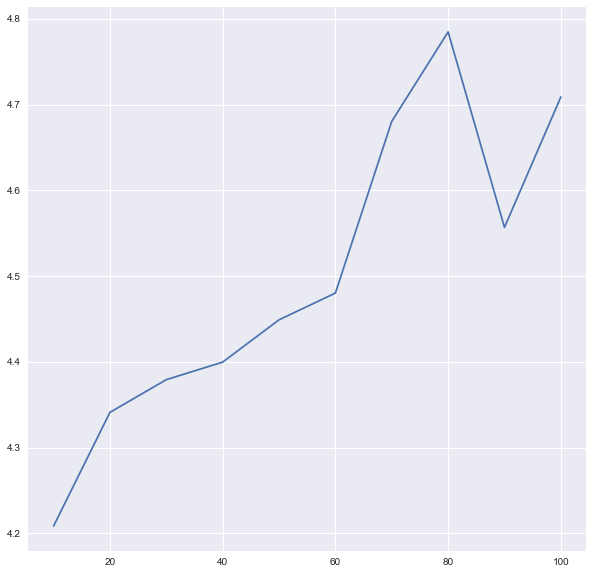

In [29]:
plt.figure(figsize = (10, 10))
plt.plot(jogen_list, rmse_list)
plt.show()

In [31]:
import pickle

f = open('rmse_list.binaryfile', 'wb')
pickle.dump(rmse_list, f)
f.close

<function BufferedWriter.close>

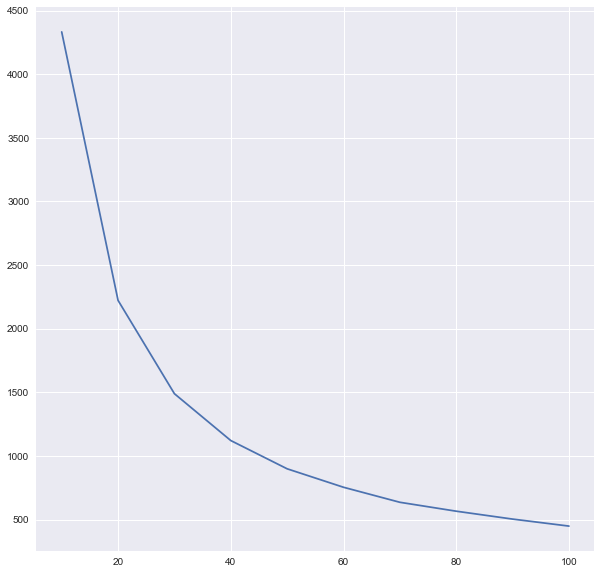

In [30]:
plt.figure(figsize = (10, 10))
plt.plot(jogen_list, count_list)
plt.show()

In [32]:
import pickle

f = open('polling_count_list.binaryfile', 'wb')
pickle.dump(count_list, f)
f.close

<function BufferedWriter.close>

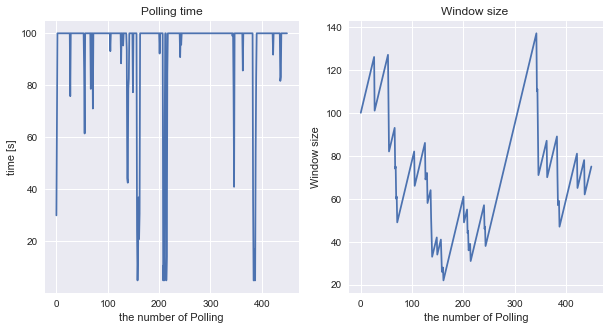

In [10]:
plt.figure(figsize = (10, 10))
plt.title("Polling time")
plt.ylabel("time [s]")
plt.xlabel("the number of Polling")
plt.plot(polling_time_list)
plt.show()

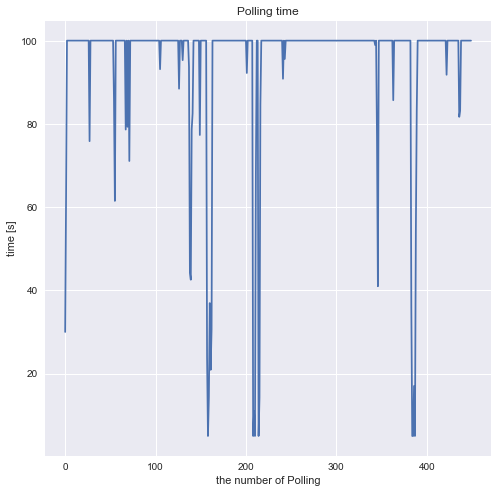

In [14]:
plt.figure(figsize = (8, 8))
plt.title("Polling time")
plt.ylabel("time [s]")
plt.xlabel("the number of Polling")
plt.plot(polling_time_list)
plt.savefig("./saving_image/polling_time_orifinal.png")
plt.show()

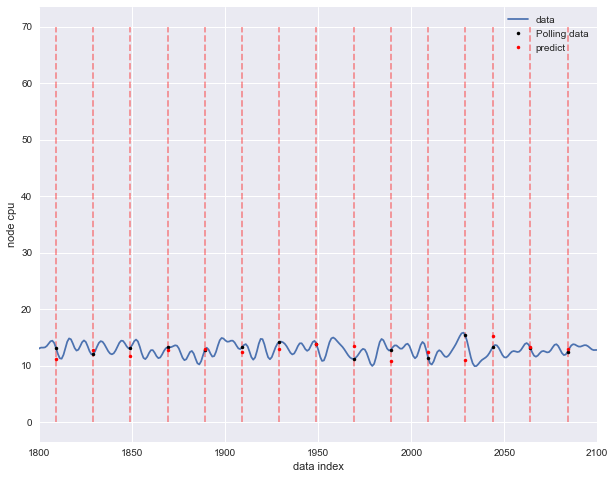

In [17]:
plt.figure(figsize = (10, 8))
plt.plot(data['node_cpu_usage_after_fft'], label = 'data')
plt.plot(data['node_cpu_usage_after_fft'].iloc[refer_index_list], '.', label = 'Polling data', color = 'k')
plt.plot(refer_index_list, predict_list, '.', label = 'predict', color = 'red')
#plt.ylim(4, 20)
plt.xlim(1800, 2100)
plt.vlines(refer_index_list, ymin = 0, ymax = 70 , color = 'red', linestyle = '--', alpha = 0.4)

plt.ylabel("node cpu")
plt.xlabel("data index")

plt.legend()
plt.savefig("./saving_image/polling_suii_original_regular.png")
plt.show()

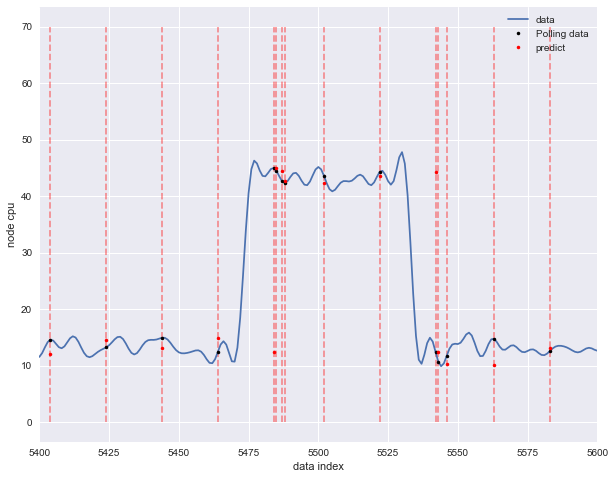

In [19]:
plt.figure(figsize = (10, 8))
plt.plot(data['node_cpu_usage_after_fft'], label = 'data')
plt.plot(data['node_cpu_usage_after_fft'].iloc[refer_index_list], '.', label = 'Polling data', color = 'k')
plt.plot(refer_index_list, predict_list, '.', label = 'predict', color = 'red')
#plt.ylim(4, 20)
plt.xlim(5400, 5600)
plt.vlines(refer_index_list, ymin = 0, ymax = 70 , color = 'red', linestyle = '--', alpha = 0.4)

plt.ylabel("node cpu")
plt.xlabel("data index")

plt.legend()
plt.savefig("./saving_image/polling_suii_original_anomaly.png")
plt.show()

In [11]:
import evaluation_by_rmse as eva
sample_list = [X[i] for i in refer_index_list]
train_size = int(np.round(X.shape[0] * 0.15))

func = eva.rmse(data = X, test_data = X[train_size:],
            refer_index = refer_index_list, 
            test_index = test_index, 
            sample_queue = sample_list )

In [12]:
func.evaluation()

4.722630554004671